# Josephson junctions

In this notebook, we want to present the basics of quantum computation like qubits and simple quantum mechanical operations that one can subject them to, as well as the physical systems which underlay their real-world realisation.

It is well know that quantum effects are quite difficult to maintain in the macroscopic systems - obviously, quantum mechanical and quantum field theoretical behaviour of matter and fields was seriously begun to be studied only in the first half of the XXth century because of that. While both atomic physicists and condensed matter physicists are constantly achieving breakthroughs, whether it is larger and larger macroscopic coherent systems like Bose–Einstein condensate or superconductive materials or quantum circuits obtained using more and more sophisticated, modern manufacturing processes.

In particular, with the use of superconductivity, one can manufacture highly non-linear, non-dissipative quantum systems called *Josephson junctions*, which constitute a physical realisation of qubits used in quantum computing. Both the non-linearity and non-dissipativeness are of the utmost importance for the control and maintenance of the quantum states. Using them, one can perform linear algebra on superposition states using quantum mechanical means, in order to perform computation using specially designed quantum algorithms (which are very much distinct from the classical algorithms used in classical computers) or to perform simulations of quantum mechanical systems.

The two lowest laying states of the Josephson junction constitute a two-dimensional unitary space which implements a qubit. By arranging multiple Josephson junctions on an integrated circuit and connecting them to each other one can manipulate the state of such an ensemble in a way which allows performing computations before the quantum mechanical state decoheres because of (unavoidable) interactions with the macroscopic, classical environment. 

This notebook is divided in 2 main parts:
- in [section 1](#1.-Harmonic-and-anharmonic-potentials), we will discuss the linear (and non-linear) nature of quantum mechanical systems. First, in [section 1.1](#1.1.-Harmonic-potentials), we will describe a prototypical linear quantum mechanical system - the harmonic oscillator - and discuss its properties, especially the behaviour of its energy levels. In [section 1.2](#1.2.-Anharmonic-potentials) we will focus on an example of a non-linear system, which we solve using DVR techniques, and compare the behaviour of energy levels with those of the harmonic oscillator.
- in [section 2](#2.-Physical-realisations-of-Josephson-junctions), we present a Josephson junction, in particular one type of Josephson junction called a charge qubit. We discuss two disparate regimes of that system: one given by the so-called voltage-biased Cooper-pair box, which we solve using numerical diagonalisation methods, and the other being so-called transmon qubit (which has a slightly more involved physical realisation involving 2 junctions, for manufacturing reasons), which we solve using DVR.

Outside of those main sections, we also include appendices that could be of interest for a motivated reader.

- In the [appendix A](#Appendix-A.-Momentum-secular-problem), we present the eigenproblem for the momentum operator which is solved using DVR. Because the position space is discretised and bounded in order to perform calculations in DVR, the allowed momenta are also discrete and bounded. Therefore, the problem $ {\hat p} \psi(x) = p \psi(x)$ allows to confirm that the momentum operator is properly implemented in DVR.
- The [appendix B](#Appendix-B.-Harmonic-oscillator-solved-numerically) solves the harmonic oscillator numerically, using the DVR method as opposed to the analytical calculation that was featured in section 1.1.
- In the [appendix C](#Appendix-C.-Alternative-solution-of-the-transmon-Hamiltonian) we present an alternative way of solving the voltage-biased Cooper-pair box in the transmon regime. Instead of utilising the DVR realisation of the momentum operator, one removes the dependence on the parameter $n_g$ from the Hamiltonian using an unitary transformation, which however also changes the periodicity conditions of the wavefunctions. 

## Preliminaries

In this section, we import all the necessary dependencies. Moreover, we enable the static type checking in Python.

In [1]:
%load_ext nb_mypy
%nb_mypy mypy-options --strict

Version 1.0.5


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import scipy
from typing import Any, Callable, Protocol, TypeVar, Tuple, Union

In [3]:
T = TypeVar('T')


class PCallable(Protocol):
    """
    Helper `typing.Protocol` class. 

    Parameters
    ----------
    x : TypeVar('T')
        First input variable.
    *args : float
        Positional arguments.

    Returns
    -------
    TypeVar('T')
        Output.               
    """

    def __call__(self, x: T, *args: float) -> T: ...

We define some important physical constants. In the following, we will use (unless specified) the Hartree atomic units. In this system of units, we have

$$ e, m_e, \hbar, k_e = 1 ,$$

where $e$ is the electric charge of electron, $m_e$ is the mass of electron, $\hbar$ is the reduced Planck's constant and $k_e = \frac {1}{4\pi \varepsilon_{0}}$ is the Coulomb constant. 

In [4]:
hbar = scipy.constants.hbar
echarge = scipy.constants.elementary_charge
hartree = scipy.constants.physical_constants['Hartree energy'][0]
mass_e = scipy.constants.electron_mass

In [5]:
mpl.rcParams['axes.labelsize'] = 13

In [6]:
def format_latex(number: float, precision: int = 2) -> str:
    r'''
    Returns a float as a string formatted in scientific notation
    in LaTeX format.

    Parameters
    ----------
    number : float
        Number to be formatted.
    precision : int
        Precision up to which mantissa is supposed to be displayed.

    Returns
    -------
    number_tex : str
        String containing the float formatted in scientific notation
        in LaTeX format.

    Examples
    --------
    >>> format_latex(539850)
    '5.40\\times 10^{+5}'
    >>> format_latex(0.00937859, 4)
    '9.3786\\times 10^{-3}'
    '''

    number_tex = f'{number:0.{precision}e}'.split('e')
    number_tex[1] = (number_tex[1][0] +
                     number_tex[1][1:].lstrip('0'))
    number_tex = r'\times 10^{'.join(number_tex)
    number_tex += '}'
    return number_tex

## 1. Harmonic and anharmonic potentials

### 1.1. Harmonic potentials

Using modern manufacturing techniques, one can create electric systems which exhibit quantum mechanical behaviours. In particular, for the purposes of quantum computing, the non-dissipative integrated circuits which display quantum behaviour are of particular interest. In the context of quantum computing of the most relevance are superconducting, strongly non-linear integrated circuits based Josephson junctions - to show why is that, let us first consider a more prototypical example of a quantum circuit, that is a system consisting of a capacitor with capacitance $C$ and an inductor with inductance $L$ which are connected in parallel to each other, called *LC oscillator* or *electromagnetic resonator*, as in the figure.

| ![LC resonator](./assets/images/LC_resonator.png "LC resonator") |
|:--:|
| *LC resonator* |

For the capacitor, the current running through it is proportional to the time-derivative of the voltage, with the capacitance as a proportionality constant. Given that the charge stored by the capacitor is given by $Q = CV$ one can write that

$$ I = C \frac{\text{d} V}{\text{d} t} = \frac{\text{d}}{\text{d} t}(CV) = \frac{\text{d} Q}{\text{d} t} .$$

As for the inductor, the voltage on the inductor is given by the following expression in terms of the current or in terms of the magnetic flux $\Phi = LI$

$$ V = L \frac{\text{d} I}{\text{d} t} = \frac{\text{d}}{\text{d} t}(LI) = \frac{\text{d} \Phi}{\text{d} t} .$$

Using those expressions with the Kirchoff's laws one can easily obtain the equation of motion for this system. However, by noting that the energy of the capacitor is $\frac{1}{2} CV^2$ and the energy of the inductor is $\frac{1}{2} LI^2 $, one can write down the energy of the circuit in terms of the charge $Q$ and the magnetic flux $\Phi$

$$ H = \frac{1}{2 C} Q^2 + \frac{1}{2 L} \Phi^2 .$$

We can quantise this system in two different ways: by taking the charge $Q$ as position and $p_Q = L {\dot Q} = \Phi$ as a conjugate momentum; or by taking the magnetic flux $\Phi$ as position and $p_\Phi = C {\dot \Phi} = Q$ as a conjugate momentum. We will choose the latter option - and to move from a configuration space $\{\Phi, {\dot \Phi}\}$ to the phase space $\{\Phi, p_\Phi\}$, we can express the time-derivative of the charge using the conjugate momentum $p_\Phi = C {\dot \Phi} = Q$, which is nothing else than the charge passing through the capacitor. Therefore, finally, the Hamiltonian has the form

$$ H = \frac{1}{2C} p_\Phi^2 + \frac{1}{2 L} \Phi^2 .$$

We see that this is nothing else than a harmonic oscillator with an effective mass of $C$ and the characteristic frequency $\frac{1}{\sqrt{LC}}$.

In a realistic scenario [\[1\]](#Bibliography), one can manufacture an LC oscillator using planar components with lateral dimensions approximately $10\, \mu m$, which leads to the capacitance $C = 1 \, pF$ and the inductance $L = 0.1 \, nH$. Those parameters give the characteristic frequency of the system of the order

$$\frac{\omega}{2\pi} \simeq 16 GHz .$$

A superconducting system at a temperature of $20 mK$ can be used for states whose frequency is less than $20 GHz$ without worrying about losses caused by the operation of superconductors (which are not however the only losses that the electromagnetic resonator is subjected to).

We are interested in the quantum mechanical behaviour of the circuit of this type. Therefore, let us quickly refresh some facts about quantum mechanical harmonic oscillators.

The harmonic oscillator is an almost canonical physical system, showing up both in the theoretical mechanics as well as quantum physics. It is characterised by a quadratic potential of the form

$$V(\Phi) = \frac{1}{2L} (\Phi - \Phi_c)^2 ,$$

where $\omega=\frac{1}{\sqrt{LC}}$ is the characteristic frequency of the oscillator, and $\Phi_c$ is the offset. The full Hamiltonian operator for a particle with effective mass $m=C$ in the potential of this type is given by the following expression

$$ H = \frac{\hat p_\Phi^2}{2C} + \frac{1}{2L} ({\hat \Phi} - \Phi_c)^2 .$$

For a quantum mechanical system, the magnetic flux (which we will also call position from now on) $\hat \Phi$ and the momentum $\hat p_\Phi$ are operators acting on a Hilbert space (or, more precisely, on a Gelfand triple) and are subjected to the canonical commutation relations

$$ [\hat \Phi, \hat p_\Phi] = i\hbar .$$

While this system can be solved using the theory of ordinary differential equations, the energy levels of the harmonic oscillator can be easily found by rephrasing the problem in terms of the creation and annihilation operators instead of the position and momentum. In fact, those two sets of operators are related by the following linear relations 

$$ {\hat \Phi} = \sqrt{ \frac{\hbar}{2} } \left( \frac{L}{C} \right)^{1/4} (a^\dagger + a) ,$$

$$ {\hat p_\Phi} = i \sqrt{ \frac{\hbar}{2} } \left( \frac{C}{L} \right)^{1/4} (a^\dagger - a) .$$

The creation operator $a$ and the annihilation operator $a^\dagger$ do not commute - in fact, their commutator is as follows

$$[a, a^\dagger] = 1 .$$

The Hamiltonian operator expressed in terms of $a$ and $a^\dagger$ takes the form

$$ H = \frac{\hbar}{\sqrt{LC}} ( a^\dagger a + \frac{1}{2} ) .$$

This Hamiltonian acts on a Hilbert space $\mathcal{H} = \text{span}\{|n\rangle\}_{n=0}^\infty$ spanned by vectors $|n\rangle$ (where $n\in\mathbb{Z}_{\geq0}$), which are the eigenvectors of the Hamiltonian. On those vectors, the $a^\dagger a$ acts as a number operator, and therefore their corresponding energies

$$ H |n\rangle = E_n |n\rangle ,$$

have the form

$$ E_n = \left(n + \frac{1}{2} \right)\frac{\hbar}{\sqrt{LC}} .$$

One can calculate the form of the wavefunctions which correspond to those states in the position or the momentum bases, which are expressed in terms of the Hermite polynomials (multiplied by an exponentially vanishing factor), which we will use in the class `HarmonicOscillator`. On can check that they are indeed compatible with wavefunctions obtained numerically using DVR technique by comparison with the [appendix B](#Appendix-B.-Harmonic-oscillator-solved-numerically). 

In [7]:
class HarmonicOscillator:
    '''
    Class to generate data (energies E and wave functions phi(x)) of harmonic 
    oscillator for given quadratic potentials, using the plane wave basis

    Parameters
    ----------
    N : int
        Number of points between `xmin` and `xmax`.
    xmin : float
        Minimal value of the domain.
    xmax : float
        Maximal value of the domain.
    x0 : np.ndarray[Any, np.dtype[np.float64]]
        (n_samples) array. Centres of the potentials for all
        samples.
    omega : np.ndarray[Any, np.dtype[np.float64]]
        (n_samples) array. Angular frequencies of the potentials 
        for all samples.
    mass : float
        (Effective) mass of the particle (by default equal to 1).
    hbar : float
        Reduced Planck constant (by default equal to 1).

    Attributes
    ----------
    N : int
        Number of points between `xmin` and `xmax`.
    xmin : float
        Minimal value of the domain.
    xmax : float
        Maximal value of the domain.
    x0 : np.ndarray[Any, np.dtype[np.float64]]
        (n_samples) array. Centres of the potentials for all
        samples.
    omega : np.ndarray[Any, np.dtype[np.float64]]
        (n_samples) array. Angular frequencies of the potentials 
        for all samples.
    mass : float
        (Effective) mass of the particle (by default equal to 1).
    hbar : float
        Reduced Planck constant (by default equal to 1).
    n_samples : int
        Number of sample potentials.

    Methods
    -------
    generate_data
        Solves Schrödinger equation for all given samples.
    evaluate_potential
        Returns the potentials alongside the domain.
    '''

    def __init__(self, N: int, xmin: float, xmax: float,
                 x0: np.ndarray[Any, np.dtype[np.float64]],
                 omega: np.ndarray[Any, np.dtype[np.float64]],
                 mass: float = 1., hbar: float = 1.):

        self.N = N  # Length of plane wave basis
        self.xmin = xmin  # xmin
        self.xmax = xmax  # xmax
        self.x0 = x0
        self.omega = omega
        self.mass = mass
        self.hbar = hbar
        self.n_samples = omega.shape[0]

    def generate_data(self, n_state: int
                      ) -> Tuple[np.ndarray[Any, np.dtype[np.float64]],
                                 np.ndarray[Any, np.dtype[np.float64]]]:
        '''
        Generates energies and `n_state` excited states for each sample potential.

        Parameters
        ----------
        n_state : int
            Number indicating the excited state (ground state corresponds to
            `n_state`=0)

        Returns
        -------
        E : np.ndarray[Any, np.dtype[np.float64]]
            (n_sample) array. Energies of the `n_state` state for each 
            potential.
        phis : np.ndarray[Any, np.dtype[np.float64]]
            (n_sample x N) array. Coefficients of the wave function 
            for each potential.

        Examples
        --------
        >>> import numpy as np
        >>> import scipy
        >>> rng = np.random.default_rng(42)
        >>> omega = rng.random((3,1))
        >>> x0 = rng.random((3,1))-1/2
        >>> hpot = HarmonicOscillator(3, 0, 1, x0, omega)
        >>> E, phis = hpot.generate_data(0)
        >>> E
        array([0.38697802, 0.21943922, 0.42929896])
        >>> phis
        array([[1.01972577, 1.02783458, 0.95063949],
               [1.09662169, 1.00851927, 0.88335143],
               [0.94345826, 1.030681  , 1.02351511]])
        '''
        x = np.arange(self.xmin, self.xmax,
                      (self.xmax - self.xmin)/self.N)
        sigma_inv = np.sqrt(self.mass*self.omega/self.hbar).reshape(-1, 1)
        all_x = (x - self.x0)*sigma_inv

        herm = scipy.special.eval_hermite(n_state, all_x)  # H_n(x/sigma)
        exp = np.exp(- all_x**2/2)  # Exponential term

        phis = exp*herm

        h = (self.xmax - self.xmin)/self.N
        # 1/np.sqrt(2**n * math.factorial(int(n))) * np.sqrt(sigma_inv)# Normalization constant
        C = 1./np.sqrt(np.sum(phis*phis*h, axis=1))
        C = C.reshape(-1, 1)
        phis = C*phis  # exp*herm

        E = self.hbar*self.omega*(n_state+1/2)
        E = E.flatten()

        return E, phis

    def evaluate_potential(self
                           ) -> Tuple[np.ndarray[Any, np.dtype[np.float64]],
                                      np.ndarray[Any, np.dtype[np.float64]]]:
        '''
        Evaluate the potentials V(x) and domain x.

        Parameters
        ----------
        N : int
            Number of points between `xmin` and `xmax`.
        xmin : float
            Minimal value of the domain.
        xmax : float
            Maximal value of the domain.

        Returns
        -------
        V : np.ndarray[Any, np.dtype[np.float64]]
            (n_samples x N) float-valued matrix encoding potentials for all
            samples.
        x : np.ndarray[Any, np.dtype[np.float64]]
            (N) array. Values in the domain between xmin and xmax.

        Examples
        --------
        >>> import numpy as np
        >>> import scipy
        >>> rng = np.random.default_rng(42)
        >>> omega = rng.random((3,1))
        >>> x0 = rng.random((3,1))-1/2
        >>> hpot = HarmonicOscillator(3, 0, 1, x0, omega)
        >>> V, x = hpot.evaluate_potential()
        >>> V
        array([[0.01166692, 0.0055368 , 0.06596312],
               [0.01586102, 0.05261756, 0.11077569],
               [0.08338236, 0.00746264, 0.01345296]])
        >>> x
        array([0.        , 0.33333333, 0.66666667])
        '''
        x = np.arange(self.xmin, self.xmax,
                      (self.xmax - self.xmin)/self.N)
        V = (x-self.x0)**2 * 1/2*self.mass*self.omega**2

        return V, x

We want to visualise the solutions and energy levels for some, randomly chosen, quantum harmonic oscillators. We choose the parameters as below:

 - `phimin`, `phimax`: the parameters which determine the domain $\mathcal{D}=[\Phi_{min}, \Phi_{max}]$ of the potential $V(\Phi), \Phi\in D$;
 - `N`: the amount of discretisation points into which we divide the domain $\mathcal{D}$ - higher $N$ corresponds to more precise numerical solution of the Schrödinger equation if one uses the DVR method;
 - `n_samples`: the number of triples (potential, wave function, energy) which will be generated;
 - `n_state`: determines the nth excited state of the Schrödinger equation, counting from the ground state (given by `n_state=0`) upwards with growing energy;
 - `C`: the capacitance $C$;
 - `L`: the inductance $L$ of the potentials $V(\Phi)$ for each sample;
 - `phic`: the offset $\Phi_c$ of the potentials $V(\Phi)$ for each sample;

In [8]:
phimin = -4
phimax = 4
N = 200
n_samples = 5
n_state = 0
C = 10**(-12)  # Value in farads (F)
C /= (echarge**2/hartree)
L = np.array([10**(-10)])  # Value in henrys (H)
L = L*(1+0.5*(np.random.random((n_samples, 1))-1/2))
L /= (hbar**2/echarge**2/hartree)
phic = 2*(np.random.random((n_samples, 1))-1/2)

C_HO = C
L_HO = L

mass = C
omegas = 1/np.sqrt(L*C)

ho = HarmonicOscillator(N, phimin, phimax, phic, omegas, mass,
                        hbar=1)  # hbar=1 because we use atomic units

E_HO, waves_HO = ho.generate_data(n_state)
V_HO, phi = ho.evaluate_potential()

We graph several quadratic potentials, which are the potentials for the harmonic oscillator system. As one sees, the characteristic frequency governs how fast the potential is growing.

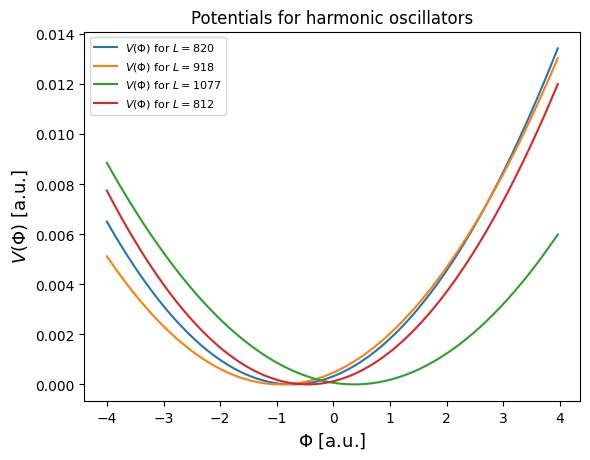

In [9]:
for i, potential in enumerate(V_HO[:4]):
    label = r"$V(\Phi)$ for $L =" f"{L[i][0]:0.0f}" r"$"
    plt.plot(phi, potential, label=label)
plt.xlabel(r'$\Phi$ [a.u.]')
plt.ylabel(r'$V(\Phi)$ [a.u.]')
plt.title(f'Potentials for harmonic oscillators')
plt.legend(prop={'size': 8});

As for the wavefunctions, we see that the ground state is concentrated at the bottom of the energy well. It is even more pronounced given the offsets of the potentials, so it is very much clear which wavefunction corresponds to which potential.

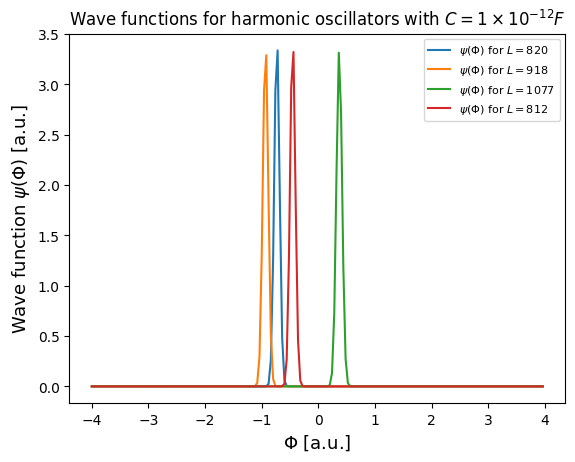

In [10]:
for i, wavefunction in enumerate(waves_HO[:4]):
    label = r"$\psi(\Phi)$ for $L =" f"{L[i][0]:0.0f}" r"$"
    plt.plot(phi, wavefunction, label=label)
plt.xlabel(r'$\Phi$ [a.u.]')
plt.ylabel('Wave function $\psi(\Phi)$ [a.u.]')
plt.title('Wave functions for harmonic oscillators '
          f'with $C={format_latex(C*(echarge**2/hartree),0)} F$')
plt.legend(prop={'size': 8});

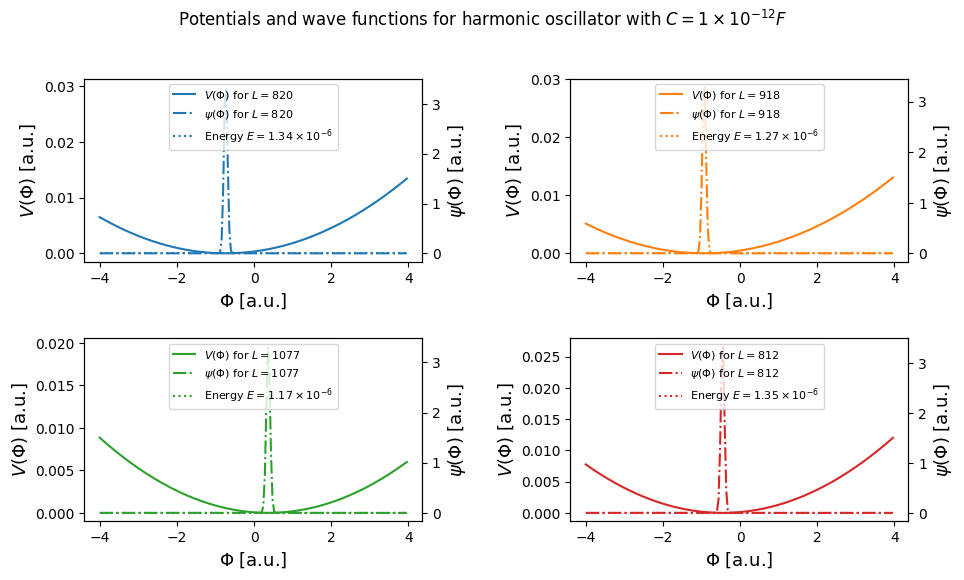

In [11]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle("Potentials and wave functions for harmonic oscillator with "
             f"$C={format_latex(C*(echarge**2/hartree),0)} F$")
colours = list(mcolors.TABLEAU_COLORS)
for i, omega in enumerate(omegas.flatten()[:4]):
    Vrange = V_HO[i].max()-V_HO[i].min()
    alpha = Vrange/1.5-np.abs(E_HO[i])
    ax = plt.subplot(2, 2, i+1)
    label_wave = r"$\psi(\Phi)$ for $L =" f"{L[i][0]:0.0f}" r"$"
    label_V = r"$V(\Phi)$ for $L =" f"{L[i][0]:0.0f}" r"$"
    label_E = r"Energy $E = " f"{format_latex(E_HO[i])} $"
    ln1 = ax.plot(phi, V_HO[i], '-', color=colours[i], label=label_V)
    ln2 = ax.plot(phi, alpha*waves_HO[i]+E_HO[i],
                  '-.', color=colours[i], label=label_wave)
    ln3 = ax.plot(phi, E_HO[i]*np.ones_like(phi), ':',
                  color=colours[i], label=label_E)
    plt.xlabel('$\Phi$ [a.u.]')
    plt.ylabel('$V(\Phi)$ [a.u.]')
    ypmax = (ax.get_ylim()[1]-E_HO[i])/alpha
    ypmin = (ax.get_ylim()[0]-E_HO[i])/alpha
    ax2 = ax.twinx()
    ax2.set_ylim((ypmin, ypmax))
    plt.ylabel('$\psi(\Phi)$ [a.u.]')
    ax.legend(loc='upper center', prop={'size': 8})
fig.tight_layout(pad=2.0)

Finally, we can calculate the energies for lowest laying states for those disparate potentials which we are considering.

Afterwards, we can compute the differences of energies $\Delta E_n = E_{n+1} - E_0$ as a function of the number operator eigenvalue $n$ (or, alternatively, excitation level).

In [12]:
Es_HO = []
for n_state in range(10):
    Es_HO.append(ho.generate_data(n_state)[0])
Es_HO = np.array(Es_HO).T
with np.printoptions(precision=2, suppress=False):
    print(Es_HO)

[[1.34e-06 4.02e-06 6.70e-06 9.38e-06 1.21e-05 1.47e-05 1.74e-05 2.01e-05
  2.28e-05 2.55e-05]
 [1.27e-06 3.80e-06 6.33e-06 8.86e-06 1.14e-05 1.39e-05 1.65e-05 1.90e-05
  2.15e-05 2.41e-05]
 [1.17e-06 3.51e-06 5.85e-06 8.18e-06 1.05e-05 1.29e-05 1.52e-05 1.75e-05
  1.99e-05 2.22e-05]
 [1.35e-06 4.04e-06 6.73e-06 9.43e-06 1.21e-05 1.48e-05 1.75e-05 2.02e-05
  2.29e-05 2.56e-05]
 [1.33e-06 3.98e-06 6.63e-06 9.28e-06 1.19e-05 1.46e-05 1.72e-05 1.99e-05
  2.25e-05 2.52e-05]]


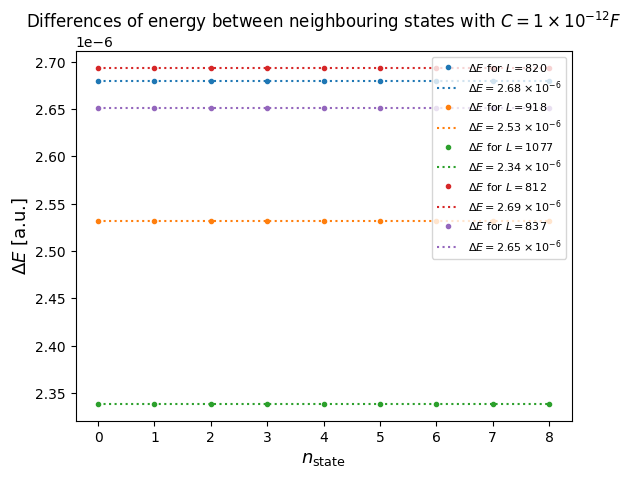

In [13]:
fig, ax = plt.figure(), plt.axes()
colours = list(mcolors.TABLEAU_COLORS)
for i, E in enumerate(np.diff(Es_HO, 1)):
    plt.plot(np.arange(E.shape[0]), E, '.', color=colours[i],
             label=f"$\Delta E$ for $L =" f"{L[i][0]:0.0f}" r"$")
    plt.plot(np.arange(E.shape[0]),
             omegas[i][0]*np.ones(E.shape[0]), ':',
             color=colours[i],
             label=f"$\Delta E ={format_latex(omegas[i][0])}$")
plt.legend(prop={'size': 8}, loc='upper right')
plt.xlabel(r'$n_{\text{state}}$')
plt.ylabel('$\Delta E$ [a.u.]')
plt.title("Differences of energy between neighbouring states with "
          f"$C={format_latex(C*(echarge**2/hartree),0)} F$")
plt.xticks(np.arange(Es_HO.shape[1]-1));

Let us remind that the energy for the harmonic oscillator is given by

$$ E_n = \left(n + \frac{1}{2} \right) \frac{\hbar}{\sqrt{LC}} .$$

Therefore, the difference of energies is constant, and given by the characteristic frequency

$$ \Delta E_n = \frac{\hbar}{\sqrt{LC}} .$$

That does explain the constant function behaviour displayed in the graph above.

This independence of the differences of energies is known under the name of *harmonicity* - a quantum mechanical system is *harmonic* if it exhibit harmonicity. On the other hand, quantum systems which are not harmonic are called *anharmonic*.

What does harmonicity has to do with quantum computing and qubits? Let us use an analogy with a classical computer: ordinary computers use *bits*, which are the most fundamental units of information in classical computing and represent logical states with only two values, usually $0$ and $1$. Therefore, in quantum computing, one is interested in two-dimensional quantum systems (described by two-dimensional unitary spaces) which are easy to manipulate.

However, in a harmonic system, one cannot distinguish such two-dimensional subspace! Because the differences between the energies of the neighbouring states are constant, the excitation of the ground state to the first excited state is as much possible as excitation of the first excited state to the second, the second to the third etc., and the sam for emission in the other direction. Therefore, in order to be able to manipulate just the two-dimensional subspace corresponding to the lowest energy level states (and therefore for the system to be a good qubit model), we need for the system to be anharmonic.

### 1.2. Anharmonic potentials

We are ready therefore to consider a different type of system - an anharmonic system. While one can choose various different potenatials which provide one with anharmonic systems, of particular interest for us is the so-called "tilted washboard" potential, which is composed of a linear terms with a cosine term in the following way

$$ V_\text{phase}(\phi) = - \frac{\Phi_0}{2 \pi} I \phi - E_J \cos\phi ,$$

where $\Phi_0 = \frac{h}{2e}$, $h$ is the Planck constant, $e$ is the electric charge and $I$ is a parameter with the dimension of electric current.

The total Hamiltonian of a system of this type is given by

$$ H_\text{phase} = 4 E_C p_\phi^2 - \frac{\Phi_0}{2 \pi} I \phi - E_J \cos\phi, $$

where 

$$ E_C = \frac{1}{8 C_J} \left( \frac{2 \pi \hbar}{\Phi_0} \right)^2 = \frac{e^2}{2 C_J} , $$

and $C_J$ is a parameter with the dimension of capacitance and

$$ [\phi, p_\phi] = i .$$

The phase $\phi$ and its conjugate momentum are a dimensionless quantity, i.e. $[\phi] = 1$ and $[p_\phi] = 1$.

We are interested in the regime where $ E_C \ll E_J$. The physically relevant choice of parameters would be of the order from $E_J/E_C \approx 10^4$ [\[8, 10\]](#Bibliography) to $E_J/E_C \approx 10^6$ [\[2\]](#Bibliography).

By a classical analysis one can determine that, for small values of the parameter $I$, the potential $V_\text{phase}$ has a minimum at the point

$$ \phi = \arcsin\left( \frac{\Phi_0}{2\pi E_J} I\right) .$$

In the absence of the current $I$, the minimum is at $\phi=0$, and with a growing current it is moving to the right, until a critical value of the current $I_0 = 2\pi E_J/\Phi_0$, in which case the potential ceases to have any minima, and the extrema become inflexion points.

| ![Titled washboard potentials](./assets/images/titled_washboard.png "Titled washboard potentials") |
|:--:|
| *Titled washboard potentials* |

On the figure one has plotted the tilted washboard potential for various values of 

$$\frac{\Phi_0}{2 \pi E_J} I = 0, 0.1, 0.5, 1 .$$

For the critical current $I_0$, illustrated on the figure by the red-coloured graph, the minimum becomes an inflexion point at $\pi = \frac{\pi}{2}$.

By expanding the potential in a series around the minimum indicated above, one can estimate how much the potential differs from the quadratic potential in the infinitesimal neighbourhood of the minimum. It is evident that, when the current $I$ is absent, i.e. $I=0$, the potential is quadratic up to $O(\phi^4)$ terms

$$ V_\text{phase}(\phi) = - E_J \left( 1 - \frac{\phi^2}{2!} + \frac{\phi^4}{4!} + O(\phi^6) \right) ,$$

and behaves like an $LC$ resonator with an effective indictance $L_\text{eff} = \frac{\Phi_0}{2 \pi I_0}$. One can show that using the following expansion, but first one has to go from the dimensionless phase $\phi$ to a variable which has the dimension of the magnetic flux $\Phi$, which we used in the [previous section](#1.1.-Harmonic-potentials). To do that, we define

$$ \phi = \frac{2\pi}{\Phi_0} \Phi, \qquad p_\phi = \frac{\Phi_0}{2\pi\hbar} p_\Phi .$$

Using this phase space, the Hamiltonian takes the form

$$ H_\text{phase} = \frac{p_\Phi^2}{2 C_J} - I \Phi - E_J \cos\left(\frac{2\pi}{\Phi_0} \Phi \right). $$

If we consider the vanishing current $I=0$ and expand the cosine, we obtain

$$ H_\text{phase} = \frac{p_\Phi^2}{2 C_J} - E_J + \frac{1}{2} E_J \left(\frac{2\pi}{\Phi_0} \right)^2 \Phi^2 + O(\Phi^4). $$

We see by inspection that the effective indictance of this system is nothing else than 

$$L_\text{eff} = \frac{1}{E_J} \left( \frac{\Phi_0}{2 \pi} \right)^2 ,$$

which can be easily cast in the form involving the critical current $I_0$ as above.

The characteristing frequency of this approximate harmonic oscillator is

$$ \omega_\text{eff} = \frac{\sqrt{8 E_C E_J}}{\hbar} .$$

However, when one considers the critical current $I = I_0 \sin(\phi)$, then quadratic term is absent, and the first physically significant term in the expansion is of the order $O(\phi^3)$ - i.e. the potential is highly anharmonic.

While one would want to consider the potential as anharmonic as possible, it is important to note that the depth of the potential well around the minimum gets smaller and smaller with the growing current until achieving the critical value, when the minimum becomes an inflexion point. In that case, the particle is essentially free on the right hand side of the potential. 

In that case, one cannot utilise the DVR method to numerically compute the energies and wavefunctions of the quantum states. Therefore, instead of considering the critical case, we will focus on the values of the parameters which are

$$ \frac{\Phi_0}{2 \pi E_J} I = 0.1 ,$$

which is sufficiently anharmonic for our purposes. We invite the reader to study how modification of the parameters changes the results of the analysis.

In [14]:
class CustomPotential:
    '''
    Class to generate data (energies E and wave functions phi(x)) for given
    potentials, using the plane wave basis.

    Parameters
    ----------
    N : int
        Number of points between `xmin` and `xmax`.
    xmin : float
        Minimal value of the domain.
    xmax : float
        Maximal value of the domain.
    V : np.ndarray[Any, np.dtype[np.float64]]
        (n_samples x N) float-valued matrix encoding potentials for all
        samples.
    mass : float
        (Effective) mass of the particle (by default equal to 1).
    hbar : float
        Planck constant (by default equal to 1).

    Attributes
    ----------
    N : int
        Number of points between `xmin` and `xmax`.
    xmin : float
        Minimal value of the domain.
    xmax : float
        Maximal value of the domain.
    V : np.ndarray[Any, np.dtype[np.float64]]
        (n_samples x N) float-valued matrix encoding potentials for all
        samples.
    mass : float
        (Effective) mass of the particle.
    hbar : float
        Planck constant.
    n_samples : int
        Number of sample potentials.
    T : np.ndarray[Any, np.dtype[Any]]
        (N x N) array. Kinetic energy part of the Hamiltonian.

    Methods
    -------
    find_eigen_state
        Solves the Hamiltonian and returns energy eigenvalues
        and eigenvectors.
    create_kinetic_energy
        Returns a kinetic energy operator.
    generate_data
        Solves Schrödinger equation for all given samples.
    evaluate_potential
        Returns the potentials alongside the domain.
    final_wavefunction
        Returns a wave function with appropriate phase.
    '''

    def __init__(self, N: int, xmin: float, xmax: float,
                 V: np.ndarray[Any, np.dtype[np.float64]],
                 mass: float = 1., hbar: float = 1.) -> None:

        self.mass = mass
        self.hbar = hbar
        self.N = N  # Length of plane wave basis
        self.xmin = xmin  # xmin
        self.xmax = xmax  # xmax
        self.V = V
        self.n_samples = V.shape[0]
        self.T = self.create_kinetic_energy()

    def create_kinetic_energy(self
                              ) -> np.ndarray[Any, np.dtype[Any]]:
        '''
        Construct the kinetic energy part of the Hamiltonian.

        Parameters
        ----------

        Returns
        -------
        T : np.ndarray[Any, np.dtype[Any]]
            (N x N) array. Kinetic energy part of the Hamiltonian.

        Examples
        --------
        >>> import numpy as np
        >>> import scipy
        >>> rng = np.random.default_rng(42)
        >>> V = rng.random((2,3))
        >>> cpot = CustomPotential(3, 0, 1, V)
        >>> cpot.create_kinetic_energy()
        array([[ 18.09427474, -13.15947253,  13.15947253],
               [-13.15947253,  18.09427474, -13.15947253],
               [ 13.15947253, -13.15947253,  18.09427474]])
        '''

        N = self.N  # N==N
        xmin = self.xmin  # xmin
        xmax = self.xmax  # xmax

        T = np.zeros((N, N))
        delta_x = (xmax-xmin)/N
        L = delta_x*N
        mu = self.mass
        # Build matrix T using the plane wave basis

        for n in range(N):
            for m in range(N):
                if(n == m):
                    T[n, m] = self.hbar**2 * \
                        (-1)**(n-m)*np.pi**2/(mu*L**2)*(N**2+2)/6
                elif(n != m):
                    T[n, m] = self.hbar**2*(-1)**(n-m)*np.pi**2/(mu*L**2) * \
                        1./(np.sin(np.pi*(n-m)/N))**2

        return T

    def find_eigen_state(self, V: np.ndarray[Any, np.dtype[np.float64]],
                         n_state: int
                         ) -> Tuple[float,
                                    np.ndarray[Any, np.dtype[Any]]]:
        '''
        Finds the eigenvector for Hamiltonians with potentials V(x).

        Parameters
        ----------
        V : np.ndarray[Any, np.dtype[np.float64]]
            The potentials of the system.
        n_state : int
            Number indicating the excited state (ground state corresponds to
            `n_state`=0)

        Returns
        -------
        E_a : float
            Energies of the `n_state` state for potential `V`.
        a : np.ndarray[Any, np.dtype[Any]]
            N array. Coefficients in the basis of the H.O. potential.

        Examples
        --------
        >>> import numpy as np
        >>> import scipy
        >>> rng = np.random.default_rng(42)
        >>> V = rng.random((2,3))
        >>> cpot = CustomPotential(3, 0, 1, V)
        >>> cpot.find_eigen_state(V[0], 0)
        (5.496366546067522, array([0.81574651, 1.41220614, 0.58329362]))
        '''
        # 0. Generate matrix of C_nm
        N = self.N  # N==N
        xmin = self.xmin  # xmin
        xmax = self.xmax  # xmax

        delta_x = (xmax-xmin)/N
        L = delta_x*N

        # 1. Build matrix T using the plane wave basis
        T = self.T

        # 2. Build matrix V
        V = np.diag(V)

        # 3. Build matrix H
        if np.can_cast(V.dtype, T.dtype):
            H = np.zeros((N, N), dtype=T.dtype)
            veps = np.zeros((N, N), dtype=T.dtype)
            vaps = np.zeros(N, dtype=T.dtype)
        else:
            H = np.zeros((N, N), dtype=V.dtype)
            veps = np.zeros((N, N), dtype=V.dtype)
            vaps = np.zeros(N, dtype=V.dtype)

        H = T + V

        # 4. Diagonalize matrix H
        vaps, veps = np.linalg.eigh(H)

        # 5. Set bound wave functions to be real and normalize them
        for n in range(N):
            if np.iscomplexobj(veps):
                norm = veps[:, n].conj().T @ veps[:, n]
            else:
                norm = np.dot(veps[:, n], veps[:, n])
            macloc = np.argmax(abs(veps[:, n]))
            veps[:, n] = veps[:, n]*abs(veps[macloc, n])/veps[macloc, n]
            veps[:, n] = veps[:, n]/np.sqrt(delta_x*norm)

        # 6. We choose the vector with n_state-th lowest energy
        # as an approximation of the n_state state
        a = veps[:, n_state]  # Final value of eigenvalues for state n_state
        if not np.iscomplex(vaps[n_state]).sum():
            E_a = vaps[n_state].real.astype(np.float64)  # Value of the energy
        else:
            E_a = vaps[n_state]

        return E_a, a

    def generate_data(self, n_state: int, display: int | None = 100
                      ) -> Tuple[np.ndarray[Any, np.dtype[np.float64]],
                                 np.ndarray[Any, np.dtype[Any]]]:
        '''
        Generates energies and `n_state` excited states for each sample potential.

        Parameters
        ----------
        n_state : int
            Number indicating the excited state (ground state corresponds to
            `n_state`=0)
        display : int | None
            Frequency of updates during solving. If None, the updates 
            are supressed.

        Returns
        -------
        E : np.ndarray[Any, np.dtype[np.float64]]
            (n_sample) array. Energies of the `n_state` state for each potential V.
        a : np.ndarray[Any, np.dtype[Any]]
            (n_sample x N) array. Coefficients in the basis of the H.O. potential
            for each potential V.

        Examples
        --------
        >>> import numpy as np
        >>> import scipy
        >>> rng = np.random.default_rng(42)
        >>> V = rng.random((2,3))
        >>> cpot = CustomPotential(3, 0, 1, V)
        >>> E, a = cpot.generate_data(0, None)
        >>> E
        array([5.49636655, 5.26099885])
        >>> a
        array([[0.81574651, 1.41220614, 0.58329362],
               [0.87865515, 1.40562287, 0.50218469]])
        '''
        data = np.zeros((self.n_samples, self.N))

        # Prepare vectors of energies and coefficients
        E = np.zeros(self.n_samples)
        if np.can_cast(self.V.dtype, self.T.dtype):
            a = np.zeros((self.n_samples, self.N), dtype=self.T.dtype)
        else:
            a = np.zeros((self.n_samples, self.N), dtype=self.V.dtype)
        # Find ground state for each sample
        for i in range(self.n_samples):
            E_new, a_new = self.find_eigen_state(self.V[i, :], n_state)
            if display is not None:
                if i % display == 0:
                    print(f"\rGenerating data: {i}/{self.n_samples}",
                          end='')
            E[i] = E_new
            a[i, :] = a_new
        return E, a

    def evaluate_potential(self
                           ) -> Tuple[np.ndarray[Any, np.dtype[np.float64]],
                                      np.ndarray[Any, np.dtype[np.float64]]]:
        '''
        Evaluate the potentials V(x) and domain x.

        Parameters
        ----------

        Returns
        -------
        V : np.ndarray[Any, np.dtype[np.float64]]
            (n_samples x N) float-valued matrix encoding potentials for all
            samples.
        x : np.ndarray[Any, np.dtype[np.float64]]
            (N) array. Values in the domain between xmin and xmax.

        Examples
        --------
        >>> import numpy as np
        >>> import scipy
        >>> rng = np.random.default_rng(42)
        >>> V = rng.random((2,3))
        >>> cpot = CustomPotential(3, 0, 1, V)
        >>> V, x = cpot.evaluate_potential()
        >>> V
        array([[0.77395605, 0.43887844, 0.85859792],
               [0.69736803, 0.09417735, 0.97562235]])
        >>> x
        array([0.        , 0.33333333, 0.66666667])
        '''
        x = np.arange(self.xmin, self.xmax,
                      (self.xmax - self.xmin)/self.N)
        V = self.V

        return V, x

    def final_wavefunction(self, a: np.ndarray[Any, np.dtype[np.float64]]
                           ) -> Tuple[np.ndarray[Any, np.dtype[Any]],
                                      np.ndarray[Any, np.dtype[np.float64]],
                                      np.ndarray[Any, np.dtype[Any]]]:
        '''
        Returns the final wavefunctions psi(x) for each sample potential.

        Parameters
        ----------
        a : np.ndarray[Any, np.dtype[Any]]
            (n_sample x N) array. Coefficients in the basis of the H.O. potential
            for each potential V.

        Returns
        -------
        waves : np.ndarray[Any, np.dtype[Any]]
            (n_samples x N) array. Wave functions for each potential, with 
            a corrected phase factor.
        x : np.ndarray[Any, np.dtype[np.float64]]
            (N) array. Values in the domain between xmin and xmax.
        a : np.ndarray[Any, np.dtype[Any]]
            (n_sample x N) array. Coefficients in the basis of the H.O. potential
            for each potential V.

        Examples
        --------
        >>> import numpy as np
        >>> import scipy
        >>> rng = np.random.default_rng(42)
        >>> V = rng.random((2,3))
        >>> cpot = CustomPotential(3, 0, 1, V)
        >>> E, a = cpot.generate_data(0, None)
        >>> waves, x, phis = cpot.final_wavefunction(a)
        >>> waves
        array([[0.81574651, 1.41220614, 0.58329362],
               [0.87865515, 1.40562287, 0.50218469]])
        >>> x
        array([0.        , 0.33333333, 0.66666667])
        >>> phis
        array([[0.81574651, 1.41220614, 0.58329362],
               [0.87865515, 1.40562287, 0.50218469]])
        '''
        x = np.arange(self.xmin, self.xmax,
                      (self.xmax - self.xmin)/self.N)
        # Construct matrix of waves
        if np.can_cast(self.V.dtype, self.T.dtype):
            waves = np.zeros((self.n_samples, self.N), dtype=self.T.dtype)
        else:
            waves = np.zeros((self.n_samples, self.N), dtype=self.V.dtype)

        waves = a.copy()
        for i in range(self.n_samples):
            # convention: To choose the phase we make the maximums be first
            w = waves[i, :]
            maxi = scipy.signal.argrelextrema(w, np.greater)[0]
            mini = scipy.signal.argrelextrema(w, np.less)[0]
            idx2 = np.abs(w[maxi]) > 5e-2
            maxi = maxi[idx2]
            idx2 = np.abs(w[mini]) > 5e-2
            mini = mini[idx2]
            if len(maxi) == 0 and len(mini) > 0:
                waves[i, :] = -waves[i, :]
            elif len(mini) > 0 and len(maxi) > 0 and mini[0] < maxi[0]:
                waves[i, :] = -waves[i, :]
        return waves, x, a

In [15]:
class CustomKineticOperator(CustomPotential):
    '''
    Class to generate data (energies E and wave functions phi(x)) for given
    potentials, using the plane wave basis

    Parameters
    ----------
    N : int
        Number of points between `xmin` and `xmax`.
    xmin : float
        Minimal value of the domain.
    xmax : float
        Maximal value of the domain.
    V : np.ndarray[Any, np.dtype[np.float64]]
        (n_samples x N) float-valued matrix encoding potentials for all
        samples.
    mass : float
        (Effective) mass of the particle (by default equal to 1).
    hbar : float
        Planck constant (by default equal to 1).
    quad_kin_coeff : float
        Coefficient of the term proportional to the square
        of momentum in the kinetic energy operator.
    lin_kin_coeff : float
        Coefficient of the term proportional to momentum
        in the kinetic energy operator.
    const_kin_coeff : float
        Coefficient of a constant term in the kinetic energy 
        operator.

    Attributes
    ----------
    N : int
        Number of points between `xmin` and `xmax`.
    xmin : float
        Minimal value of the domain.
    xmax : float
        Maximal value of the domain.
    V : np.ndarray[Any, np.dtype[np.float64]]
        (n_samples x N) float-valued matrix encoding potentials for all
        samples.
    mass : float
        (Effective) mass of the particle.
    hbar : float
        Planck constant.
    quad_kin_coeff : float
        Coefficient of the term proportional to the square
        of momentum in the kinetic energy operator.
    lin_kin_coeff : float
        Coefficient of the term proportional to momentum
        in the kinetic energy operator.
    const_kin_coeff : float
        Coefficient of a constant term in the kinetic energy 
        operator.
    n_samples : int
        Number of sample potentials.
    T : Union[np.ndarray[Any, np.dtype[np.float64]],
              np.ndarray[Any, np.dtype[np.complex128]]]
        (N x N) array. Kinetic energy part of the Hamiltonian.

    Methods
    -------
    find_eigen_state
        Solves the Hamiltonian and returns energy eigenvalues
        and eigenvectors.
    create_kinetic_energy
        Returns a kinetic energy operator.
    generate_data
        Solves Schrödinger equation for all given samples.
    evaluate_potential
        Returns the potentials alongside the domain.
    final_wavefunction
        Returns a wave function with appropriate phase.
    '''

    def __init__(self, N: int, xmin: float, xmax: float,
                 V: np.ndarray[Any, np.dtype[np.float64]],
                 mass: float = 1., hbar: float = 1.,
                 quad_kin_coeff: float = 1.,
                 lin_kin_coeff: float = 0.,
                 const_kin_coeff: float = 0.) -> None:
        super().__init__(N, xmin, xmax, V, mass, hbar)
        self.quad_kin_coeff = quad_kin_coeff
        self.lin_kin_coeff = lin_kin_coeff
        self.const_kin_coeff = const_kin_coeff
        self.T = self.create_kinetic_energy(self.quad_kin_coeff,
                                            self.lin_kin_coeff,
                                            self.const_kin_coeff)

    def create_kinetic_energy(self,
                              quad_kin_coeff: float = 1.,
                              lin_kin_coeff: float = 0.,
                              const_kin_coeff: float = 0.,
                              ) -> Union[np.ndarray[Any, np.dtype[np.float64]],
                                         np.ndarray[Any, np.dtype[np.complex128]]]:
        '''
        Construct the kinetic energy part of the Hamiltonian.

        Parameters
        ----------
        quad_kin_coeff : float
            Coefficient of the term P^2/(2m) in the kinetic energy operator.
        lin_kin_coeff : float
            Coefficient of the term P/m (i.e. momentum divided by mass)
            in the kinetic energy operator.
        const_kin_coeff : float
            Coefficient of a constant term 1/(2m) in the kinetic energy 
            operator (practically just shifts all energy levels).

        Returns
        -------
        T : Union[np.ndarray[Any, np.dtype[np.float64]],
                  np.ndarray[Any, np.dtype[np.complex128]]]
            (N x N) array. Kinetic energy part of the Hamiltonian.

        Examples
        --------
        >>> import numpy as np
        >>> import scipy
        >>> rng = np.random.default_rng(42)
        >>> V = rng.random((2,3))
        >>> ckin = CustomKineticOperator(3, 0, 1, V)
        >>> ckin.create_kinetic_energy()
        array([[ 18.09427474, -13.15947253,  13.15947253],
               [-13.15947253,  18.09427474, -13.15947253],
               [ 13.15947253, -13.15947253,  18.09427474]])

        The method can also take additional parameters, adding a term
        proportional to momentum to the kinetic energy operator
        with the use of `lin_kin_coeff`.

        >>> import numpy as np
        >>> import scipy
        >>> rng = np.random.default_rng(42)
        >>> V = rng.random((2,3))
        >>> ckin = CustomKineticOperator(3, 0, 1, V, lin_kin_coeff=1)
        >>> ckin.create_kinetic_energy(lin_kin_coeff=1).round(3)
        array([[ 14.953+0.j   , -10.018-1.814j,  10.018-1.814j],
               [-10.018+1.814j,  14.953+0.j   , -10.018-1.814j],
               [ 10.018+1.814j, -10.018+1.814j,  14.953+0.j   ]])

        One can also add a constant term to the kinetic energy
        operator using `const_kin_coeff` parameter.

        >>> import numpy as np
        >>> import scipy
        >>> rng = np.random.default_rng(42)
        >>> V = rng.random((2,3))
        >>> ckin = CustomKineticOperator(3, 0, 1, V, \
                                         const_kin_coeff=1)
        >>> ckin.create_kinetic_energy(const_kin_coeff=1)
        array([[ 18.59427474, -13.15947253,  13.15947253],
               [-13.15947253,  18.59427474, -13.15947253],
               [ 13.15947253, -13.15947253,  18.59427474]])
        '''
        N = self.N  # N==N
        xmin = self.xmin  # xmin
        xmax = self.xmax  # xmax

        Q = np.zeros((N, N))
        delta_x = (xmax-xmin)/N
        L = delta_x*N
        mu = self.mass
        # Build matrix T using the plane wave basis

        for n in range(N):
            for m in range(N):
                if(n == m):
                    Q[n, m] = self.hbar**2*np.pi**2/(mu*L**2)*(N**2+2)/6
                elif(n != m):
                    Q[n, m] = self.hbar**2*(-1)**(n-m)*np.pi**2/(mu*L**2) * \
                        1./(np.sin(np.pi*(n-m)/N))**2
        Q *= quad_kin_coeff

        P = np.zeros((N, N), dtype=np.complex128)
        for n in range(N):
            for m in range(N):
                if(n == m):
                    P[n, m] = -self.hbar*np.pi/L
                elif(n != m):
                    P[n, m] = -self.hbar*(-1)**(n-m)*np.pi/L * \
                        (1 + 1j/np.tan(np.pi*(n-m)/N))
        P *= lin_kin_coeff/mu

        I = np.identity(N)*const_kin_coeff/(2*mu)

        if lin_kin_coeff == 0:
            T = Q + I
        else:
            T = Q + P + I

        return T

In [16]:
def construct_potentials(function: PCallable,
                         parameters: np.ndarray[Any,
                                                np.dtype[np.float64]],
                         x: np.ndarray[Any, np.dtype[np.float64]]
                         ) -> np.ndarray[Any, np.dtype[np.float64]]:
    '''
    Returns the final wavefunctions psi(x) for each sample potential.

    Parameters
    ----------
    function : Callable
        Potential as a function of position and parameters.
    parameters : np.ndarray[Any, np.dtype[np.float64]]
        (n_samples x n_parameters) array. Parameters of the potentials.
    x : np.ndarray[Any, np.dtype[np.float64]]
        (N) array. Values in the domain between xmin and xmax.

    Returns
    -------
    np.ndarray[Any, np.dtype[np.float64]]
        (n_samples x N) array. Potentials evaluated on the domain `x`
        with parameters given by `parameters`

    Examples
    --------
    >>> import numpy as np
    >>> import scipy
    >>> f = lambda x, *A: A[0] + A[1]*x + A[2]*x**2
    >>> params = np.array([[1,0,0], [0,1,0], [0,0,1]])
    >>> x = np.linspace(0,4,6)
    >>> construct_potentials(f, params, x)
    array([[ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ],
           [ 0.  ,  0.8 ,  1.6 ,  2.4 ,  3.2 ,  4.  ],
           [ 0.  ,  0.64,  2.56,  5.76, 10.24, 16.  ]])
    '''
    f: Callable[[np.ndarray[Any, np.dtype[np.float64]]],
                np.ndarray[Any, np.dtype[np.float64]]] = lambda a: function(x, *a)
    return np.apply_along_axis(f, 1, parameters)

As in the case of the harmonic oscillator, we want to visualise the wave functions and their energy levels for several potential with randomised parameters. Those parameters as as follows:

 - `phimin`, `phimax`: the parameters which determine the domain $\mathcal{D}=[\phi_{min}, \phi_{max}]$ of the potential $V(\phi), \phi\in D$;
 - `n_state`: determines the nth excited state of the Schrödinger equation, counting from the ground state (given by `n_state=0`) upwards with growing energy;
 - `N`: the amount of discretisation points into which we divide the domain $\mathcal{D}$ - higher $N$ corresponds to more precise numerical solution of the Schrödinger equation if one uses the DVR method;
 - `n_samples`: the number of triples (potential, wave function, energy) which will be generated;
 - `V_phase`: the potential $V_\text{phase}$ as a function of $\phi$ and parameters $\frac{\Phi_0}{2 \pi} I$ and $E_J$;
 - `params`: an (`n_samples` $\times$ `2`) array with potential parameter for each sample. In the first column one has parameters $\frac{\Phi_0}{2 \pi} I$, while in the second column one has parameters $E_J$.

In [17]:
phimin = -np.pi
phimax = np.pi
n_state = 0
N = 500
n_samples = 5

C = C_HO
L = L_HO

mass = C/(2)**2
omegas = 1/np.sqrt(L*C)

EJ = (1/2)**2/L
EC = 1/2/C

V_phase = lambda x, *A: -A[0]*x - A[1]*np.cos(x)
params = np.hstack((EJ/10,
                    EJ))
phi = np.arange(phimin, phimax, (phimax - phimin)/N)
Vs = construct_potentials(V_phase, params, phi)

The capacitance is given, in farads, by

In [18]:
C*(echarge**2/hartree)

1e-12

The parameters $\frac{\Phi_0}{2\pi} I$ and $E_J$ for each sample are as follows

In [19]:
params

array([[3.04918925e-05, 3.04918925e-04],
       [2.72238196e-05, 2.72238196e-04],
       [2.32173659e-05, 2.32173659e-04],
       [3.08035415e-05, 3.08035415e-04],
       [2.98540798e-05, 2.98540798e-04]])

The tunnelling energies $E_J$ in joules are as follows

In [20]:
params[:, 1]*hartree

array([1.32936867e-21, 1.18688904e-21, 1.01221788e-21, 1.34295578e-21,
       1.30156167e-21])

while the current in amperes takes the values

In [21]:
params[:, 0]*hartree*2*echarge/hbar

array([4.03933311e-07, 3.60640376e-07, 3.07565936e-07, 4.08061799e-07,
       3.95484055e-07])

In [22]:
data_gen = CustomPotential(N, phimin, phimax, Vs, mass,
                           hbar=1.)  # We use hbar=1 because phi and
# the momentum are dimensionless

E, a = data_gen.generate_data(n_state, display=None)
waves, phi, _ = data_gen.final_wavefunction(a)
V, _ = data_gen.evaluate_potential()

We begin by drawing several potentials for different choices of parameters. Even though we are still far away from the critical current, the potential is clearly tilted within one period of the sine function.

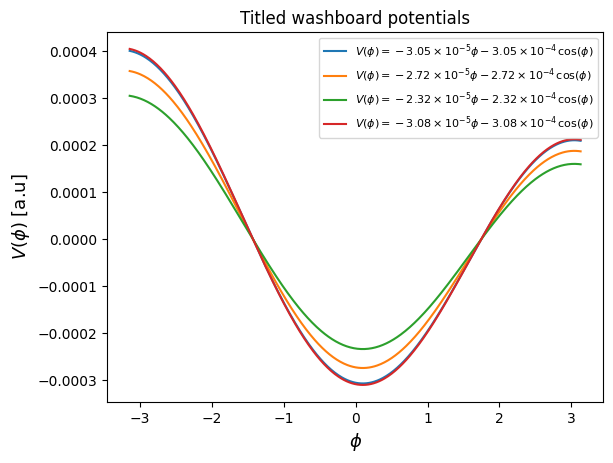

In [23]:
for i, potential in enumerate(V[:4]):
    label = (r"$V(\phi) =" f"-{format_latex(params[i][0])} \phi "
             f"- {format_latex(params[i][1])} \, \cos(\phi)" r"$")
    plt.plot(phi, potential, label=label)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$V(\phi)$ [a.u]')
plt.title('Titled washboard potentials')
plt.legend(
    prop={'size': 8}
);

As for the wavefunctions, we see that the ground state is concentrated at the bottom of the energy well. Because of the randomised parameters, the minimum of the potential is in different paces, and therefore the maxima of the wavefunctions are dispersed.

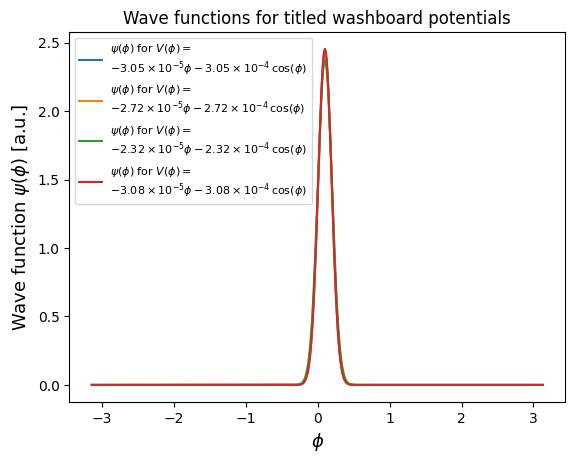

In [24]:
for i, wavefunction in enumerate(waves[:4]):
    label = (r"$\psi(\phi)$ for " "$V(\phi) =$\n$"
             f"-{format_latex(params[i][0])} \phi "
             f"-{format_latex(params[i][1])} \, \cos(\phi)" r"$")
    plt.plot(phi, wavefunction, label=label)
plt.xlabel(r'$\phi$')
plt.ylabel(r'Wave function $\psi(\phi)$ [a.u.]')
plt.title('Wave functions for titled washboard potentials')
plt.legend(
    prop={'size': 8}
);

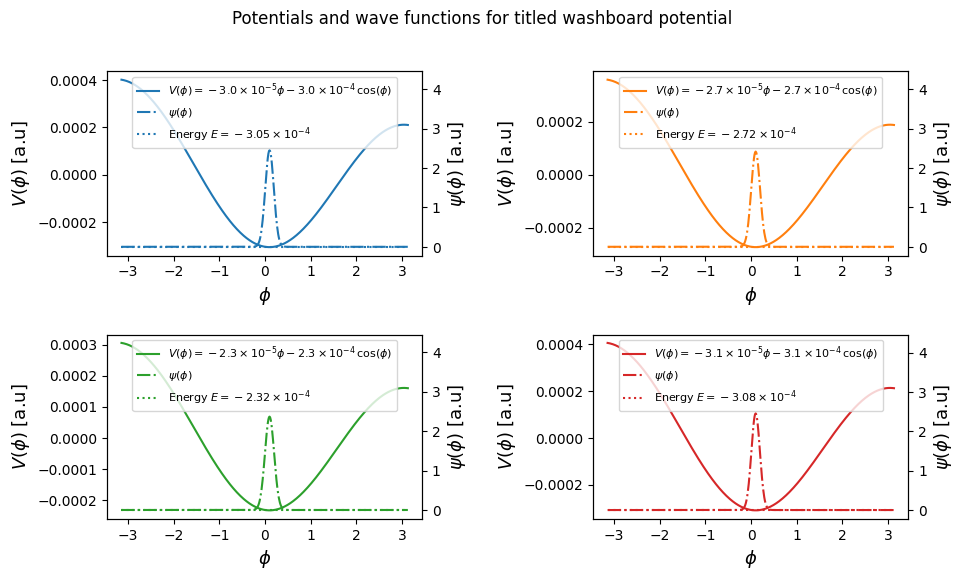

In [25]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle("Potentials and wave functions for titled washboard potential")
colours = list(mcolors.TABLEAU_COLORS)
for i, omega in enumerate(params[:4]):
    Vrange = V[i].max()-V[i].min()
    alpha = Vrange/1.5-np.abs(E[i])
    ax = plt.subplot(2, 2, i+1)
    label_wave = r"$\psi(\phi)$"
    label_V = (r"$V(\phi) =" f"-{format_latex(params[i][0], 1)}\phi "
               f"-{format_latex(params[i][1], 1)} \,\cos(\phi)" r"$")
    label_E = r"Energy $E = " f"{format_latex(E[i])} $"
    ln1 = ax.plot(phi, V[i], '-', color=colours[i], label=label_V)
    ln2 = ax.plot(phi, alpha*waves[i]+E[i], '-.', color=colours[i],
                  label=label_wave)
    ln3 = ax.plot(phi, E[i]*np.ones_like(phi), ':', color=colours[i],
                  label=label_E)
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$V(\phi)$ [a.u]')
    ypmax = (ax.get_ylim()[1]-E[i])/alpha
    ypmin = (ax.get_ylim()[0]-E[i])/alpha
    ax2 = ax.twinx()
    ax2.set_ylim((ypmin, ypmax))
    plt.ylabel('$\psi(\phi)$ [a.u]')
    ax.legend(prop={'size': 8}, loc='upper center')
fig.tight_layout(pad=2.0)

We calculate the energies for lowest laying states for those tilted washboard potentials. Again, we compute the differences of energies $\Delta E_n = E_{n+1} - E_0$ as a function of the excitation level.

In [26]:
Es = []
for n_state in range(10):
    Es.append(data_gen.generate_data(n_state, display=None)[0])
Es = np.array(Es).T
Es

array([[-0.00030511, -0.00030244, -0.00029977, -0.00029711, -0.00029445,
        -0.00029179, -0.00028913, -0.00028648, -0.00028383, -0.00028119],
       [-0.00027234, -0.00026982, -0.0002673 , -0.00026478, -0.00026227,
        -0.00025975, -0.00025725, -0.00025474, -0.00025224, -0.00024974],
       [-0.00023217, -0.00022984, -0.00022751, -0.00022519, -0.00022287,
        -0.00022055, -0.00021824, -0.00021593, -0.00021362, -0.00021131],
       [-0.00030823, -0.00030555, -0.00030287, -0.00030019, -0.00029752,
        -0.00029485, -0.00029218, -0.00028951, -0.00028685, -0.00028419],
       [-0.00029871, -0.00029607, -0.00029343, -0.0002908 , -0.00028816,
        -0.00028553, -0.00028291, -0.00028028, -0.00027766, -0.00027504]])

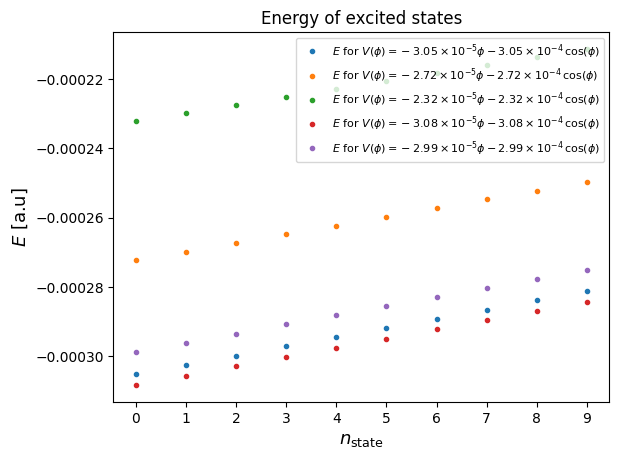

In [27]:
fig, ax = plt.figure(), plt.axes()
colours = list(mcolors.TABLEAU_COLORS)
for i, E in enumerate(Es):
    plt.plot(np.arange(E.shape[0]), E, '.', color=colours[i],
             label=(r"$E$ for $V(\phi) ="
                    f"-{format_latex(params[i][0])} \phi "
                    f"-{format_latex(params[i][1])} \,\cos(\phi)"
                    r"$"))
plt.legend(prop={'size': 8})
plt.xlabel(r'$n_{\text{state}}$')
plt.ylabel('$E$ [a.u]')
plt.title("Energy of excited states")
plt.xticks(np.arange(Es.shape[1]));

One can ask whether we can trust those energies. To make a simple check by returning to the series expansion for the potential

$$ V_\text{phase}(\phi) = - \frac{\Phi_0}{2 \pi} I \phi - E_J + \frac{1}{2} E_J \phi^2 + O(\phi^4) =$$
$$ = \frac{1}{2} E_J \left( \phi - \frac{\Phi_0}{2\pi E_J} I \right)^2 - E_J \left[ 1 + \frac{1}{2} \left( \frac{\Phi_0}{2\pi E_J} I \right)^2 \right] + O(\phi^4) .$$

Using this expansion, we can resact the Hamiltonian in the following form

$$ H_\text{phase} = E_C p_\phi^2 + \frac{1}{2} E_J \left( \phi - \frac{\Phi_0}{2\pi E_J} I \right)^2 - E_J \left[ 1 + \frac{1}{2} \left( \frac{\Phi_0}{2\pi E_J} I \right)^2 \right] + O(\phi^4). $$

If we assume that the higher order contributions are negligable, we can approximate the ground state by the ground state of the harmonic oscillator. Evaluating the Hamiltonian of that state gives the approximate ground energy

$$ E_0 \approx \frac{\hbar\omega_\text{eff}}{2} - E_J \left[ 1 + \frac{1}{2} \left( \frac{\Phi_0}{2\pi E_J} I \right)^2 \right] =$$
$$ = \frac{1}{2} \sqrt{8 E_C E_J} - E_J \left[ 1 + \frac{1}{2} \left( \frac{\Phi_0}{2\pi E_J} I \right)^2 \right] .$$

In [28]:
E0_approx = (omegas.flatten()/2 -
             params[:, 1]*(1+1/2*(params[:, 0]/params[:, 1])**2)
             )
E0_approx

array([-0.0003051 , -0.00027233, -0.00023217, -0.00030823, -0.00029871])

We can calculate the relative error between the ground state energy obtained from the DVR method for the full potential and the above harmonic approximation. As we see, the relative error can be quite small (around $0.002\%$ for default random parameters).

In [29]:
100*np.abs((Es[:, 0].flatten() - E0_approx)/Es[:, 0].flatten())

array([0.00176403, 0.00185812, 0.00200279, 0.00175593, 0.00178104])

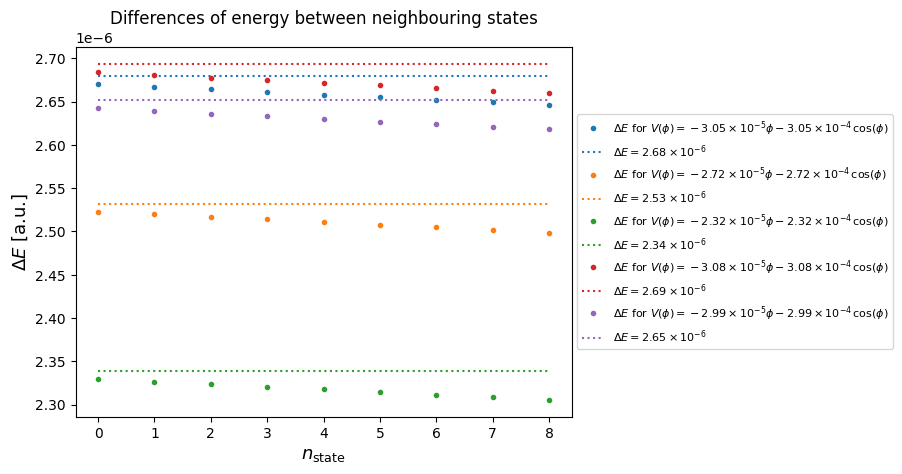

In [30]:
fig, ax = plt.figure(), plt.axes()
colours = list(mcolors.TABLEAU_COLORS)
for i, E in enumerate(np.diff(Es, 1)):
    plt.plot(np.arange(E.shape[0]), E, '.', color=colours[i],
             label=(r"$\Delta E$ for $V(\phi) ="
                    f"-{format_latex(params[i][0])} \phi"
                    f"-{format_latex(params[i][1])} \,\cos(\phi)"
                    r"$"))
    plt.plot(np.arange(E.shape[0]),
             omegas[i][0]*np.ones(E.shape[0]), ':',
             color=colours[i],
             label=f"$\Delta E ={format_latex(omegas[i][0])}$")
plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$n_{\text{state}}$')
plt.ylabel('$\Delta E$ [a.u.]')
plt.title("Differences of energy between neighbouring states")
plt.xticks(np.arange(Es.shape[1]-1));

We see that the difference of energies is manifestly not constant

$$ \Delta E_n \neq \text{const} .$$

In fact, it is monotonically decreasing - and therefore, our system is indeed anharmonic. That is a good news for us, as we can use the transition frequency $\Delta E_0/\hbar$ to induce the transitions between the ground state and the first excited state and be certain that we do not do so for any other state.

The maximum number of 1-qubit operations scales like the modulus of the relative anharmonicity $\alpha_r$

$$ |\alpha_r| = \frac{|\Delta E_1 - \Delta E_0|}{\Delta E_0} .$$

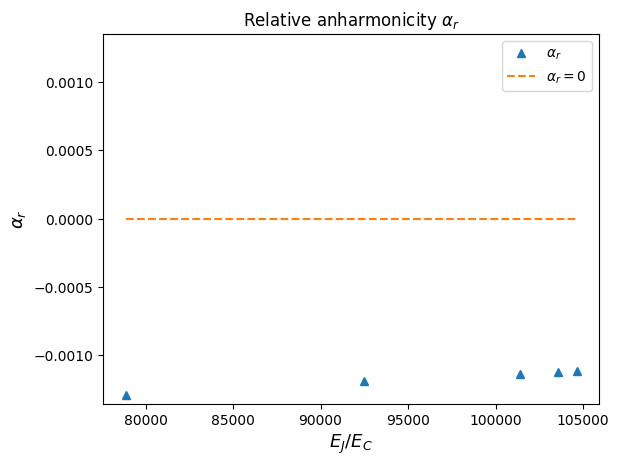

In [31]:
fig, ax = plt.figure(), plt.axes()

plt.plot((params[:, 1]/EC).flatten(),
         ((Es[:, 2] - Es[:, 1]) -
          (Es[:, 1] - Es[:, 0]))/(Es[:, 1] - Es[:, 0]),
         '^',
         label=r"$\alpha_r$")
plt.plot(np.sort((params[:, 1]/EC).flatten()),
         np.zeros_like((params[:, 1]).flatten()), '--',
         label=r"$\alpha_r = 0$")
plt.xlabel(r'$E_J/E_C$')
plt.ylabel(r'$\alpha_r$')
plt.title(r'Relative anharmonicity $\alpha_r$')
plt.ylim((plt.ylim()[0], -plt.ylim()[0]))
plt.legend(prop={'size': 10}, loc='upper right');

We want to also see how the absolute anharmonicity $\alpha$

$$ \alpha = \Delta E_1 - \Delta E_0 ,$$

changes with the parameters used.

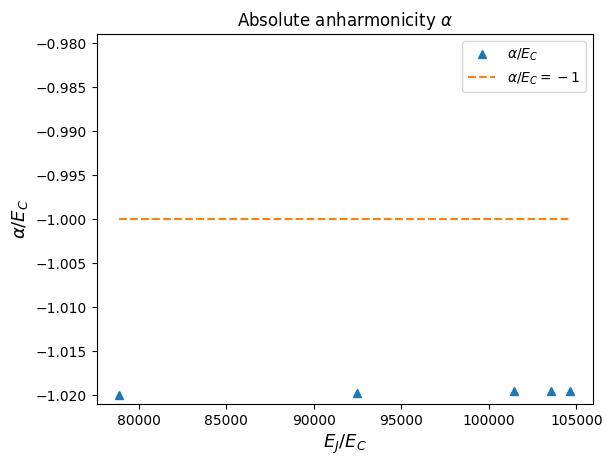

In [32]:
fig, ax = plt.figure(), plt.axes()

plt.plot((params[:, 1]/EC).flatten(),
         ((Es[:, 2] - Es[:, 1]) - (Es[:, 1] - Es[:, 0]))/EC,
         '^',
         label=r"$\alpha/E_C$")
plt.plot(np.sort((params[:, 1]/EC).flatten()),
         -np.ones_like((params[:, 1]).flatten()), '--',
         label=r"$\alpha/E_C = -1$")
plt.xlabel(r'$E_J/E_C$')
plt.ylabel(r'$\alpha/E_C$')
plt.title(r'Absolute anharmonicity $\alpha$')
plt.legend(prop={'size': 10}, loc='upper right')
plt.ylim((plt.ylim()[0], -2-plt.ylim()[0]));

Therefore, in a realistic physical system one needs to take care to chose parameters of the system (whether in the process of manufacturing or tuning the already existing integrated circuit element) to obtain the optimal performance as a qubit model.

## 2. Physical realisations of Josephson junctions

At the present moment, there are various different, competing implementation of qubits from the technological standpoint. One can use the pre-existing physical components like trapped charged or neutral ions; one can use quantum dots; or one can use superconducting integrated circuits.

In this section, we will focus on the last implementation. As one can recall, superconductors are materials which are characterised by a non-zero critical temperature $T_c$ below which a phase transition happens and the material has zero resistivity. At the same time, it is marked by phenomena like the persistence of electric currents inside the superconductor or the Meissner effect, i.e. the expulsion of the magnetic fields from within it.

One distinguished two different types of superconductors:
- low temperature superconductors, when its critical temperature is lower than $30\,K$ and can be described using the BCS theory;
- high temperature superconductors, which critical temperature is higher than $30\,K$.
To be a good material for a qubit implementation, superconductor should have a critical temperature larger than $1\,K$ and an operating temperature around $20\,mK$ [\[1\]](#Bibliography), which allows for the operation to be not affected by the thermal noise and therefore decoherence.

Using superconducting elements, one can manufacture a non-dissipative and non-linear (i.e. anharmonic) integrated circuit element called the *Josephson junction*. They can be considered as *artificial atoms*.

| ![Josephson junction](./assets/images/JJ.png "Josephson junction") |
|:--:| 
| *Josephson junction* |

An isolated Josephson junction is composed of two superconductucting films separated by a layer of insulator which is thin enough so that tunnelling of Cooper pairs (i.e. a bosonic states composed of a pair of electrons) from one superconducting electrode to the other though the insulator is still allowed. In therms of manufacturing, one uses the technique of nanolithography to create a superconducting electrode from aluminium, then oxidise it to obtain a layer of insulating aluminium oxide of the width of $1\,nm$ and finally apply another superconducting electrode [\[1, 3\]](#Bibliography).

| ![(Irreducible) Josephson junction symbol](./assets/images/JJ_symbol.png "(Irreducible) Josephson junction symbol") |
|:--:| 
| *(Irreducible) Josephson junction symbol* |

Let us now discuss how to describe this type of junction. The state of the superconductor is determined by the number of Cooper pairs within it (or, alternatively, their electric charge, which is equal to the number of the Cooper pairs multiplied by two times charge of the electron). We can describe the junction just by the number of Cooper pair on one of the sides, as a pair can only move from one electrode to another through the process of tunnelling. Therefore, we can define an orthogonal basis $\{|N\rangle\}_{N\in\mathbb{Z}}$ on which the number operator $\hat n$ of the Cooper pairs acts diagonally (we assume that the possible amount of Cooper pairs is so large that we can approximate it to be unbounded)

$${\hat n} |N\rangle = N |N\rangle .$$

To completely describe the system, we also need a conjugate variable to $\hat N$. In the case of Josephson junction this role plays the Josephson phase $\hat \phi$ across the junction, which canonically commutes with the number operator

$$ [{\hat \phi}, {\hat n}] = -i .$$

For $\phi$ we can define a dual basis using the Fourier transforms

$$ |\phi\rangle = \sum_{N=-\infty}^{\infty} e^{iN\phi}|N\rangle ,$$

$$ |N\rangle = \frac{1}{2\pi} \int_0^{2\pi} \text{d} \phi e^{-iN\phi} |\phi\rangle .$$

As one can remember from quantum mechanics, the exponential of the operator $\hat\phi$ conjugate to $\hat n$ is unitary and generates translations in $\hat n$ 

$$ e^{i \alpha {\hat \phi}} |N\rangle = |N - \alpha \rangle .$$

Therefore, we can describe the act of tunnelling of a Cooper pair from one electrode to another using the following operator

$$ e^{i {\hat \phi}} = \sum_{n\in\mathbb{Z}} |N-1\rangle\langle N| ,$$

while the tunnelling in the opposite direction is given by the unitary operator like below

$$ e^{-i {\hat \phi}} = \sum_{n\in\mathbb{Z}} |N+1\rangle\langle N| .$$

Putting those two terms together, we obtain that the tunnelling part of the Hamiltonian of the Josephson junction is given by

$$ H_J = -\frac{E_J}{2} \sum_{n\in\mathbb{Z}} |N-1\rangle\langle N| + |N+1\rangle\langle N| ,$$

in the number operator $\hat N$ basis or equivalently by

$$ H_J = -E_J \cos{\hat \phi} .$$

However, the tunnelling term $H_J$ is not the only one that is present in the Hamiltonian describing Josephson junction. As we mentioned, the junction is essentially just 2 pieces of superconductor separated by an insulator. As such, it will also behave in a way similar to a capacitor (which is nothing else than 2 pieces of ordinary conductor separated by an insulator). Therefore, alongside the the tunnelling term, the full Hamiltonian of the Josephson junction will also have a capacitance term

$$ H_C = 4 E_C {\hat n}^2 ,$$

where $ E_C = \frac{e^2}{2 C_J} $ is the junction charging energy. The number operator $\hat n$ is connected to the charge operator $\hat Q$ by $\hat n = -\frac{1}{2e} \hat Q$. The total Hamiltonian thus looks as follows

$$ H = 4 E_C {\hat n}^2 - E_J \cos{\hat \phi} .$$

| ![Isolated Josephson junction](./assets/images/isolated_JJ.png "Isolated Josephson junction") |
|:--:| 
| *Left: Isolated Josephson junction. Right: Symbolic representation of this circuit* |

On the figure we present the diagram of an isolated Josephson junction, i.e. a Josephson junction with a tunnelling energy $E_J$ and a capacitance $C_J$. In practical terms, realistic Josephson junctions are always represented as a pure tunnelling elements and pure capacitor connected in parallel. On the right, we present an electric diagram symbol for this type of junction, which is given by a box with a cross in the middle [\[1\]](#Bibliography). It is important to note however that in the literature the box with a cross and the cross (representing just the tunnelling term) are used alternately (even within the same paper!), so the reader is advised some caution.

We can connect the element above to the outside world and obtain so-called *Cooper-pair box*. In that case one side of the junction is connects to a small island of superconducting material, while the other connects to a superconducting reservoir (i.e. the ground) - the small size of the superconducting island ensures than changing the number of Cooper pairs even by one significantly influences the system. 

| ![Isolated Cooper-pair box](./assets/images/isolated_cooper_pair_box.png "Isolated Cooper-pair box") |
|:--:| 
| *Isolated Cooper-pair box* |

If one attaches an ammeter around the Josephson juction, one will be able to measure a constant current through the junction. That is because one can calculate current operator as a change of the number of charge carriers

$$ {\hat I} = 2e \frac{\text{d} \hat n}{\text{d}t} = 2e \frac{i}{\hbar} [H, \hat n] = -\frac{2e E_J}{\hbar} i [\cos\hat\phi, \hat n] ,$$

given the fact that the time evolution is given by the unitary transformation

$$ \hat n(t) = e^{iHt/\hbar} \hat n(0) e^{-iHt/\hbar} .$$

By calculating the commutator we get that

$$ [\cos\hat\phi, \hat n] = \frac{1}{2} \sum_{N\in\mathbb{Z}} |N-1\rangle\langle N| - |N+1\rangle\langle N| = i\sin\hat\phi ,$$

which gives at the end

$$ {\hat I} = I_0 \sin\hat \phi, $$

where $I_0 = \frac{2 e E_J}{\hbar}$. This is the co-called *DC Josephson effect* [\[10\]](#Bibliography), first described by Josephson in [\[5\]](#Bibliography).

| ![DC Josephson effect](./assets/images/dc_josephson_effect.png "DC Josephson effect") |
|:--:| 
| *DC Josephson effect* |


With that, we can discuss how Josephson junction described above can be used to construct an electric element which realises a qubit. We actually already encountered a Hamiltonian describing such system in the [section 1.2](#1.2.-Anharmonic-potentials) - the system given by that Hamiltonian, which we rephrase currently as

$$ H = 4 E_C {\hat n}^2 - \frac{\Phi_0}{2\pi} I {\hat \phi} - E_J \cos{\hat \phi} ,$$

where $ \Phi_0 = \frac{h}{2e} $, is known under a name of a *phased qubit* or, alternatively, a *current-biased Josephson junction*.

| ![Phased qubit](./assets/images/phased_qubit.png "Phased qubit") |
|:--:| 
| *Phased qubit / Current-biased Josephson junction* |

That is because the Josephson junction is connected to a current source with a current $I$, which contributes an additional, linear in $\phi$, term. As we discussed before, the minimum of the potential is achieved for 

$$ \phi = \arcsin\left( \frac{\Phi_0}{2\pi E_J} I \right) ,$$

which can be straightforwardly inverted to be

$$ I = I_0 \cos(\phi) ,$$

where $ I_0 = \frac{2e E_J}{\hbar} $.

| ![Voltage-biased Josephson junction](./assets/images/charge_qubit.png "Voltage-biased Josephson junction") |
|:--:| 
| *Voltage-biased Josephson junction* |

Finally, we want to describe the main object of study for this section: the *voltage-biased Josephson junction* (which belongs to the category of the so-called *charge qubits*). The voltage-biased Josephson junction is obtained from a Josephson junction by first serially connecting the Josephson junction to a capacitor with the capacitance $C_g$ and then connecting it to a voltage source $V_g$. Connecting the capacitor just changes the junction charging energy

$$ E_C = \frac{e^2}{2(C_g+C_J)} .$$

Because of the influence of non-zero voltage, the charge coordinate is shifted $ Q = (C_J+C_g) {\dot \Phi} - C_g V_g $ and a charge $Q_g = C_g V_g$ (or, equivalently, an occupation $ n_g = \frac{Q_g}{2e} $) is induced on the electrode on the side of the capacitor $C_g$ which is attached to the superconducting island. All of this shifts the reference point in the charging energy part of the Hamiltonian, giving the following expression

$$ H_\text{CPB} = 4 E_C \big(\hat n - n_g\big)^2 - E_J \cos\hat\phi .$$

Experimentally, the voltage-biased single Cooper-pair box has been realised for the first time by V. Bouchiat, D. Vion, P. Joyez, D. Esteve and M.H. Devoret at SPEC in CEA, Saclay [\[9\]](#Bibliography).

There exist many more disparate realisation of qubits that use Josephson junctions, most importantly the flux qubit (though there is a veritable zoo of more exotic ones) - however, their description and numerical treatment is outside of the purview of this notebook - we invite the interested reader to consult the referenced reviews and papers.

| ![Parameter space for selected qubits](./assets/images/parameter_space.png "Parameter space for selected qubits") |
|:--:| 
| *Parameter space for selected qubits* |

The various regimes in the parameter space of qubits that we consider can be found in the following sections:
- Voltage-biased Cooper-pair box - [section 2.1](2.1.-Voltage-biased-Cooper-pair-box);
- Transmon qubit - [section 2.2](2.2.-Transmon-Qubit);
- Phase qubit - [section 1.2](#1.2.-Anharmonic-potentials).

### 2.1. Voltage-biased Cooper-pair box

We already described the basic properties of the voltage-biased single Cooper-pair box in the [section 2](#2.-Physical-realisations-of-Josephson-junctions). Now we will focus on using numerics to simulate a this Josephson junction circuit as a quantum mechanical system.

For voltage-biased Cooper-pair box, the coupling parameters (the junction charging energy and the tunnelling energy) should be in the regime $E_C \gg E_J$. That allows for the number operator $\hat n$ to have well-defined values. In fact, the Hamiltonian can be written in the number operator basis as follows

$$ H_\text{CPB} = \sum_{n\in\mathbb{Z}} \left[ 4 E_C \big(n - n_g\big)^2 |n\rangle \langle n| - \frac{1}{2} E_J \big( |n+1\rangle \langle n| + |n-1\rangle \langle n| \big) \right] .$$

In order to tackle the problem numerically, we need to transform the Hilbert space of our theory, which is infinite-dimensional, to an unitary space which is finite. We will do that be considering only a finite number of states around the $n=n_g$ value of the number operator.

We will be concerned with the following parameters:

 - `N`: the dimension of the unitary space $\mathcal{H}=\mathbb{C}^N$ of our model;
 - `EC`: the junction charging energy $E_C$;
 - `EJ`: the Josephson tunnelling energy $E_J$;
 - `ng`: the number operator offset $n_g$;
 - `n`: the value of the number operator for the vector `v(N, n)`.

In [33]:
def hamiltonian_charge(N: int, EC: float, EJ: float, ng: float
                       ) -> np.ndarray[Any, np.dtype[np.float64]]:
    r'''
    Returns a Hamiltonian of the voltage-biased Cooper-pair box
    in the number operator basis, given its parameters.

    Parameters
    ----------
    N : int
        Dimension of the unitary space.
    EC : float
        Value of the juction charging energy $E_C$.
    EJ : float
        Value of the tunnelling energy $E_J$.
    ng : float
        An occupation number offset $n_g$ from the biasing
        voltage.

    Returns
    -------
    H : np.ndarray[Any, np.dtype[np.float64]]
        (N x N) array; the Hamiltonian of the system.

    Examples
    --------
    >>> hamiltonian_charge(3, 1, 1/2, 1/4)
    array([[ 6.25, -0.25,  0.  ],
           [-0.25,  0.25, -0.25],
           [ 0.  , -0.25,  2.25]])
    '''

    diag = 4*EC*(np.diag(np.arange(N)-(N-1)//2)
                 - ng*np.identity(N))**2

    offdiag = np.zeros((N, N))
    for i in range(1, N-1):
        offdiag[i-1, i] = 1
        offdiag[i+1, i] = 1
    offdiag[1, 0] = 1
    offdiag[N-2, N-1] = 1

    offdiag = -1/2*EJ*offdiag
    H: np.ndarray[Any, np.dtype[np.float64]] = diag + offdiag

    return H


def v(N: int, n: int) -> np.ndarray[Any, np.dtype[np.float64]]:
    r'''
    Returns a number operator eigenvector to the eigenvalue
    n.

    Parameters
    ----------
    N : int
        Dimension of the unitary space.
    n : int
        The eigenvalue of the number operator.

    Returns
    -------
    v : np.ndarray[Any, np.dtype[np.float64]]
        (N) array; a unit vector.

    Examples
    --------
    >>> v(3,0)
    array([0., 1., 0.])
    '''
    if n < -(N//2)-(N % 2-1) or n > N//2:
        raise Exception(("The parameter n is out of bounds. "
                         "The range of n is "
                         f"[{-(N//2)-(N%2-1)}, {N//2}]"))
    v = np.zeros(N)
    v[-(-(N//2)-(N % 2-1))+n] = 1
    return v

The voltage-biased Josephson junction system has actually two operating regimes depending on the value of the parameter $n_g$:
- $n_g=n$:

  The system has an unique ground state. It is used for state preparation before commencing any quantum calculations;
- $n_g=n+1/2$:

  The states are doubly degenerate. It is a good qubit system with clearly separated two-dimensional subspace $\mathbb{C}^{2}$ composed of the ground state and the first excited state, and it is used to perform calculations. 

#### 2.1.1. $E_J=0$ case (no tunnelling)

Let us first consider the case when the tunnelling energy is zero. 

| ![Circuit without tunnelling](./assets/images/no_tunnelling.png "Circuit without tunnelling") |
|:--:| 
| *Circuit without tunnelling* |

Then, the charging energy term is the entirety of the Hamiltonian, and the eigenstates of the number operator are simultaneously also the eigenstate of the Hamiltonian. 

In [34]:
N = 8
EC = 3*10**(-9)
EJ = 0
ng = 1/2

H = hamiltonian_charge(N, EC, EJ, ng)

The effective capacity $C_\Sigma = C_J + C_g$ of this junction is given by

$$ C_\Sigma = \frac{e^2}{2 E_C} . $$

In atomic units that is

In [35]:
C = 1/2/EC
C

166666666.66666666

while in farads it is

In [36]:
C*(echarge**2/hartree)

9.813150884195398e-13

In [37]:
with np.printoptions(precision=1, suppress=False):
    print(H)

[[1.5e-07 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 7.5e-08 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 2.7e-08 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 3.0e-09 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 3.0e-09 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 2.7e-08 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 7.5e-08 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.5e-07]]


We see that for for $n_g=\frac{1}{2}$ all the states are doubly degenerate. Moreover, we have 2 states with the lowest energy:

In [38]:
H @ v(N, 0)

array([0.e+00, 0.e+00, 0.e+00, 3.e-09, 0.e+00, 0.e+00, 0.e+00, 0.e+00])

In [39]:
H @ v(N, 1)

array([0.e+00, 0.e+00, 0.e+00, 0.e+00, 3.e-09, 0.e+00, 0.e+00, 0.e+00])

which constitute a two dimensional subspace $\mathbb{C}^2$ that is suitable to be a qubit model. It is apparent that the energy gap between the next excited states is 9 times larger than the ground energy, allowing for a good separation.

In [40]:
H[(N-1)//2:(N-1)//2+2, (N-1)//2:(N-1)//2+2]

array([[3.e-09, 0.e+00],
       [0.e+00, 3.e-09]])

One can confirm that the values of energy are indeed doubly degenerate by diagonalising the Hamiltonian explicitly

In [41]:
np.linalg.eigvalsh(hamiltonian_charge(N, EC, EJ, ng))

array([3.00e-09, 3.00e-09, 2.70e-08, 2.70e-08, 7.50e-08, 7.50e-08,
       1.47e-07, 1.47e-07])

For the offset $n_g\neq1/2$, the energy levels cease to be doubly degenerate. We can illustrate it on the following example as below:

In [42]:
H = hamiltonian_charge(N, EC, EJ, ng+0.2)

In [43]:
with np.printoptions(precision=1, suppress=False):
    print(H)

[[1.6e-07 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 8.7e-08 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 3.5e-08 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 5.9e-09 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.1e-09 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 2.0e-08 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 6.3e-08 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.3e-07]]


We see that while the eigenvectors of the number operator as still the eigenvectors of the Hamiltonian, the energy degeneracy has been lifted. We still have 2 lowest laying states however:

In [44]:
H @ v(N, 0)

array([0.00e+00, 0.00e+00, 0.00e+00, 5.88e-09, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00])

In [45]:
H @ v(N, 1)

array([0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.08e-09, 0.00e+00,
       0.00e+00, 0.00e+00])

as well as a two-dimensional subspace $\mathbb{C}^2$

In [46]:
H[(N-1)//2:(N-1)//2+2, (N-1)//2:(N-1)//2+2]

array([[5.88e-09, 0.00e+00],
       [0.00e+00, 1.08e-09]])

Again, we can check that the vectors are eigenvectors of the Hamiltonian by explicit diagonalisation

In [47]:
np.linalg.eigvalsh(hamiltonian_charge(N, EC, EJ, ng+0.2))

array([1.0800e-09, 5.8800e-09, 2.0280e-08, 3.4680e-08, 6.3480e-08,
       8.7480e-08, 1.3068e-07, 1.6428e-07])

In fact, we can graph the energies of the lowest laying states as a function of the parameter $n_g$.

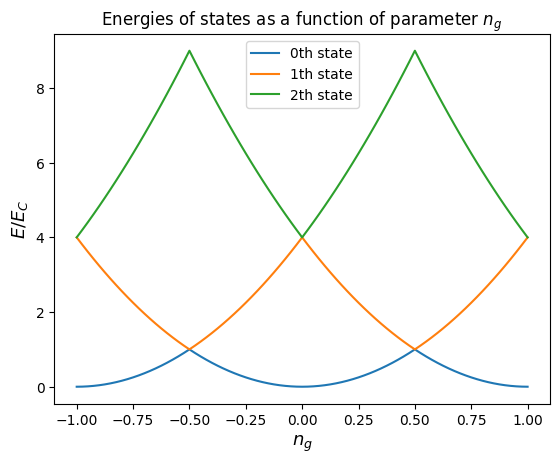

In [48]:
fig, ax = plt.figure(), plt.axes()
energies = np.array([np.linalg.eigvalsh(hamiltonian_charge(N, EC,
                                                           EJ, i))[:3]
                     for i in np.linspace(-1, 1, 81)])
for j in range(3):
    plt.plot(np.linspace(-1, 1, 81), energies[:, j]/EC,
             label=f"{j}th state")
plt.xlabel('$n_g$')
plt.ylabel('$E/E_C$')
plt.legend()
plt.title('Energies of states as a function of parameter $n_g$');

As we can see, the system is periodic in $n_g$ with a period of $1$, as one would expect from the form of the Hamiltonian. Moreover, for the value of $n_g=1/2$ we have a two-fold degeneracy for the lowest laying energy state, while for $n_g=0$ the ground state is unique, while the first and second excited state have the same energy and are well separated from the ground state.

#### 2.1.2. $E_C \gg E_J$ case

After considering the case when the tunnelling does not happen (i.e. the system behaves like a pure capacitor), we can turn to the case when the tunnelling term is small, but present.

In [49]:
N = 8
EC = 3*10**(-9)
EJ = 0.1*EC
ng = 1/2

H = hamiltonian_charge(N, EC, EJ, ng)

The effective capacity $C_\Sigma = C_J + C_g$ of this junction is given by

$$ C_\Sigma = \frac{e^2}{2 E_C} . $$

In atomic units it is

In [50]:
C = 1/2/EC
C

166666666.66666666

while in farads it is

In [51]:
C*(echarge**2/hartree)

9.813150884195398e-13

In [52]:
with np.printoptions(precision=1, suppress=False):
    print(H)

[[ 1.5e-07 -1.5e-10  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [-1.5e-10  7.5e-08 -1.5e-10  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [ 0.0e+00 -1.5e-10  2.7e-08 -1.5e-10  0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [ 0.0e+00  0.0e+00 -1.5e-10  3.0e-09 -1.5e-10  0.0e+00  0.0e+00  0.0e+00]
 [ 0.0e+00  0.0e+00  0.0e+00 -1.5e-10  3.0e-09 -1.5e-10  0.0e+00  0.0e+00]
 [ 0.0e+00  0.0e+00  0.0e+00  0.0e+00 -1.5e-10  2.7e-08 -1.5e-10  0.0e+00]
 [ 0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00 -1.5e-10  7.5e-08 -1.5e-10]
 [ 0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00 -1.5e-10  1.5e-07]]


The Hamiltonian is not diagonal any more, but has small, but non-zero off-diagonal components. Because of that the eigenvectors of the number operator are not the eigenvectors of the Hamiltonian anymore - though they still can approximate the genuine eigenvectors.

In [53]:
H @ v(N, 0)

array([ 0.0e+00,  0.0e+00, -1.5e-10,  3.0e-09, -1.5e-10,  0.0e+00,
        0.0e+00,  0.0e+00])

In [54]:
H @ v(N, 1)

array([ 0.0e+00,  0.0e+00,  0.0e+00, -1.5e-10,  3.0e-09, -1.5e-10,
        0.0e+00,  0.0e+00])

In particular, we can still take the lowest energy subspace, on which the Hamiltonian is a $(2\times2)$ matrix with small off-diagonal elements

In [55]:
H[(N-1)//2:(N-1)//2+2, (N-1)//2:(N-1)//2+2]

array([[ 3.0e-09, -1.5e-10],
       [-1.5e-10,  3.0e-09]])

What happens to the energies? After diagonalising the Hamiltonian we see that in the case $n_g=1/2$ the double degeneracy of the energy levels has been split:
- the difference of energies between the ground state and the first excited state is of the order of $\approx E_J$;
- the difference of energies that splits higher laying states is a higher power of $E_J$.

In [56]:
np.linalg.eigvalsh(hamiltonian_charge(N, EC, EJ, ng))

array([2.84906835e-09, 3.14905663e-09, 2.70004629e-08, 2.70004746e-08,
       7.50001563e-08, 7.50001563e-08, 1.47000312e-07, 1.47000312e-07])

We can also perform similar analysis for a point away from $n_g=1/2$. Let us just comment that the situation in this region does not look drastically different to that from [section 2.1.1](#2.1.1.-$E_J=0$-case) - it is clear that the influence of the tunnelling term is the most significant in the region of $n_g=1/2$.

In [57]:
H = hamiltonian_charge(N, EC, EJ, ng+0.2)

In [58]:
with np.printoptions(precision=1, suppress=False):
    print(H)

[[ 1.6e-07 -1.5e-10  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [-1.5e-10  8.7e-08 -1.5e-10  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [ 0.0e+00 -1.5e-10  3.5e-08 -1.5e-10  0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [ 0.0e+00  0.0e+00 -1.5e-10  5.9e-09 -1.5e-10  0.0e+00  0.0e+00  0.0e+00]
 [ 0.0e+00  0.0e+00  0.0e+00 -1.5e-10  1.1e-09 -1.5e-10  0.0e+00  0.0e+00]
 [ 0.0e+00  0.0e+00  0.0e+00  0.0e+00 -1.5e-10  2.0e-08 -1.5e-10  0.0e+00]
 [ 0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00 -1.5e-10  6.3e-08 -1.5e-10]
 [ 0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00 -1.5e-10  1.3e-07]]


In [59]:
H @ v(N, 0)

array([ 0.00e+00,  0.00e+00, -1.50e-10,  5.88e-09, -1.50e-10,  0.00e+00,
        0.00e+00,  0.00e+00])

In [60]:
H @ v(N, 1)

array([ 0.00e+00,  0.00e+00,  0.00e+00, -1.50e-10,  1.08e-09, -1.50e-10,
        0.00e+00,  0.00e+00])

In [61]:
H[(N-1)//2:(N-1)//2+2, (N-1)//2:(N-1)//2+2]

array([[ 5.88e-09, -1.50e-10],
       [-1.50e-10,  1.08e-09]])

In [62]:
np.linalg.eigvalsh(hamiltonian_charge(N, EC, EJ, ng+0.2))

array([1.07414602e-09, 5.88390081e-09, 2.02806511e-08, 3.46803551e-08,
       6.34801860e-08, 8.74801332e-08, 1.30680335e-07, 1.64280293e-07])

We can graph the energies of the lowest laying states as a function of the parameter $n_g$ like we did before.

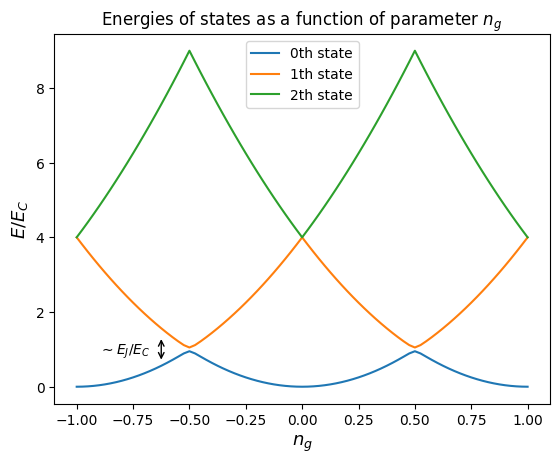

In [63]:
fig, ax = plt.figure(), plt.axes()
energies = np.array([np.linalg.eigvalsh(hamiltonian_charge(N, EC,
                                                           EJ, i))[:3]
                     for i in np.linspace(-1, 1, 81)])
for j in range(3):
    plt.plot(np.linspace(-1, 1, 81), energies[:, j]/EC,
             label=f"{j}th state")
plt.xlabel('$n_g$')
plt.ylabel('$E/E_C$')
plt.legend()
plt.title('Energies of states as a function of parameter $n_g$')
e_diff = energies[20, 1] - energies[20, 0]
plt.annotate(text='', xy=(-0.625,
                          (energies[20, 0]-3*e_diff)/EC),
             xytext=(-0.625,
                     (energies[20, 1]+3*e_diff)/EC),
             arrowprops=dict(arrowstyle='<->'))
plt.text(-0.9,
         (energies[20, 0]+energies[20, 0])/2/EC,
         '$\sim E_J/E_C$',
         va='center');

The graph looks very much similar to the one from [section 2.1.1](#2.1.1.-$E_J=0$-case), with one significant difference - the energy degeneracies that we present previously has been lifted because of the non-zero tunnelling term. This is visible on the graph only in the case of the ground state and the first excited state (because of the limited resolution), but is in fact valid for all of the points where energy curves cross each other. The ground state and the first excited state at $n_g = \frac{1}{2}$ has been separated by $E_J$.

#### 2.1.3. $E_C \approx E_J$ case

Finally, we can consider the case when the tunnelling energy $E_J$ is not small, but comparable to or larger than the junction charging energy $E_C$. For some selected values of $E_J/E_C$ we can observe how the energy levels evolve with changing coupling parameters.

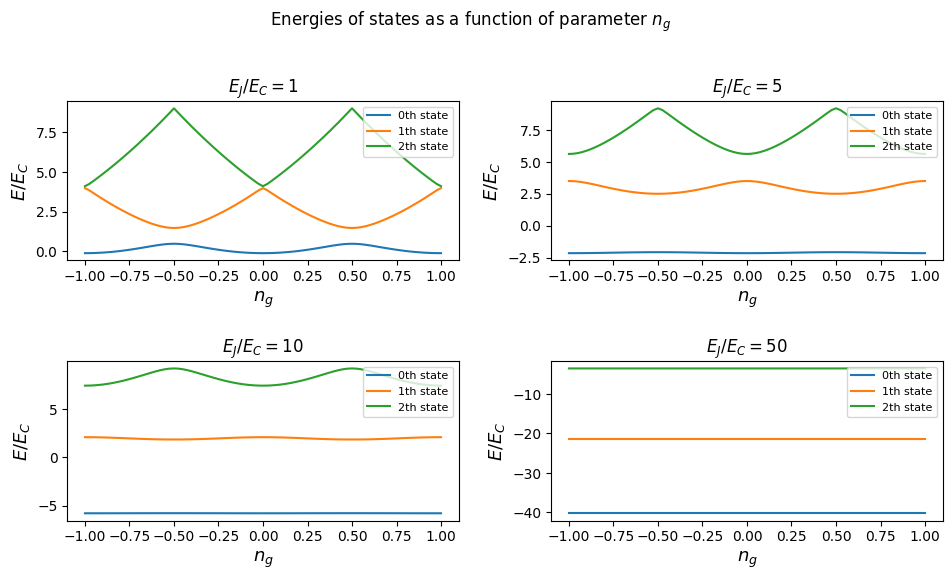

In [64]:
N = 20
fig = plt.figure(figsize=(10, 6))
params = np.array(
    [[EC, EC], [EC, 5*EC], [EC, 10*EC], [EC, 50*EC]], dtype=float)
for i, param in enumerate(params):
    energies = np.array([np.linalg.eigvalsh(
        hamiltonian_charge(N, param[0], param[1], i))[:3]
        for i in np.linspace(-1, 1, 81)])
    plt.subplot(2, 2, i+1)
    for j in range(3):
        plt.plot(np.linspace(-1, 1, 81), energies[:, j]/EC,
                 label=f"{j}th state")
    plt.xlabel('$n_g$')
    plt.ylabel('$E/E_C$')
    plt.legend(prop={'size': 8}, loc='upper right')
    plt.title(f"$E_J/E_C={param[1]/param[0]:0.0f}$")
plt.suptitle('Energies of states as a function of parameter $n_g$')
fig.tight_layout(pad=2.0)

We see that while for small $E_J$ the tunnelling terms lifted the degeneracy of the energy levels, with larger and larger $E_J/E_C$ the distances between energy levels become more and more pronounced. Moreover, the system loses the dependence on the parameter $n_g$ - in the regime $E_J \gg E_C$ the system becomes almost completely independent of the choe of $n_g$.

One can study this behaviour more closely. In particular, we can study how absolute anharmonicity $\alpha$

$$\alpha = \Delta E_1 - \Delta E_0 ,$$

changes as a function of the parameter $E_J/E_C$. 

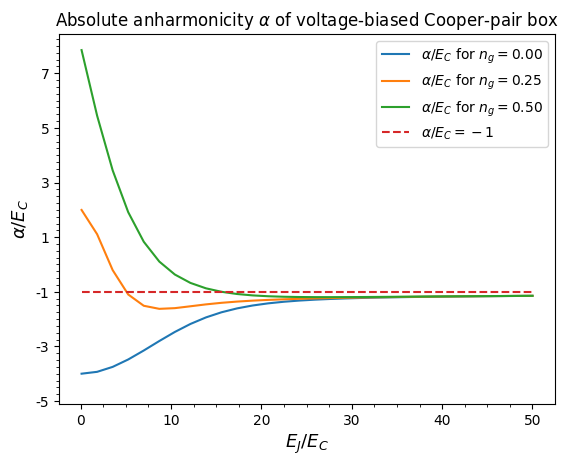

In [65]:
N = 25
EC = 1
params = np.linspace(0.1, 50, 30)
fig, ax = plt.figure(), plt.axes()
for ng in np.array([0, 1/4, 1/2]):
    energies = np.array([np.linalg.eigvalsh(
        hamiltonian_charge(N, EC, param, ng)) for param in params])
    plt.plot(params/EC,
             ((energies[:, 2] - energies[:, 1]) -
              (energies[:, 1] - energies[:, 0]))/EC,
             label=r"$\alpha/E_C$ for " f"$n_g = {ng:0.2f}$")
plt.plot(params, -np.ones_like(params), '--',
         label=r"$\alpha/E_C = -1$")
plt.xlabel(r'$E_J/E_C$')
plt.ylabel(r'$\alpha/E_C$')
plt.title(r'Absolute anharmonicity $\alpha$ of voltage-biased Cooper-pair box')
plt.ylim((ax.get_ylim()[0]-1/2, ax.get_ylim()[1]))

ax.yaxis.set_major_locator(MultipleLocator(2, 1))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(2.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

plt.legend();

We can notice that, in the case of $n_g=1/2$, for $E_J/E_C < 9$ the voltage-biased Josephson junction spectrum admits positive anharmonicity. Near $E_J/E_C = 9$ the first two transition frequencies are too close together for the voltage-biased Josephson junction to be used as a qubit. Outside of that region, for $E_J/E_C > 9$ the anharmonicity becomes negative and and asymptotically approaches the charging energy $\alpha \to -E_C$ [\[6\]](#Bibliography).

While the asymptotic behaviour of anharmonicity stays valid for different values of $n_g$, it is clear from the above calculation that the voltage-biased Cooper-pair box is very sensitive to small fluctuation of the gate voltage $V_g$ (or, alternatively, of the offset $n_g$). The qubit operating region around $n_g=1/2$ is very sensitive to noise.

Because of that, from the engineering standpoint many researcher prefer to trade large anharmonicity and large charge noise in the $E_J/E_C \ll 1$ region for relatively weak ($\alpha_r \sim 5-10\%$) anharmonicity and small charge noise in the $E_J/E_C \gg 1$ region. The voltage-biased Cooper-pair box implementation which operates in that region of parameter space has been dubbed the *transmon qubit* [\[8\]](#Bibliography) and will be the subject of the [next section](#2.2.-Transmon-Qubit).

Alternatively, we can calculate the relative anharmonicity $\alpha_r$ in place of the absolute anharmonicity

$$ \alpha_r = \frac{\Delta E_1 - \Delta E_0}{\Delta E_0} .$$

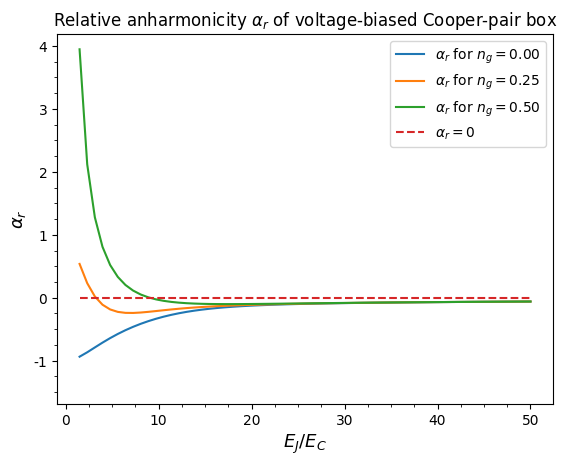

In [66]:
N = 25
EC = 1
params = np.linspace(1.5, 50, 60)
fig, ax = plt.figure(), plt.axes()
for ng in np.array([0, 1/4, 1/2]):
    energies = np.array([np.linalg.eigvalsh(
        hamiltonian_charge(N, EC, param, ng)) for param in params])
    plt.plot(params/EC,
             ((energies[:, 2] - energies[:, 1]) -
              (energies[:, 1] - energies[:, 0]))/(energies[:, 1] -
                                                  energies[:, 0]),
             label=r"$\alpha_r$ for " f"$n_g = {ng:0.2f}$")
plt.plot(params, np.zeros_like(params), '--',
         label=r"$\alpha_r = 0$")
plt.xlabel(r'$E_J/E_C$')
plt.ylabel(r'$\alpha_r$')
plt.title((r'Relative anharmonicity $\alpha_r$ of '
           r'voltage-biased Cooper-pair box'))
plt.ylim((ax.get_ylim()[0]-1/2, ax.get_ylim()[1]))

ax.yaxis.set_major_locator(MultipleLocator(1, 0))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(2.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

plt.legend();

### 2.2. Transmon Qubit

In the [previous section](#2.1.-Voltage-biased-Cooper-pair-box) we discussed the behaviour of the voltage-biased Josephson junction in the range of parameters outside of $E_J \gg E_C$. One can ask what happens in that regime.

Because of the engineering and fabrication reasons one needs to slightly modify the integrated circuit for the qubit system to achieve the regime $E_J \gg E_C$. The easiest is to find a way to lower the charging energy $E_C$ - as we remember, the charging energy is inversely proportional to the sum of capacitances already present on our circuit

$$ E_C = \frac{e^2}{2(C_J + C_g)} .$$

To make this sum larger (and, therefore, to make the energy $E_C$ smaller) one can connect another capacitor. While the manufacturing implementation of this single Cooper-pair box shunted by a large shunting capacitance $C_B$ differs slightly from the voltage-biased Cooper-pair box, it is still described by the same Hamiltonian, only in different regime of parameter values [\[8\]](#Bibliography), where the charging energy is given by

$$ E_C = \frac{e^2}{2(C_J + C_g + C_B)} .$$

On the other hand, one can also replace the Josephson junction by the so-called *SQUID*, which is a pair of connected Josephson junctions. A single Josephson junction has parameters fixed at the fabrication stage, while SQUID can be dynamically tuned and its $E_J/E_C$ ratio can be adjusted using the external magnetic flux flowing through the SQUID loop. For a SQUID component composed of 2 Josephson junctions with tunnelling energies $E_{J,1}$, $E_{J,2}$ and an external magnetic field $\tilde \Phi$ the effective tunnelling energy has the form

$$ E_{J, \text{SQUID}} = (E_{J,1} + E_{J,2}) \cos \left( \frac{\pi \tilde\Phi}{\Phi_0} \right) \sqrt{1 + \frac{E_{J,2} - E_{J,1}}{E_{J,2} + E_{J,1}} \tan^2 \left( \frac{\pi \tilde\Phi}{\Phi_0} \right)} .$$

As one sees, one can either lower the charging energy $E_C$ or manipulate the tunnelling energy $E_J$.

Because of those manufacturing differences, the integrated circuit subjected to the voltage-biased Cooper-pair box Hamiltonian in $E_J \gg E_C$ parameter range is known under the name of *transmon qubit* (short for "transmission-line shunted plasma oscillation qubit"), and also belongs to the category of charge qubits. The two discussed implementations are illustrated on the figure.

| ![Transmon qubit](./assets/images/transmon.png "Transmon qubit") |
|:--:| 
| *Different realisations of the transmon qubit* |

Transmon has been proposed in 2007 in order to increse the coherence time of charge qubit in exhange of the anharmonicity. As we discussed in the previous section, with higher and higher ratio $E_J/E_C$ the anharmonicity $\alpha$ gets smaller and converges to $-E_C$, while also getting more and more independent of the charge offset $n_g$. The dependance on the charge offset $n_g$ is a major factor in the dephasing of qubit states (and therefore decoherence - we will discuss it it the [section 3](#3.-Quantum-computing) in more detail - and the consensus is that this type of engineering exhange can be beneficial.

As one can expect from the above discussion, the transmon is a weakly anharmonic oscillator [7].

The suitable regime for the parameter ration $E_J/E_C$ is around $50-100$ [\[8\]](#Bibliography). For those parameters the eigenstates still have a reasonably well-defined charge, even though they also get close to the phase regime. 

In order to solve transmon, instead of considering the number operator $\hat n$ as a position operator and $\hat \phi$ as the momentum operator, we will instead switch their places and consider $\hat \phi$ as position instead. The Hamiltonian in that case can be rewritten into the following form

$$ H_\text{CPB} = 4 E_C \left(-i \frac{\text{d}}{\text{d}\phi} - n_g\right)^2 - E_J \cos\phi ,$$

which acts on a Hilbert space $L^2([-\pi,+\pi])$.

One make an approximation of the energy levels for this system by expanding the potential around zero in the lowest orders of $\phi$. Using this approximation, one can obtain the approximate energy levels

$$ \tilde E_m = -E_J + \sqrt{8 E_J E_C} \left( m + \frac{1}{2} \right) - \frac{E_C}{12} \left( 6m^2 + 6m + 3\right) ,$$

which are independent of the charge offset $n_g$ (careful reader will notice that this approximation is of higher order, but of similiar type, to the one we performed in [section 1.2](#1.2.-Anharmonic-potentials)). One can also calculate the differences between the energy levels for the lowest laying states 

$$ \Delta E_0 = \sqrt{8 E_J E_C} - E_C ,$$

$$ \alpha = \Delta E_1 - \Delta E_0 = -E_C ,$$

which is in argreement with our analysis for the single Cooper-box pair regime of the charge qubit that we discussed before.

For the reasons of numerical approximation, we will consider a slightly higher rangle of the parameters $E_J/E_C \approx 10^5$ in the following calculations.

#### 2.2.1. $n_g = 0$

We want to visualise the wave functions and their energy levels for several potential with randomised parameters. Those parameters as as follows:

- `EC`: the junction charging energy $E_C$;
 - `phimin`, `phimax`: the parameters which determine the domain $\mathcal{D}=[\phi_{min}, \phi_{max}]$ of the potential $V(\phi), \phi\in D$;
 - `n_state`: determines the nth excited state of the Schrödinger equation, counting from the ground state (given by `n_state=0`) upwards with growing energy;
 - `N`: the amount of discretisation points into which we divide the domain $\mathcal{D}$ - higher $N$ corresponds to more precise numerical solution of the Schrödinger equation if one uses the DVR method;
 - `n_samples`: the number of triples (potential, wave function, energy) which will be generated;
 - `ng`: the number operator offset $n_g$;
 - `V_transmon`: the potential $V_\text{transmon}$ as a function of $\phi$ and a parameter $E_J$;
 - `params`: an (`n_samples` $\times$ `1`) array with potential parameter $E_J$ for each sample.

In this case we will consider only the case $n_g=0$.

In [67]:
EC = 3*10**(-9)

phimin = -np.pi
phimax = np.pi
n_state = 0
N = 200
n_samples = 5
ng = 0

mass = 1/(8*EC)

V_transmon = lambda x, *A: -A[0]*np.cos(x)
params = EC*5000*(1+8*np.random.random((n_samples, 1)))
phi = np.arange(phimin, phimax, (phimax - phimin)/N)
Vs = construct_potentials(V_transmon, params, phi)

The effective capacity $C_\Sigma = C_J + C_g + C_B$ (for the shunted junction - in the case of the SQUID one would need to use an appropriate formula for $C_\Sigma$ as a function of $C_{J,1}$, $C_{J,2}$ and $\tilde \Phi$) of this junction is given by

$$ C_\Sigma = \frac{e^2}{2 E_C} . $$

In atomic units it is

In [68]:
C = 1/2/EC
C

166666666.66666666

while in farads it is

In [69]:
C*(echarge**2/hartree)

9.813150884195398e-13

In [70]:
data_gen = CustomPotential(N, phimin, phimax, Vs, mass,
                           hbar=1.)  # We use hbar=1 because phi and
# the momentum are dimensionless

E, a = data_gen.generate_data(n_state, display=None)
waves, phi, _ = data_gen.final_wavefunction(a)
V, _ = data_gen.evaluate_potential()

In [71]:
params/EC

array([[23129.90500627],
       [31213.58297066],
       [32364.65444867],
       [41059.2403235 ],
       [27097.52305682]])

We begin by drawing several potentials for different choices of parameters.

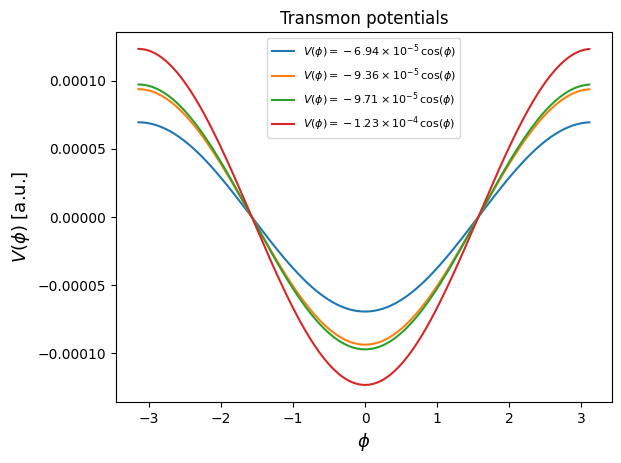

In [72]:
for i, potential in enumerate(V[:4]):
    label = r"$V(\phi) =" f"- {format_latex(params[i][0])} \, \cos(\phi)" r"$"
    plt.plot(phi, potential, label=label)
plt.xlabel('$\phi$')
plt.ylabel('$V(\phi)$ [a.u.]')
plt.title('Transmon potentials')
plt.legend(prop={'size': 8});

As for the wavefunctions, we see that the ground state is concentrated at the bottom of the energy well.

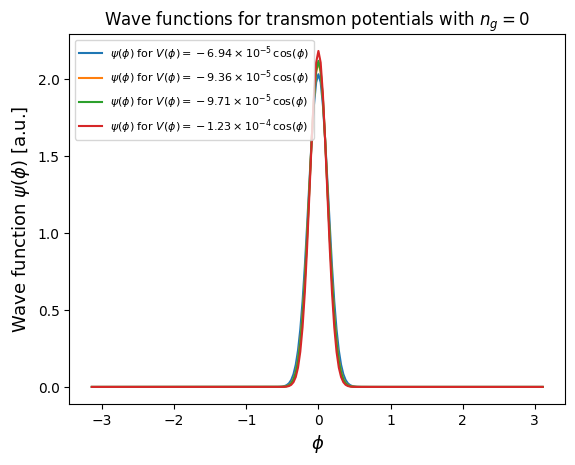

In [73]:
for i, wavefunction in enumerate(waves[:4]):
    label = (r"$\psi(\phi)$ for $V(\phi) ="
             f"-{format_latex(params[i][0])} \, \cos(\phi)"
             r"$")
    plt.plot(phi, wavefunction, label=label)
plt.xlabel('$\phi$')
plt.ylabel('Wave function $\psi(\phi)$ [a.u.]')
plt.title(f'Wave functions for transmon potentials with $n_g={ng}$')
plt.legend(prop={'size': 8});

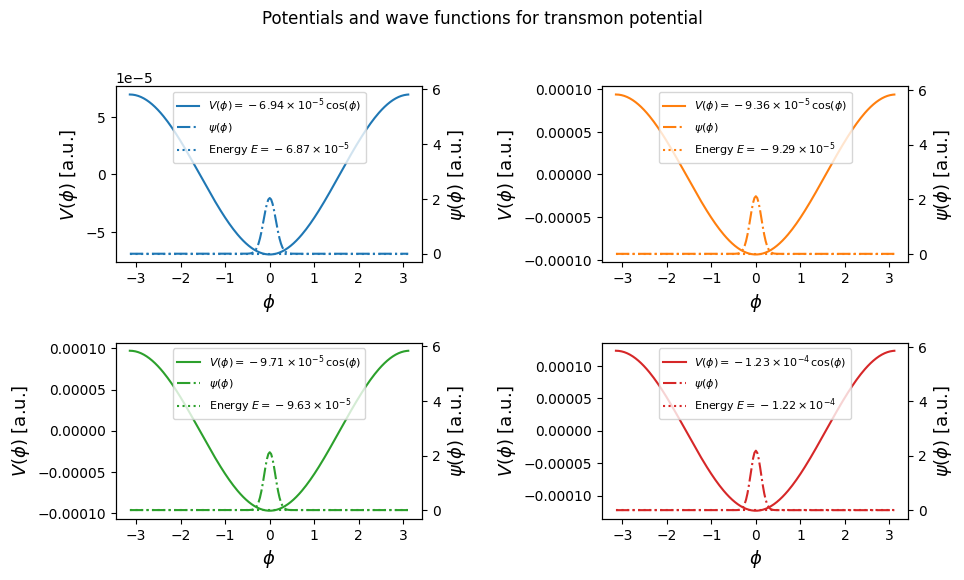

In [74]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle("Potentials and wave functions for transmon potential")
colours = list(mcolors.TABLEAU_COLORS)
for i, omega in enumerate(params[:4]):
    Vrange = V[i].max()-V[i].min()
    alpha = Vrange/1.5-np.abs(E[i])
    ax = plt.subplot(2, 2, i+1)
    label_wave = r"$\psi(\phi)$"
    label_V = (r"$V(\phi) ="
               f"-{format_latex(params[i][0])} \, \cos(\phi)"
               r"$")
    label_E = r"Energy $E = " f"{format_latex(E[i])} $"
    ln1 = ax.plot(phi, V[i], '-', color=colours[i], label=label_V)
    ln2 = ax.plot(phi, alpha*waves[i]+E[i],
                  '-.', color=colours[i],
                  label=label_wave)
    ln3 = ax.plot(phi, E[i]*np.ones_like(phi),
                  ':', color=colours[i],
                  label=label_E)
    plt.xlabel('$\phi$')
    plt.ylabel('$V(\phi)$ [a.u.]')
    ypmax = (ax.get_ylim()[1]-E[i])/alpha
    ypmin = (ax.get_ylim()[0]-E[i])/alpha
    ax2 = ax.twinx()
    ax2.set_ylim((ypmin, ypmax))
    plt.ylabel('$\psi(\phi)$ [a.u.]')
    ax.legend(prop={'size': 8}, loc='upper center')
fig.tight_layout(pad=2.0)

We calculate the energies for lowest laying states for those cosine potentials. We compute the differences of energies $\Delta E_n = E_{n+1} - E_0$ as a function of the excitation level.

In [75]:
Es = []
for n_state in range(15):
    Es.append(data_gen.generate_data(n_state, display=None)[0])
Es = np.array(Es).T
with np.printoptions(precision=2, suppress=False):
    print(Es)

[[-6.87e-05 -6.75e-05 -6.62e-05 -6.49e-05 -6.36e-05 -6.23e-05 -6.11e-05
  -5.98e-05 -5.85e-05 -5.73e-05 -5.60e-05 -5.48e-05 -5.35e-05 -5.22e-05
  -5.10e-05]
 [-9.29e-05 -9.14e-05 -8.99e-05 -8.84e-05 -8.69e-05 -8.54e-05 -8.40e-05
  -8.25e-05 -8.10e-05 -7.95e-05 -7.81e-05 -7.66e-05 -7.51e-05 -7.37e-05
  -7.22e-05]
 [-9.63e-05 -9.48e-05 -9.33e-05 -9.18e-05 -9.03e-05 -8.87e-05 -8.72e-05
  -8.57e-05 -8.42e-05 -8.27e-05 -8.12e-05 -7.97e-05 -7.83e-05 -7.68e-05
  -7.53e-05]
 [-1.22e-04 -1.21e-04 -1.19e-04 -1.17e-04 -1.15e-04 -1.14e-04 -1.12e-04
  -1.10e-04 -1.09e-04 -1.07e-04 -1.05e-04 -1.04e-04 -1.02e-04 -1.00e-04
  -9.86e-05]
 [-8.06e-05 -7.92e-05 -7.78e-05 -7.64e-05 -7.50e-05 -7.37e-05 -7.23e-05
  -7.09e-05 -6.95e-05 -6.82e-05 -6.68e-05 -6.54e-05 -6.41e-05 -6.27e-05
  -6.14e-05]]


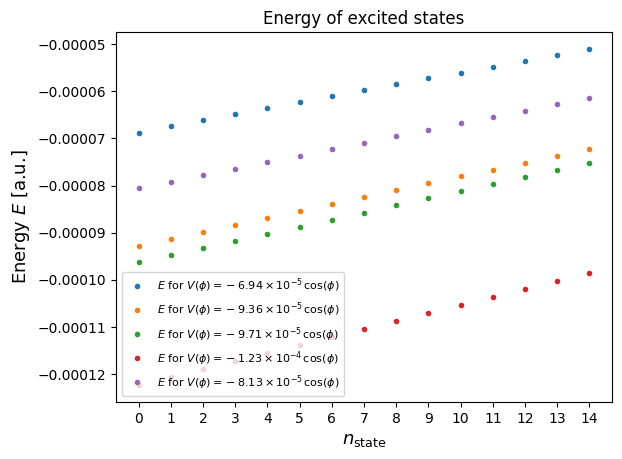

In [76]:
fig, ax = plt.figure(), plt.axes()
colours = list(mcolors.TABLEAU_COLORS)
for i, E in enumerate(Es):
    plt.plot(np.arange(E.shape[0]), E, '.', color=colours[i],
             label=(r"$E$ for $V(\phi) ="
                    f"- {format_latex(params[i][0])} \, \cos(\phi)"
                    r"$"))
plt.legend(prop={'size': 8})
plt.xlabel(r'$n_{\text{state}}$')
plt.ylabel('Energy $E$ [a.u.]')
plt.title("Energy of excited states")
plt.xticks(np.arange(Es.shape[1]));

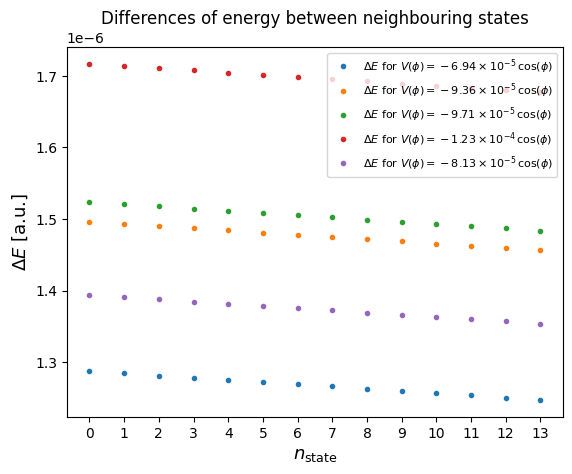

In [77]:
fig, ax = plt.figure(), plt.axes()
colours = list(mcolors.TABLEAU_COLORS)
for i, E in enumerate(np.diff(Es, 1)):
    plt.plot(np.arange(E.shape[0]), E, '.', color=colours[i],
             label=(r"$\Delta E$ for $V(\phi) ="
                    f"- {format_latex(params[i][0])} \, \cos(\phi)"
                    r"$"))
plt.legend(prop={'size': 8}, loc='upper right')
plt.xlabel(r'$n_{\text{state}}$')
plt.ylabel('$\Delta E$ [a.u.]')
plt.title("Differences of energy between neighbouring states")
plt.xticks(np.arange(Es.shape[1]-1));

We see that the difference of energies is manifestly not constant

$$ \Delta E_n \neq \text{const} .$$

They are monotonically decreasing - and therefore, our system is indeed anharmonic.

We want to also see how the anharmonicity changes with the parameter ratio $E_J/E_C$.

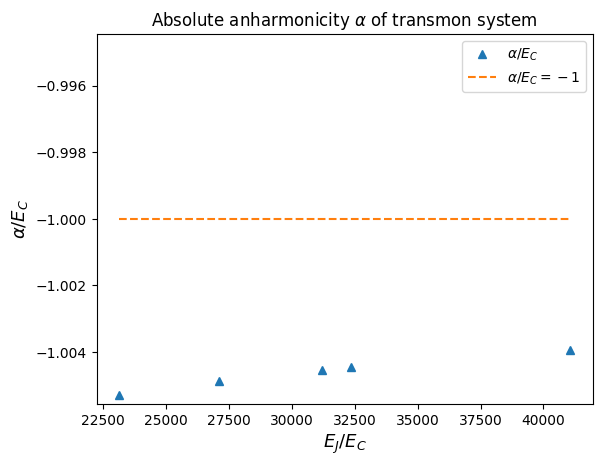

In [78]:
fig, ax = plt.figure(), plt.axes()

params_0 = (params/EC).flatten()
abs_asynch_0 = ((Es[:, 2] - Es[:, 1]) - (Es[:, 1] - Es[:, 0]))/EC

plt.plot((params/EC).flatten(),
         abs_asynch_0,
         '^',
         label=r"$\alpha/E_C$")
plt.plot(np.sort(params_0),
         -np.ones_like(params_0), '--',
         label=r"$\alpha/E_C = -1$")
plt.xlabel(r'$E_J/E_C$')
plt.ylabel(r'$\alpha/E_C$')
plt.title(r'Absolute anharmonicity $\alpha$ of transmon system')
plt.legend(prop={'size': 10}, loc='upper right')
plt.ylim((plt.ylim()[0], -2-plt.ylim()[0]));

Alternatively, we can calculate the relative anharmonicity $\alpha_r$ in place of the absolute anharmonicity

$$ \alpha_r = \frac{\Delta E_1 - \Delta E_0}{\Delta E_0} .$$

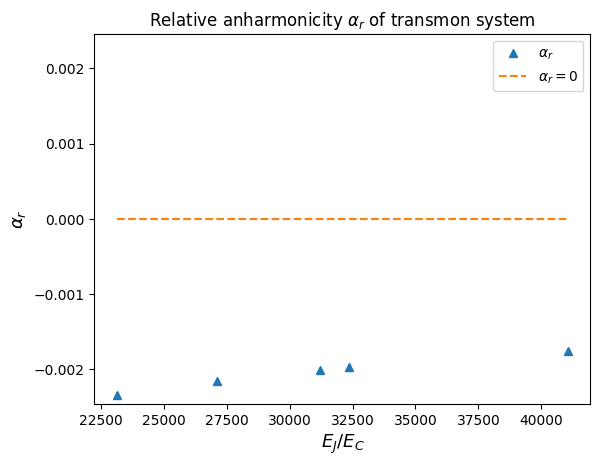

In [79]:
fig, ax = plt.figure(), plt.axes()

rel_asynch_0 = ((Es[:, 2] - Es[:, 1]) -
                (Es[:, 1] - Es[:, 0]))/(Es[:, 1] - Es[:, 0])

plt.plot((params/EC).flatten(),
         rel_asynch_0,
         '^',
         label=r"$\alpha_r$")
plt.plot(np.sort(params_0),
         np.zeros_like(params_0), '--',
         label=r"$\alpha_r = 0$")
plt.xlabel(r'$E_J/E_C$')
plt.ylabel(r'$\alpha_r$')
plt.title(r'Relative anharmonicity $\alpha_r$ of transmon system')
plt.legend(prop={'size': 10}, loc='upper right')
plt.ylim((plt.ylim()[0], -plt.ylim()[0]));

Moreover, let us compare the energy levels that we have obtained from the numerical computation with those which come from the approximation given in the introduction to the section.

In [80]:
def energies_transmon_approx(m: int | np.ndarray[Any,
                                                 np.dtype[np.int64]],
                             EJ: float | np.ndarray[Any,
                                                    np.dtype[np.float64]],
                             EC: float | np.ndarray[Any,
                                                    np.dtype[np.float64]]
                             ) -> np.ndarray[Any, np.dtype[np.float64]]:
    r'''
    Returns an approximate energy of a state for a transmon system 
    obtained from a quartic approximation of the potential.

    Parameters
    ----------
    m : int | np.ndarray[Any, np.dtype[np.int64]
        An excitation level or an array of them.
    EJ : float | np.ndarray[Any, np.dtype[np.float64]]
        One value of the parameter $E_J$ or an array of them.
    EC : float | np.ndarray[Any, np.dtype[np.float64]]
        One value of the parameter $E_C$ or an array of them.

    Returns
    -------
    np.ndarray[Any, np.dtype[np.float64]]
        An array of approximated energies.

    Examples
    --------
    >>> energies_transmon_approx(0, 1, 1)
    array([0.16421356])
    >>> energies_transmon_approx(np.arange(3),
    ... np.array([[10],[20],[30]]),
    ... 1)
    array([[ -5.77786405,   2.16640786,   9.11067977],
           [-13.92544468,  -2.27633404,   8.3727766 ],
           [-22.50403331,  -8.01209992,   5.47983346]])
    '''
    E = -EJ + np.sqrt(8*EJ*EC)*(m+1/2) - EC/12*(6*m**2+6*m+3)
    if type(E) == np.ndarray:
        return E
    else:
        return np.array([E])

In [81]:
Em = energies_transmon_approx(np.arange(15), params, EC)

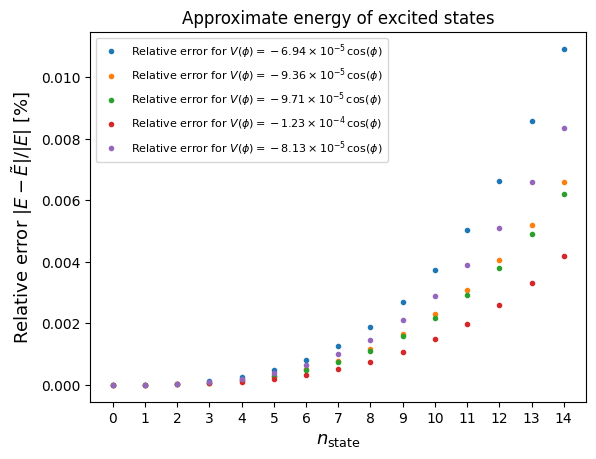

In [82]:
fig, ax = plt.figure(), plt.axes()
colours = list(mcolors.TABLEAU_COLORS)
for i, E in enumerate(Em):
    plt.plot(np.arange(E.shape[0]), 100*np.abs((E-Es[i])/Es[i]),
             '.', color=colours[i],
             label=(r"Relative error for $V(\phi) ="
                    f"- {format_latex(params[i][0])} \, \cos(\phi)"
                    r"$"))
plt.legend(prop={'size': 8})
plt.xlabel(r'$n_{\text{state}}$')
plt.ylabel(r'Relative error $|E-\tilde E|/|E|$ [%]')
plt.title("Approximate energy of excited states")
plt.xticks(np.arange(Es.shape[1]));

As we see, the approximation works well for lowest laying states. It gets worse for the states which have higher energies, as for those the difference between the true potential and a Taylor series approximation get more significant.

#### 2.2.2. $n_g = 1/2$

We want to visualise the wave functions and their energy levels for several potential with randomised parameters. Those parameters as as follows:

- `EC`: the junction charging energy $E_C$;
 - `phimin`, `phimax`: the parameters which determine the domain $\mathcal{D}=[\phi_{min}, \phi_{max}]$ of the potential $V(\phi), \phi\in D$;
 - `n_state`: determines the nth excited state of the Schrödinger equation, counting from the ground state (given by `n_state=0`) upwards with growing energy;
 - `N`: the amount of discretisation points into which we divide the domain $\mathcal{D}$ - higher $N$ corresponds to more precise numerical solution of the Schrödinger equation if one uses the DVR method;
 - `n_samples`: the number of triples (potential, wave function, energy) which will be generated;
 - `ng`: the number operator offset $n_g$;
 - `V_transmon`: the potential $V_\text{transmon}$ as a function of $\phi$ and a parameter $E_J$;
 - `params`: an (`n_samples` $\times$ `1`) array with potential parameter $E_J$ for each sample.

Now we will consider the case when $n_g=1/2$. In order to do that, we will use a class `CustomKineticOperator` which allows one to consider not only the standard kinetic operator (which is just square of the momentum operator), but also more complicated ones.

In [83]:
EC = 3*10**(-9)

phimin = -np.pi
phimax = np.pi
n_state = 0
N = 200
n_samples = 5
ng = 1/2

mass = 1/(8*EC)

V_transmon = lambda x, *A: -A[0]*np.cos(x)
params = EC*5000*(1+8*np.random.random((n_samples, 1)))
params_transmon_05 = params
phi = np.arange(phimin, phimax, (phimax - phimin)/N)
Vs = construct_potentials(V_transmon, params, phi)

The effective capacity $C_\Sigma = C_J + C_g + C_B$ (for the shunted junction - in the case of the SQUID one would need to use an appropriate formula for $C_\Sigma$ as a function of $C_{J,1}$, $C_{J,2}$ and $\tilde \Phi$) of this junction is given by

$$ C_\Sigma = \frac{e^2}{2 E_C} . $$

In the atomic units it is

In [84]:
C = 1/2/EC
C

166666666.66666666

while in farads it is

In [85]:
C*(echarge**2/hartree)

9.813150884195398e-13

In [86]:
params/EC

array([[34667.09862914],
       [38928.19991333],
       [25097.16821103],
       [43749.14674079],
       [14540.01123051]])

In [87]:
data_gen = CustomKineticOperator(N, phimin, phimax, Vs, mass,
                                 hbar=1.,  # We use hbar=1 because phi
                                 # and the momentum are
                                 # dimensionless
                                 lin_kin_coeff=-ng,
                                 const_kin_coeff=ng**2)

E, a = data_gen.generate_data(n_state, display=None)
waves, phi, _ = data_gen.final_wavefunction(a)
V, _ = data_gen.evaluate_potential()

We begin by drawing several potentials for different choices of parameters.

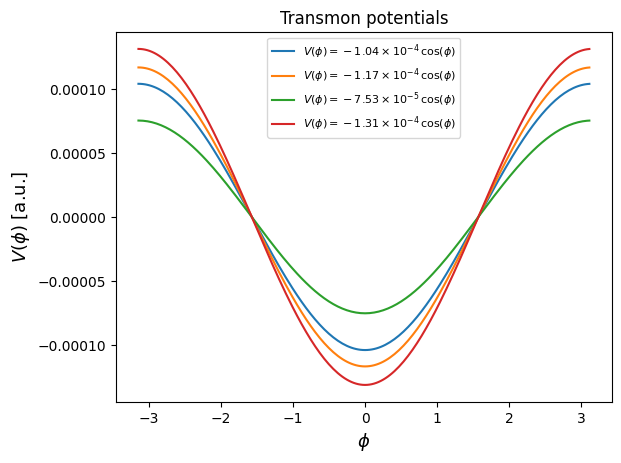

In [88]:
for i, potential in enumerate(V[:4]):
    label = (r"$V(\phi) ="
             f"- {format_latex(params[i][0])} \, \cos(\phi)"
             r"$")
    plt.plot(phi, potential, label=label)
plt.xlabel('$\phi$')
plt.ylabel('$V(\phi)$ [a.u.]')
plt.title('Transmon potentials')
plt.legend(prop={'size': 8});

As for the wavefunctions, we see that the ground state is concentrated at the bottom of the energy well.

Because we have a non-zero offset $n_g$ the wavefunction becomes complex instead of being purely real.

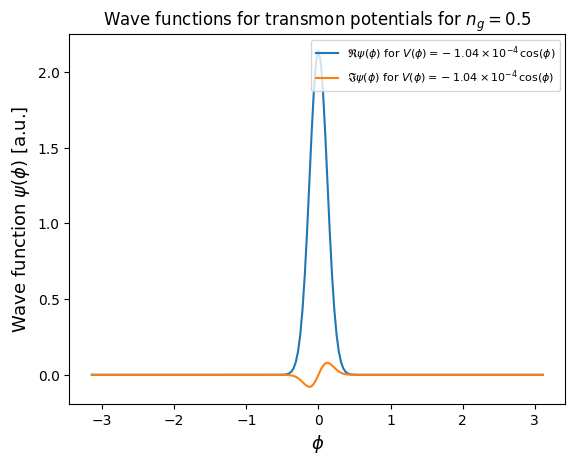

In [89]:
for i, wavefunction in enumerate(waves[:1]):
    label = (r"$\psi(\phi)$ for $V(\phi) ="
             f"- {format_latex(params[i][0])} \, \cos(\phi)"
             r"$")
    plt.plot(phi, wavefunction.real,
             label=("$\mathfrak{R}$" + label))
    plt.plot(phi, wavefunction.imag,
             label=("$\mathfrak{I}$" + label))
plt.xlabel('$\phi$')
plt.ylabel('Wave function $\psi(\phi)$ [a.u.]')
plt.title(f'Wave functions for transmon potentials for $n_g={ng}$')
plt.legend(prop={'size': 8}, loc='upper right');

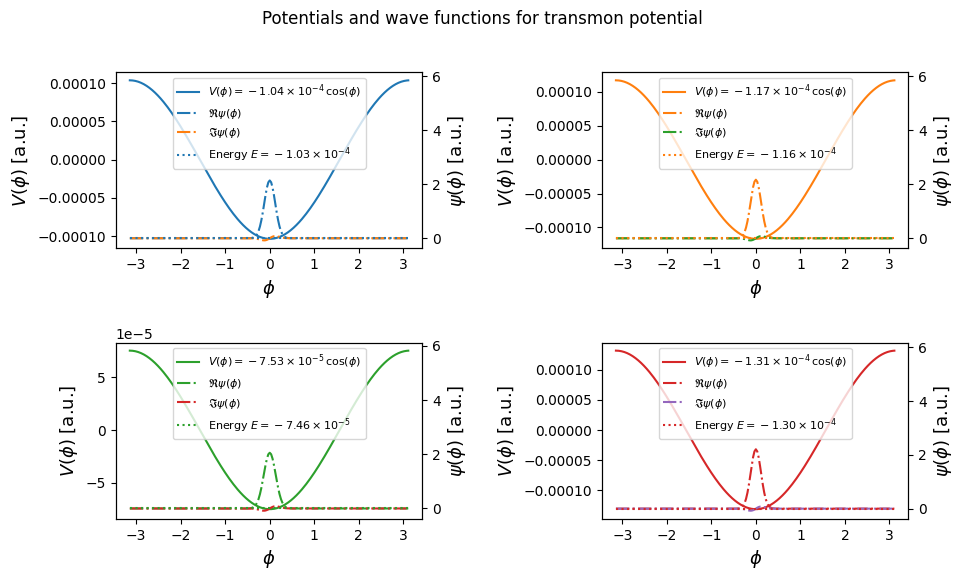

In [90]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle("Potentials and wave functions for transmon potential")
colours = list(mcolors.TABLEAU_COLORS)
for i, omega in enumerate(params[:4]):
    Vrange = V[i].max()-V[i].min()
    alpha = Vrange/1.5-np.abs(E[i])
    ax = plt.subplot(2, 2, i+1)
    label_wave = r"$\psi(\phi)$"
    label_V = (r"$V(\phi) ="
               f"-{format_latex(params[i][0])} \, \cos(\phi)"
               r"$")
    label_E = (r"Energy $E = "
               f"{format_latex(E[i])}$")
    ln1 = ax.plot(phi, V[i], '-', color=colours[i], label=label_V)
    ln2 = plt.plot(phi, alpha*waves[i].real+E[i], '-.',
                   color=colours[i],
                   label=("$\mathfrak{R}$" + label_wave))
    ln3 = plt.plot(phi, alpha*waves[i].imag+E[i], '-.',
                   color=colours[i+1],
                   label=("$\mathfrak{I}$" + label_wave))
    ln4 = ax.plot(phi, E[i]*np.ones_like(phi), ':',
                  color=colours[i], label=label_E)
    plt.xlabel('$\phi$')
    plt.ylabel('$V(\phi)$ [a.u.]')
    ypmax = (ax.get_ylim()[1]-E[i])/alpha
    ypmin = (ax.get_ylim()[0]-E[i])/alpha
    ax2 = ax.twinx()
    ax2.set_ylim((ypmin, ypmax))
    plt.ylabel('$\psi(\phi)$ [a.u.]')
    ax.legend(prop={'size': 8}, loc='upper center')
fig.tight_layout(pad=2.0)

We calculate the energies for lowest laying states for those cosine potentials. We compute the differences of energies $\Delta E_n = E_{n+1} - E_0$ as a function of the excitation level.

In [91]:
Es = []
for n_state in range(15):
    Es.append(data_gen.generate_data(n_state, display=None)[0])
Es = np.array(Es).T
with np.printoptions(precision=2, suppress=False):
    print(Es)
Es_transmon_05 = Es

[[-1.03e-04 -1.02e-04 -1.00e-04 -9.85e-05 -9.69e-05 -9.54e-05 -9.38e-05
  -9.22e-05 -9.07e-05 -8.91e-05 -8.76e-05 -8.60e-05 -8.45e-05 -8.30e-05
  -8.14e-05]
 [-1.16e-04 -1.14e-04 -1.13e-04 -1.11e-04 -1.09e-04 -1.08e-04 -1.06e-04
  -1.04e-04 -1.03e-04 -1.01e-04 -9.94e-05 -9.77e-05 -9.61e-05 -9.45e-05
  -9.28e-05]
 [-7.46e-05 -7.33e-05 -7.19e-05 -7.06e-05 -6.93e-05 -6.79e-05 -6.66e-05
  -6.53e-05 -6.40e-05 -6.27e-05 -6.13e-05 -6.00e-05 -5.87e-05 -5.74e-05
  -5.61e-05]
 [-1.30e-04 -1.29e-04 -1.27e-04 -1.25e-04 -1.23e-04 -1.22e-04 -1.20e-04
  -1.18e-04 -1.16e-04 -1.15e-04 -1.13e-04 -1.11e-04 -1.09e-04 -1.08e-04
  -1.06e-04]
 [-4.31e-05 -4.21e-05 -4.11e-05 -4.01e-05 -3.90e-05 -3.80e-05 -3.70e-05
  -3.60e-05 -3.50e-05 -3.40e-05 -3.30e-05 -3.21e-05 -3.11e-05 -3.01e-05
  -2.91e-05]]


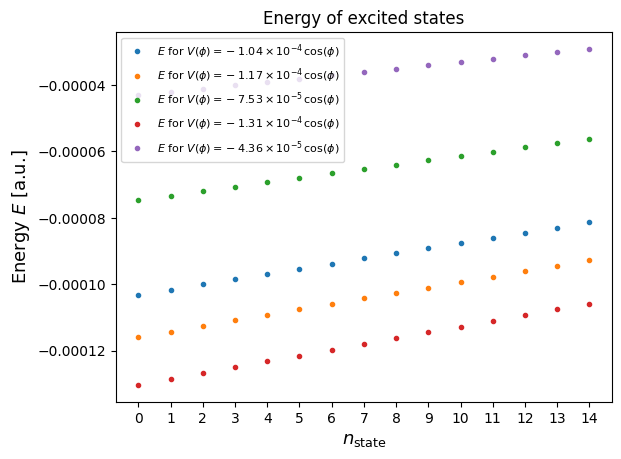

In [92]:
fig, ax = plt.figure(), plt.axes()
colours = list(mcolors.TABLEAU_COLORS)
for i, E in enumerate(Es):
    plt.plot(np.arange(E.shape[0]), E, '.',
             color=colours[i],
             label=(r"$E$ for $V(\phi) ="
                    f"- {format_latex(params[i][0])} \, \cos(\phi)"
                    r"$"))
plt.legend(prop={'size': 8})
plt.xlabel(r'$n_{\text{state}}$')
plt.ylabel('Energy $E$ [a.u.]')
plt.title("Energy of excited states")
plt.xticks(np.arange(Es.shape[1]));

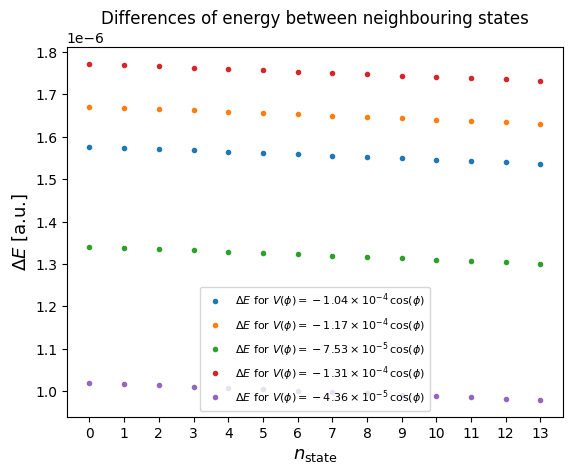

In [93]:
fig, ax = plt.figure(), plt.axes()
colours = list(mcolors.TABLEAU_COLORS)
for i, E in enumerate(np.diff(Es, 1)):
    plt.plot(np.arange(E.shape[0]), E, '.',
             color=colours[i],
             label=(r"$\Delta E$ for $V(\phi) ="
                    f"- {format_latex(params[i][0])} \, \cos(\phi)"
                    r"$"))
plt.legend(prop={'size': 8})
plt.xlabel(r'$n_{\text{state}}$')
plt.ylabel('$\Delta E$ [a.u.]')
plt.title("Differences of energy between neighbouring states")
plt.xticks(np.arange(Es.shape[1]-1));

The system is anharmonic.

We want to also see how the anharmonicity changes with the parameter ration $E_J/E_C$.

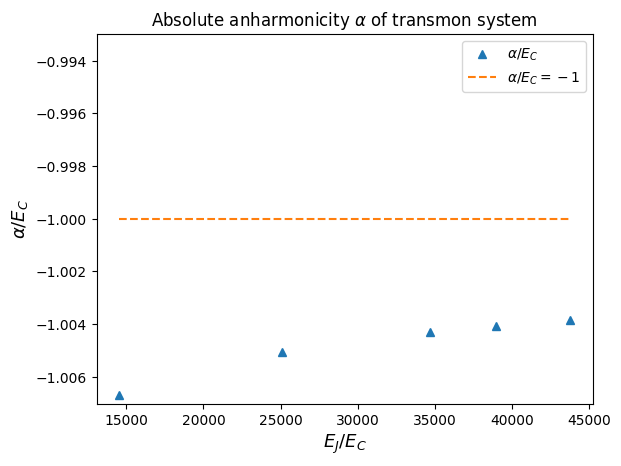

In [94]:
fig, ax = plt.figure(), plt.axes()

params_05 = (params/EC).flatten()
abs_asynch_05 = ((Es[:, 2] - Es[:, 1]) - (Es[:, 1] - Es[:, 0]))/EC

plt.plot(params_05,
         abs_asynch_05,
         '^',
         label=r"$\alpha/E_C$")
plt.plot(np.sort(params_05),
         -np.ones_like(params_05), '--',
         label=r"$\alpha/E_C = -1$")
plt.xlabel(r'$E_J/E_C$')
plt.ylabel(r'$\alpha/E_C$')
plt.title(r'Absolute anharmonicity $\alpha$ of transmon system')
plt.legend(prop={'size': 10}, loc='upper right')
plt.ylim((plt.ylim()[0], -2-plt.ylim()[0]));

Alternatively, we can calculate the relative anharmonicity $\alpha_r$ in place of the absolute anharmonicity

$$ \alpha_r = \frac{\Delta E_1 - \Delta E_0}{\Delta E_0} .$$

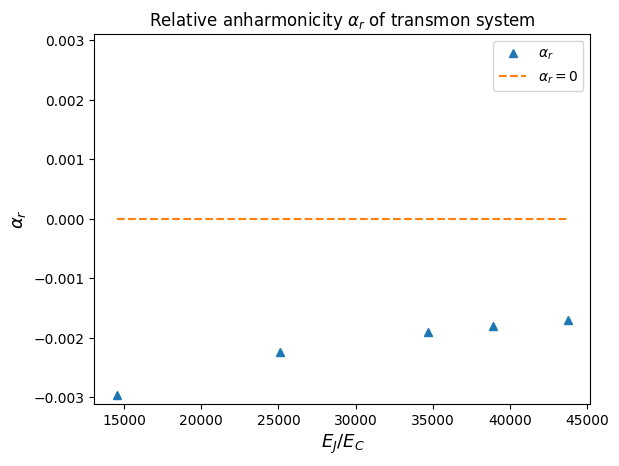

In [95]:
fig, ax = plt.figure(), plt.axes()

rel_asynch_05 = ((Es[:, 2] - Es[:, 1]) -
                 (Es[:, 1] - Es[:, 0]))/(Es[:, 1] - Es[:, 0])

plt.plot(params_05,
         rel_asynch_05,
         '^',
         label=r"$\alpha_r$")
plt.plot(np.sort(params_05),
         np.zeros_like(params_05), '--',
         label=r"$\alpha_r = 0$")
plt.xlabel(r'$E_J/E_C$')
plt.ylabel(r'$\alpha_r$')
plt.title(r'Relative anharmonicity $\alpha_r$ of transmon system')
plt.legend(prop={'size': 10}, loc='upper right')
plt.ylim((plt.ylim()[0], -plt.ylim()[0]));

Let us compare the energy levels that we have obtained from the numerical computation with those which come from the approximation given in the introduction to the section.

In [96]:
Em = energies_transmon_approx(np.arange(15), params, EC)

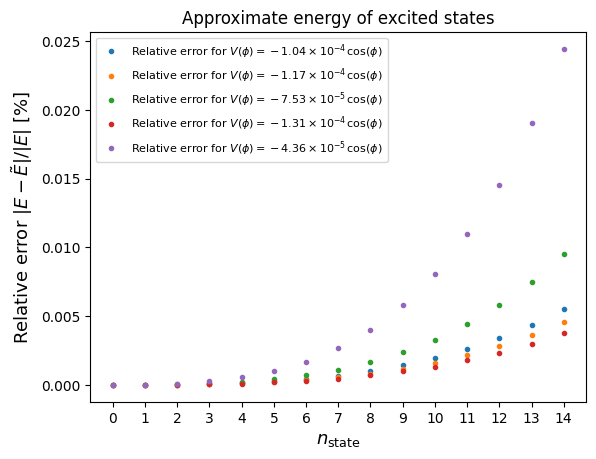

In [97]:
fig, ax = plt.figure(), plt.axes()
colours = list(mcolors.TABLEAU_COLORS)
for i, E in enumerate(Em):
    plt.plot(np.arange(E.shape[0]),
             100*np.abs((E-Es[i])/Es[i]),
             '.', color=colours[i],
             label=(r"Relative error for $V(\phi) ="
                    f"- {format_latex(params[i][0])} \, \cos(\phi)"
                    r"$"))
plt.legend(prop={'size': 8})
plt.xlabel(r'$n_{\text{state}}$')
plt.ylabel(r'Relative error $|E-\tilde E|/|E|$ [%]')
plt.title("Approximate energy of excited states")
plt.xticks(np.arange(Es.shape[1]));

The approximation works also when $n_g$ is non-zero.

#### 2.2.3 Asynchronicities as a function of $n_g$

We can illustrate the absolute and relative asynchronicities that we calculated in the above sections as a function of the offset parameter $n_g$.

First, let us try to find a probable dependence of $\alpha$ in terms of $E_J/E_C$.

In [98]:
from scipy.optimize import curve_fit

f: Callable[[Union[float,
                   np.ndarray[Any, np.dtype[np.float64]]],
             float], Union[float,
                           np.ndarray[Any, np.dtype[np.float64]]]
            ] = lambda x, r: -1 + 1/(1-r*np.sqrt(x))

x = np.hstack((params_0, params_05))
y = np.hstack((abs_asynch_0, abs_asynch_05))
sort = x.argsort()
x = x[sort]
y = y[sort]

popt, pcov = curve_fit(f, x, y)
popt

array([1.25082217])

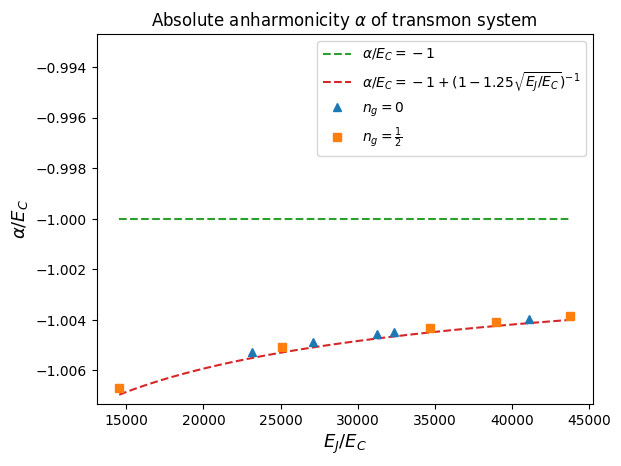

In [99]:
fig, ax = plt.figure(), plt.axes()

x = np.linspace(np.hstack((params_0, params_05)).min(),
                np.hstack((params_0, params_05)).max(),
                100)

plt.plot(x,
         -np.ones_like(x), '--',
         label=r"$\alpha/E_C = -1$",
         color=colours[2])
plt.plot(x,
         f(x, 1.2),
         '--',
         label=(r"$\alpha/E_C = -1 + "
                f"(1-{popt[0]:0.2f}"
                r"\sqrt{E_J/E_C})^{-1}$"),
         color=colours[3])
plt.plot(params_0,
         abs_asynch_0,
         '^',
         label=r"$n_g=0$",
         color=colours[0])
plt.plot(params_05,
         abs_asynch_05,
         's',
         label=r"$n_g=\frac{1}{2}$",
         color=colours[1])
plt.xlabel(r'$E_J/E_C$')
plt.ylabel(r'$\alpha/E_C$')
plt.title(r'Absolute anharmonicity $\alpha$ of transmon system')
plt.legend(prop={'size': 10}, loc='upper right')
plt.ylim((plt.ylim()[0], -2-plt.ylim()[0]));

Alternatively, we can calculate the relative anharmonicity $\alpha_r$ in place of the absolute anharmonicity

$$ \alpha_r = \frac{\Delta E_1 - \Delta E_0}{\Delta E_0} .$$

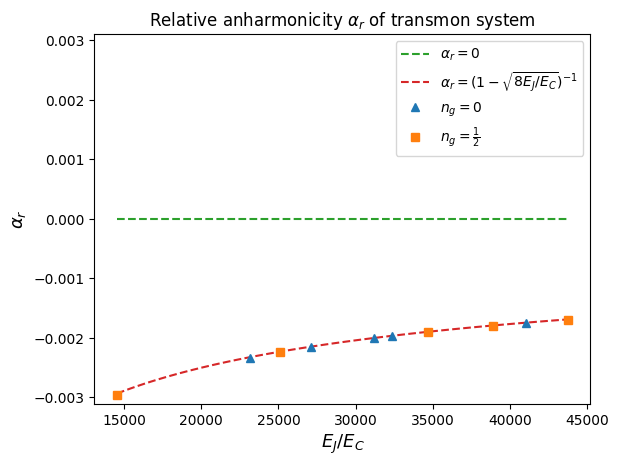

In [100]:
fig, ax = plt.figure(), plt.axes()

plt.plot(x,
         np.zeros_like(x),
         '--',
         label=r"$\alpha_r = 0$",
         color=colours[2])
plt.plot(x,
         1/(1-np.sqrt(8*x)),
         '--',
         label=r"$\alpha_r =(1-\sqrt{8E_J/E_C})^{-1}$",
         color=colours[3])
plt.plot(params_0,
         rel_asynch_0,
         '^',
         label=r"$n_g=0$",
         color=colours[0])
plt.plot(params_05,
         rel_asynch_05,
         's',
         label=r"$n_g=\frac{1}{2}$",
         color=colours[1])
plt.xlabel(r'$E_J/E_C$')
plt.ylabel(r'$\alpha_r$')
plt.title(r'Relative anharmonicity $\alpha_r$ of transmon system')
plt.legend(prop={'size': 10}, loc='upper right')
plt.ylim((plt.ylim()[0], -plt.ylim()[0]));

From the quartic approximation approximation of the energies of the transmon, we can deduce that the anharmonicities have the following form:

$$ \alpha = -E_C ,$$

$$ \alpha_r = \frac{1}{1-\sqrt{8 E_J/E_C}} . $$

One can observe that the analytical formulae from the quartic approximation describe the relative anharmonicity $\alpha_r$ relatively well, but they describe the absolute anharmonicity $\alpha$ only asymptotically. 

However, it appears that in the case of absolute anharmonicity $\alpha$ a function

$$ \alpha = -E_C+\frac{E_C}{1-r \sqrt{E_J/E_C}} , $$

for $r=1.25$ provides an acceptable approximation.

As we see, the transmon is fairly independent of the offset parameter $n_g$, and therefore is protected against the dephasing which comes from the noise in the voltage $V_g$.

## Appendix A. Momentum secular problem

We want to visualise the wave functions and their energy levels for the momentum eigenproblem

$$ \hat p \psi(x) = p \psi(x) .$$

We have the following parameters:

 - `xmin`, `xmax`: the parameters which determine the domain $\mathcal{D}=[x_{min}, x_{max}]$ of the potential $V(x), x\in D$;
 - `n_state`: determines the nth excited state of the Schrödinger equation, counting from the ground state (given by `n_state=0`) upwards with growing energy;
 - `N`: the amount of discretisation points into which we divide the domain $\mathcal{D}$ - higher $N$ corresponds to more precise numerical solution of the Schrödinger equation if one uses the DVR method;
 - `n_samples`: the number of triples (potential, wave function, energy) which will be generated;
 - `mass`: the mass of the particle;
 - `V_zero`: the potential $V_0(x)=0$;
 - `params`: an (`n_samples` $\times$ `1`) array with randomised numbers that are not used because we consider zero potential.

In [101]:
xmin = -np.pi
xmax = np.pi
n_state = 97
N = 200
n_samples = 1

mass = 1.

V_zero = lambda x, *A: 0*x
params = np.zeros((n_samples, 1))
x = np.arange(xmin, xmax, (xmax - xmin)/N)
Vs = construct_potentials(V_zero, params, x)

In [102]:
data_gen = CustomKineticOperator(N, xmin, xmax, Vs, mass, hbar=1,
                                 quad_kin_coeff=0,
                                 lin_kin_coeff=1)

P, a = data_gen.generate_data(n_state, display=None)
waves, x, _ = data_gen.final_wavefunction(a)
V, _ = data_gen.evaluate_potential()

We see that the potential is zero, i.e. we consider a free particle.

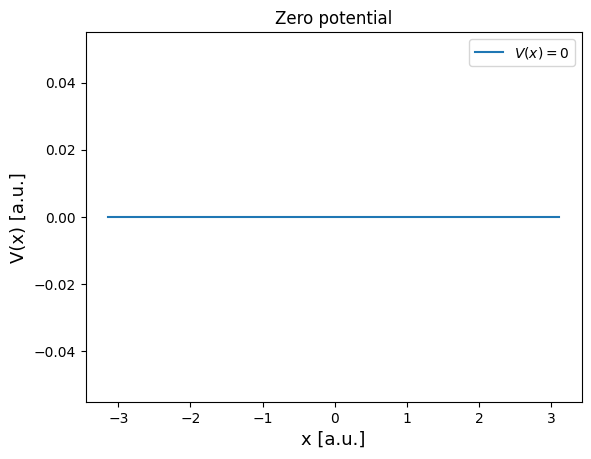

In [103]:
for i, potential in enumerate(V[:1]):
    label = r"$V(x) = 0$"
    plt.plot(x, potential, label=label)
plt.xlabel('x [a.u.]')
plt.ylabel('V(x) [a.u.]')
plt.title('Zero potential')
plt.legend(prop={'size': 10});

The wavefunctions are complex and given by free waves.

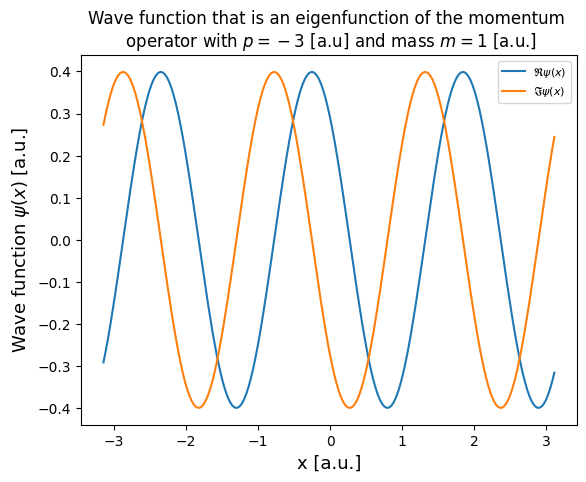

In [104]:
for i, wavefunction in enumerate(waves[:1]):
    label = r"$\psi(x)$"
    plt.plot(x, wavefunction.real,
             label=("$\mathfrak{R}$" + label))
    plt.plot(x, wavefunction.imag,
             label=("$\mathfrak{I}$" + label))
plt.xlabel('x [a.u.]')
plt.ylabel('Wave function $\psi(x)$ [a.u.]')
plt.title(("Wave function that is an eigenfunction of the "
           f"momentum \n operator with $p={P[0]:0.0f}$ "
           f"[a.u] and mass $m={mass:0.0f}$ [a.u.]"))
plt.legend(prop={'size': 8});

We can calculate the momenta which correspond to the states that we obtained numerically.

In [105]:
Ps = []
for n_state in range(10):
    Ps.append(data_gen.generate_data(n_state, display=None)[0])
Ps = np.array(Ps).T
Ps

array([[-100.,  -99.,  -98.,  -97.,  -96.,  -95.,  -94.,  -93.,  -92.,
         -91.]])

We see that the smallest eigenvalue is given by the quantity which corresponds to the smallest allowed momentum from the DVR construction

$$ p_\text{min} = - \frac{N}{L} \pi \hbar .$$

In [106]:
pmin = -np.pi*N/(xmax-xmin)
pmin

-100.0

## Appendix B. Harmonic oscillator solved numerically

In this section we will solve the harmonic oscillator using numerical methods instead of relying on the analytical expressions like in the [section 1.1](#1.1.-Harmonic-potentials). We have the following parameters:

 - `phimin`, `phimax`: the parameters which determine the domain $\mathcal{D}=[\Phi_{min}, \Phi_{max}]$ of the potential $V(\Phi), \Phi\in D$;
 - `n_state`: determines the nth excited state of the Schrödinger equation, counting from the ground state (given by `n_state=0`) upwards with growing energy;
 - `N`: the amount of discretisation points into which we divide the domain $\mathcal{D}$ - higher $N$ corresponds to more precise numerical solution of the Schrödinger equation if one uses the DVR method;
 - `n_samples`: the number of triples (potential, wave function, energy) which will be generated;
 - `C`: the capacitance $C$;
 - `L`: an (`n_samples` $\times$ `1`) array with the inductances $L$ of the potentials $V(\Phi)$ for each sample;
 - `V_phi`: the quadratic potential $V_\Phi = \frac{1}{2L} (\Phi - \frac{1}{2}(\Phi_{max}+\Phi_{min}))^2$ as a function of $\Phi$ and parameter $L$;

In [107]:
phimin = -4
phimax = 4
n_state = 0
N = 700
n_samples = 4

C = 10**(-12)  # Value in farads (F)
C /= (echarge**2/hartree)
L = np.array([10**(-10)])  # Value in henrys (H)
L = L*(1+0.5*(np.random.random((n_samples, 1))-1/2))
L /= (hbar**2/echarge**2/hartree)

mass = C
omegas = 1/np.sqrt(L*C)

V_phi = lambda x, *A: A[0]*(x - (phimax+phimin)/2)**2/2
params = 1/L
phi = np.arange(phimin, phimax, (phimax - phimin)/N)
Vs = construct_potentials(V_phi, params, phi)

In [108]:
data_gen = CustomPotential(N, phimin, phimax, Vs, mass, hbar=1)

E, a = data_gen.generate_data(n_state, display=None)
waves, phi, _ = data_gen.final_wavefunction(a)
V, _ = data_gen.evaluate_potential()

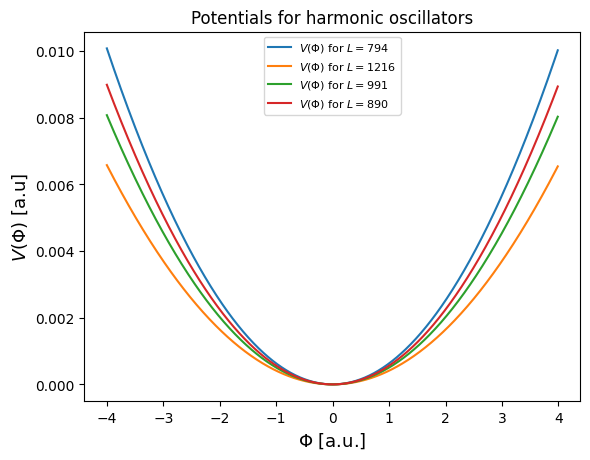

In [109]:
for i, potential in enumerate(V[:4]):
    label = r"$V(\Phi)$ for $L=" f"{L[i][0]:0.0f}" r"$"
    plt.plot(phi, potential, label=label)
plt.xlabel('$\Phi$ [a.u.]')
plt.ylabel('$V(\Phi)$ [a.u]')
plt.title('Potentials for harmonic oscillators')
plt.legend(prop={'size': 8});

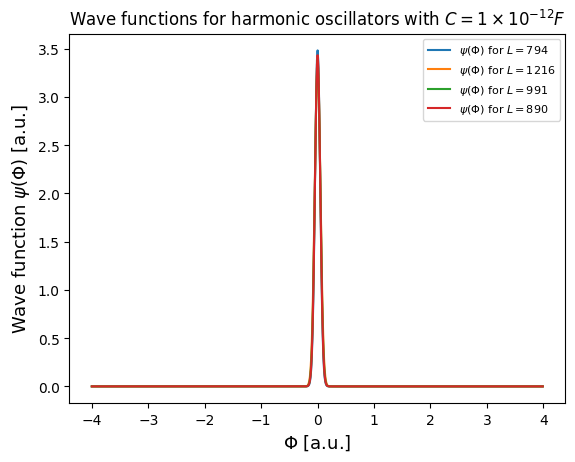

In [110]:
for i, wavefunction in enumerate(waves[:4]):
    label = r"$\psi(\Phi)$ for $L=" f"{L[i][0]:0.0f}" r"$"
    plt.plot(phi, wavefunction, label=label)
plt.xlabel('$\Phi$ [a.u.]')
plt.ylabel('Wave function $\psi(\Phi)$ [a.u.]')
plt.title('Wave functions for harmonic oscillators '
          f'with $C={format_latex(C*(echarge**2/hartree),0)} F$')
plt.legend(prop={'size': 8});

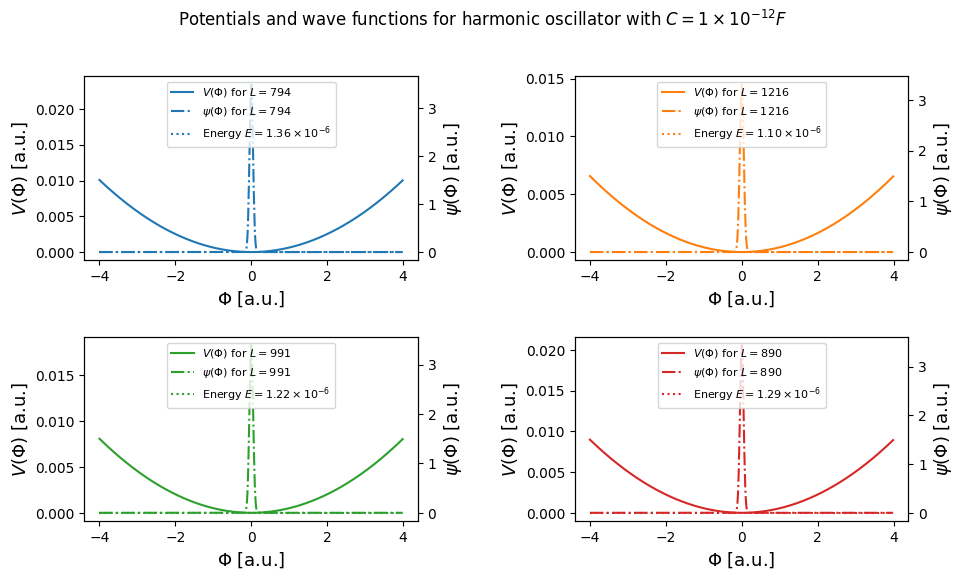

In [111]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle("Potentials and wave functions for harmonic oscillator with "
             f"$C={format_latex(C*(echarge**2/hartree),0)} F$")
colours = list(mcolors.TABLEAU_COLORS)
for i, omega in enumerate(omegas.flatten()[:4]):
    Vrange = V[i].max()-V[i].min()
    alpha = Vrange/1.5-np.abs(E[i])
    ax = plt.subplot(2, 2, i+1)
    label_wave = r"$\psi(\Phi)$ for $L =" f"{L[i][0]:0.0f}" r"$"
    label_V = r"$V(\Phi)$ for $L =" f"{L[i][0]:0.0f}" r"$"
    label_E = r"Energy $E = " f"{format_latex(E[i])} $"
    ln1 = ax.plot(phi, V[i], '-', color=colours[i], label=label_V)
    ln2 = ax.plot(phi, alpha*waves[i]+E[i], '-.',
                  color=colours[i], label=label_wave)
    ln3 = ax.plot(phi, E[i]*np.ones_like(phi), ':',
                  color=colours[i], label=label_E)
    plt.xlabel('$\Phi$ [a.u.]')
    plt.ylabel('$V(\Phi)$ [a.u.]')
    ypmax = (ax.get_ylim()[1]-E[i])/alpha
    ypmin = (ax.get_ylim()[0]-E[i])/alpha
    ax2 = ax.twinx()
    ax2.set_ylim((ypmin, ypmax))
    plt.ylabel('$\psi(\Phi)$ [a.u.]')
    ax.legend(loc='upper center', prop={'size': 8})
fig.tight_layout(pad=2.0)

In [112]:
Es = []
for n_state in range(15):
    Es.append(data_gen.generate_data(n_state, display=None)[0])
Es = np.array(Es).T
with np.printoptions(precision=2, suppress=False):
    print(Es)

[[1.36e-06 4.09e-06 6.81e-06 9.53e-06 1.23e-05 1.50e-05 1.77e-05 2.04e-05
  2.32e-05 2.59e-05 2.86e-05 3.13e-05 3.40e-05 3.68e-05 3.95e-05]
 [1.10e-06 3.30e-06 5.50e-06 7.70e-06 9.90e-06 1.21e-05 1.43e-05 1.65e-05
  1.87e-05 2.09e-05 2.31e-05 2.53e-05 2.75e-05 2.97e-05 3.19e-05]
 [1.22e-06 3.66e-06 6.09e-06 8.53e-06 1.10e-05 1.34e-05 1.58e-05 1.83e-05
  2.07e-05 2.32e-05 2.56e-05 2.80e-05 3.05e-05 3.29e-05 3.54e-05]
 [1.29e-06 3.86e-06 6.43e-06 9.00e-06 1.16e-05 1.41e-05 1.67e-05 1.93e-05
  2.19e-05 2.44e-05 2.70e-05 2.96e-05 3.21e-05 3.47e-05 3.73e-05]]


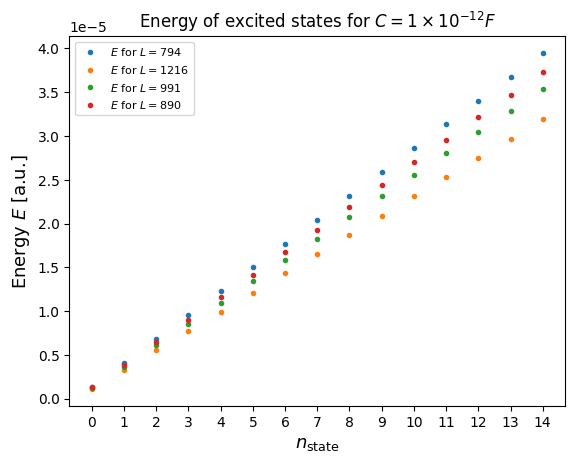

In [113]:
fig, ax = plt.figure(), plt.axes()
colours = list(mcolors.TABLEAU_COLORS)
for i, E in enumerate(Es):
    plt.plot(np.arange(E.shape[0]), E, '.',
             color=colours[i],
             label=r"$E$ for $L=" f"{L[i][0]:0.0f}" r"$")
plt.legend(prop={'size': 8})
plt.xlabel(r'$n_{\text{state}}$')
plt.ylabel('Energy $E$ [a.u.]')
plt.title(("Energy of excited states for $C="
           f"{format_latex(C*(echarge**2/hartree),0)} F$"))
plt.xticks(np.arange(Es.shape[1]));

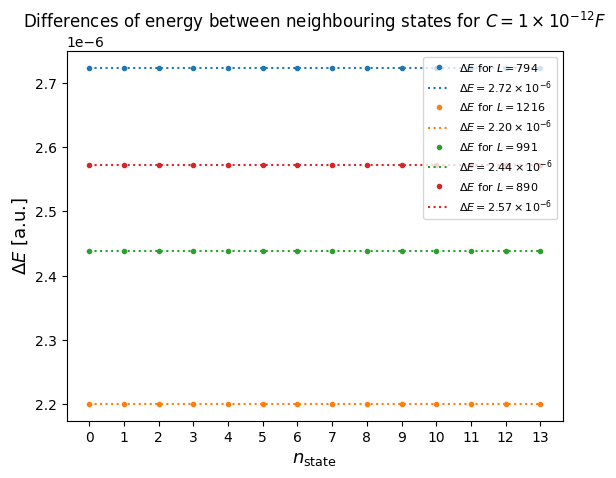

In [114]:
fig, ax = plt.figure(), plt.axes()
colours = list(mcolors.TABLEAU_COLORS)
for i, E in enumerate(np.diff(Es, 1)):
    plt.plot(np.arange(E.shape[0]), E, '.',
             color=colours[i],
             label=(r"$\Delta E$ for $L=" f"{L[i][0]:0.0f}" r"$"))
    plt.plot(np.arange(E.shape[0]),
             omegas[i]*np.ones(E.shape[0]), ':',
             color=colours[i],
             label=(f"$\Delta E ={format_latex(omegas[i][0])}$"))
plt.legend(prop={'size': 8}, loc='upper right')
plt.xlabel(r'$n_{\text{state}}$')
plt.ylabel('$\Delta E$ [a.u.]')
plt.title(("Differences of energy between neighbouring states for "
           f"$C={format_latex(C*(echarge**2/hartree),0)} F$"))
plt.xticks(np.arange(Es.shape[1]-1));

## Appendix C. Alternative solution of the transmon Hamiltonian

In this section we will consider an alternative solution for the transmon system with non-zero charge offset parameter $n_g$.

Because the kinetic energy in the Hamiltonian $H_\text{CPB}$ is not diagonal in momentum $p_\phi$ (i.e. the number of the Cooper pairs $n$), one cannot immediately use the formulation of the DVR which does not implement the momentum operator. While one can resolve it by generalising our DVR procedure (as we in fact did in the [section 2.2.2.](2.2.2.-$n_g-=-1/2$)), we can also approach it from another side.

We know that momentum is a generator of space translations, and vice versa. Therefore, one knows (or can easily confirm) that

$$ e^{-in\phi} \left( -i \frac{\text{d}}{\text{d}\phi} \right) e^{in\phi} = -i \frac{\text{d}}{\text{d}\phi} + n .$$

We also know that the this translation (in the momentum space) operator is unitary, because the position is self-adjoint

$$ \left( e^{in\phi} \right)^\dagger = e^{-in\phi} .$$

Thus, we can perform an unitary transformation which removes for us the presence of $n_g$ in the kinetic energy of the Hamiltonian

$$ {\tilde H}_\text{CPB} = e^{-i n_g \phi} H_\text{CPB} e^{i n_g \phi} = 4 E_C \left(-i \frac{\text{d}}{\text{d}\phi}\right)^2 - E_J \cos\phi ,$$

$$ {\tilde \psi}(\phi) = e^{-i n_g \phi} \psi(\phi) .$$

However, we see that the problem of the dependence on $n_g$ has been moved from the Hamiltonian into the wave function. We need to remember that the wave function for the original Hamiltonian was periodic

$$ \psi(\phi + 2 \pi) = \psi(\phi) .$$

After the unitary transformation, our wave function is quasi-periodic

$$ {\tilde \psi}(\phi + 2 \pi) = e^{-2\pi i n_g} {\tilde \psi}(\phi) .$$

We can restrict ourselves to the cases $n_g \in [0,1)$, as the remaining values can be reduced to this range. If $n_g \in \mathbb{R}/\mathbb{Q}$ we cannot use the DVR because it requires the wave function to vanish outside of some bounded domain. If $n_g$ is rational however, the situation is different - let us consider $n_g = \frac{a}{b}$, where $a,b$ are prime integers. Then

$$ {\tilde \psi}(\phi + 2 b \pi) = e^{-2\pi i n_g b} {\tilde \psi}(\phi) = {\tilde \psi}(\phi) .$$

Therefore, by a careful choice of the parameter $n_g$ and sufficiently extending the domain, we can simulate the system in DVR as well. It has to be remembered however that for maintaining precision, one has to take larger and larger values of $N$, which will encounter computer memory constraints.

### C.1. $n_g = 1/2$

In [115]:
EC = 3*10**(-9)

phimin = -2*np.pi+np.pi
phimax = 2*np.pi+np.pi
n_state = 0
N = 200
n_samples = 5

mass = 1/(8*EC)

V_transmon = lambda x, *A: -A[0]*np.cos(x)
# params = EC*5000*(1+8*np.random.random((n_samples,1)))
params = params_transmon_05
phi = np.arange(phimin, phimax, (phimax - phimin)/N)
Vs = construct_potentials(V_transmon, params, phi)

In [116]:
params/EC

array([[34667.09862914],
       [38928.19991333],
       [25097.16821103],
       [43749.14674079],
       [14540.01123051]])

In [117]:
data_gen = CustomPotential(N, phimin, phimax, Vs, mass,
                           hbar=1.)  # We use hbar=1 because phi and
# the momentum are dimensionless

E, a = data_gen.generate_data(n_state, display=None)
waves, phi, _ = data_gen.final_wavefunction(a)
V, _ = data_gen.evaluate_potential()

We see that this time the potential has multiple wells, because we have extended the domain.

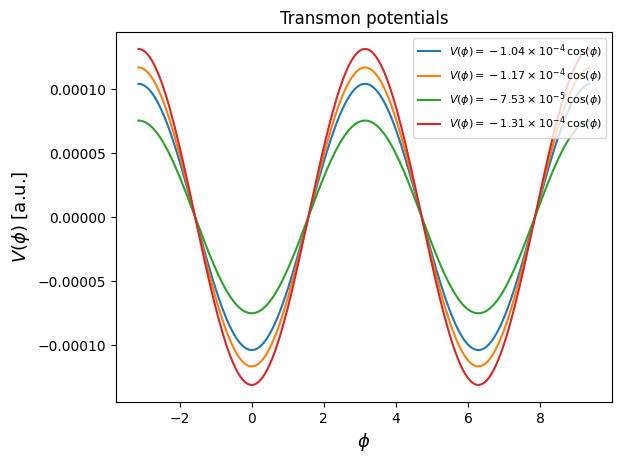

In [118]:
for i, potential in enumerate(V[:4]):
    label = (r"$V(\phi) ="
             f"- {format_latex(params[i][0])} \, \cos(\phi)"
             r"$")
    plt.plot(phi, potential, label=label)
plt.xlabel('$\phi$')
plt.ylabel('$V(\phi)$ [a.u.]')
plt.title('Transmon potentials')
plt.legend(prop={'size': 8});

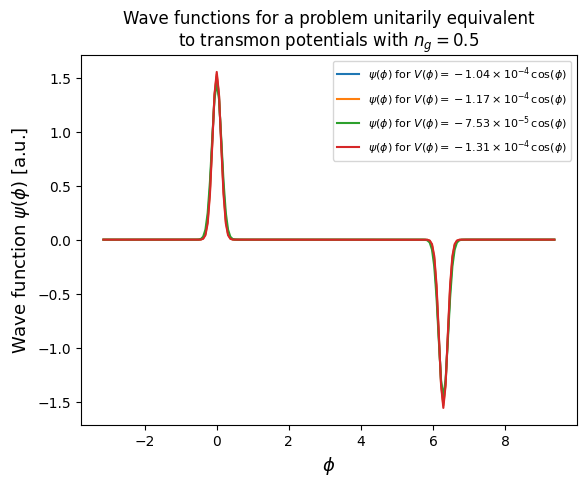

In [119]:
for i, wavefunction in enumerate(waves[:4]):
    label = (r"$\psi(\phi)$ for $V(\phi) ="
             f"- {format_latex(params[i][0])} \, \cos(\phi)"
             r"$")
    plt.plot(phi, wavefunction, label=label)
plt.xlabel('$\phi$')
plt.ylabel('Wave function $\psi(\phi)$ [a.u.]')
plt.title(('Wave functions for a problem unitarily equivalent\n'
           f'to transmon potentials with $n_g={ng}$'))
plt.legend(prop={'size': 8});

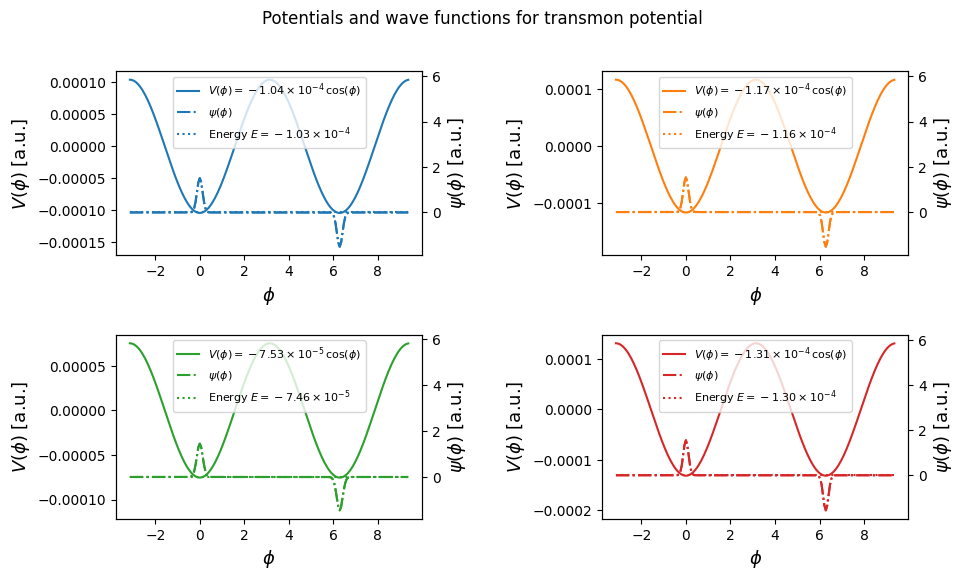

In [120]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle("Potentials and wave functions for transmon potential")
colours = list(mcolors.TABLEAU_COLORS)
for i, omega in enumerate(params[:4]):
    Vrange = V[i].max()-V[i].min()
    alpha = Vrange/1.5-np.abs(E[i])
    ax = plt.subplot(2, 2, i+1)
    label_wave = r"$\psi(\phi)$"
    label_V = (r"$V(\phi) ="
               f"- {format_latex(params[i][0])} \, \cos(\phi)"
               r"$")
    label_E = (r"Energy $E = "
               f"{format_latex(E[i])} $")
    ln1 = ax.plot(phi, V[i], '-', color=colours[i], label=label_V)
    ln2 = ax.plot(phi, alpha*waves[i]+E[i], '-.',
                  color=colours[i], label=label_wave)
    ln3 = ax.plot(phi, E[i]*np.ones_like(phi), ':',
                  color=colours[i], label=label_E)
    plt.xlabel('$\phi$')
    plt.ylabel('$V(\phi)$ [a.u.]')
    ypmax = (ax.get_ylim()[1]-E[i])/alpha
    ypmin = (ax.get_ylim()[0]-E[i])/alpha
    ax2 = ax.twinx()
    ax2.set_ylim((ypmin, ypmax))
    ln2 = plt.plot(phi, waves[i], '-.',
                   color=colours[i], label=label_wave)
    plt.ylabel('$\psi(\phi)$ [a.u.]')
    ax.legend(prop={'size': 8}, loc='upper center')
fig.tight_layout(pad=2.0)

We can calculate the energy levels. Since we extended the domain, the energy levels will be multiply degenerate. One can understand that in the following way:

If the energy wells are deep enough, one can consider a wave function which occupies only a particular energy well and is zero outside of it. Therefore, the system can be approximated. to the first order, as a tensor product of wave functions for each potential well, which do not interact with each other. As the interaction is absent, and the potential is still $2\pi$ periodic, we will have a degeneracy goven by the number of the local minima of the potential.

In [121]:
Es = []
for n_state in range(15):
    Es.append(data_gen.generate_data(n_state, display=None)[0])
Es = np.array(Es).T
Es

array([[-1.03212105e-04, -1.03212105e-04, -1.01635227e-04,
        -1.01635227e-04, -1.00061363e-04, -1.00061363e-04,
        -9.84905199e-05, -9.84905199e-05, -9.69227073e-05,
        -9.69227073e-05, -9.53579341e-05, -9.53579341e-05,
        -9.37962092e-05, -9.37962092e-05, -9.22375412e-05],
       [-1.15948268e-04, -1.15948268e-04, -1.14277107e-04,
        -1.14277107e-04, -1.12608959e-04, -1.12608959e-04,
        -1.10943832e-04, -1.10943832e-04, -1.09281733e-04,
        -1.09281733e-04, -1.07622671e-04, -1.07622671e-04,
        -1.05966655e-04, -1.05966655e-04, -1.04313690e-04],
       [-7.46201327e-05, -7.46201327e-05, -7.32788939e-05,
        -7.32788939e-05, -7.19406703e-05, -7.19406703e-05,
        -7.06054722e-05, -7.06054722e-05, -6.92733099e-05,
        -6.92733099e-05, -6.79441941e-05, -6.79441941e-05,
        -6.66181352e-05, -6.66181352e-05, -6.52951442e-05],
       [-1.30360788e-04, -1.30360788e-04, -1.28588986e-04,
        -1.28588986e-04, -1.26820196e-04, -1.26820196

We are interested only in unique energy levels.

In [122]:
Es[:, ::2]

array([[-1.03212105e-04, -1.01635227e-04, -1.00061363e-04,
        -9.84905199e-05, -9.69227073e-05, -9.53579341e-05,
        -9.37962092e-05, -9.22375412e-05],
       [-1.15948268e-04, -1.14277107e-04, -1.12608959e-04,
        -1.10943832e-04, -1.09281733e-04, -1.07622671e-04,
        -1.05966655e-04, -1.04313690e-04],
       [-7.46201327e-05, -7.32788939e-05, -7.19406703e-05,
        -7.06054722e-05, -6.92733099e-05, -6.79441941e-05,
        -6.66181352e-05, -6.52951442e-05],
       [-1.30360788e-04, -1.28588986e-04, -1.26820196e-04,
        -1.25054425e-04, -1.23291681e-04, -1.21531972e-04,
        -1.19775308e-04, -1.18021680e-04],
       [-4.31091988e-05, -4.20890358e-05, -4.10718927e-05,
        -4.00577834e-05, -3.90467215e-05, -3.80387210e-05,
        -3.70337962e-05, -3.60319616e-05]])

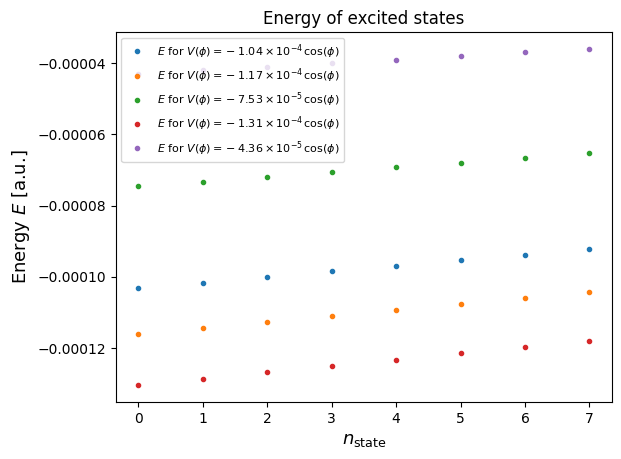

In [123]:
fig, ax = plt.figure(), plt.axes()
colours = list(mcolors.TABLEAU_COLORS)
for i, E in enumerate(Es[:, ::2]):
    plt.plot(np.arange(E.shape[0]), E,
             '.', color=colours[i],
             label=(r"$E$ for $V(\phi) ="
                    f"-{format_latex(params[i][0])} \, \cos(\phi)"
                    r"$"))
plt.legend(prop={'size': 8})
plt.xlabel(r'$n_{\text{state}}$')
plt.ylabel('Energy $E$ [a.u.]')
plt.title("Energy of excited states")
plt.xticks(np.arange(Es[:, ::2].shape[1]));

The energies of this system are described by characteristic value of even Mathieu functions $a_r(q)$ (provided in python by `scipy.special.mathieu_a`). [\[11\]](#Bibliography).

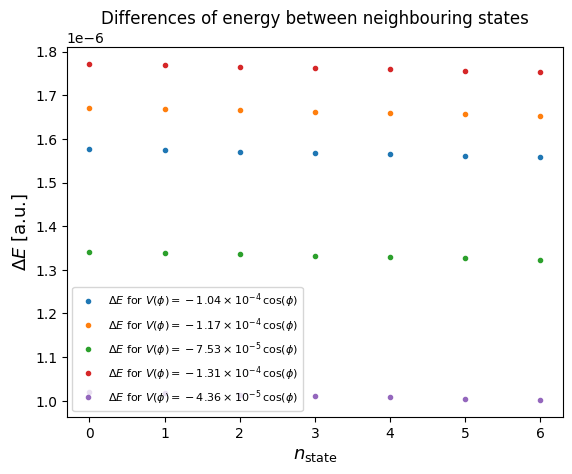

In [124]:
fig, ax = plt.figure(), plt.axes()
colours = list(mcolors.TABLEAU_COLORS)
for i, E in enumerate(np.diff(Es[:, ::2], 1)):
    plt.plot(np.arange(E.shape[0]), E,
             '.', color=colours[i],
             label=(r"$\Delta E$ for $V(\phi) ="
                    f"-{format_latex(params[i][0])} \, \cos(\phi)"
                    r"$"))
plt.legend(prop={'size': 8})
plt.xlabel(r'$n_{\text{state}}$')
plt.ylabel('$\Delta E$ [a.u.]')
plt.title("Differences of energy between neighbouring states")
plt.xticks(np.arange(Es[:, ::2].shape[1]-1));

We can compare the energies that we obtained from the current calculation with the one from the [section 2.2.2](#2.2.2.-$n_g-=-1/2$). As we see, they are the same.

In [125]:
Es[:, ::2] - Es_transmon_05[:, :Es[:, ::2].shape[1]]

array([[ 6.77626358e-20, -6.77626358e-20, -1.27393755e-18,
         2.64003229e-17, -4.37922810e-16,  5.19545615e-15,
        -5.46715451e-14,  4.30221586e-13],
       [ 6.77626358e-20,  3.25260652e-19, -9.14795583e-18,
         1.83379245e-16, -2.87946479e-15,  3.20129529e-14,
        -3.17633710e-13,  2.32333380e-12],
       [-1.35525272e-20,  1.35525272e-20, -1.35525272e-20,
         1.35525272e-20, -1.20617492e-18,  1.69948691e-17,
        -2.08383658e-16,  1.98067474e-15],
       [-2.71050543e-19,  1.97866896e-18, -6.14742632e-17,
         1.15188349e-15, -1.70970280e-14,  1.77681112e-13,
        -1.66000314e-12,  1.12431212e-11],
       [-4.06575815e-20, -6.09863722e-20,  4.74338450e-20,
         6.77626358e-20,  7.45388994e-20,  8.80914265e-20,
         6.77626358e-20,  1.08420217e-19]])

The relative errors (in %) are as follows

In [126]:
100*(Es[:, ::2] - Es_transmon_05[:, :Es[:, ::2].shape[1]])/Es[:, ::2]

array([[-6.56537678e-14,  6.66723906e-14,  1.27315631e-12,
        -2.68049381e-11,  4.51826844e-10, -5.44837323e-09,
         5.82875849e-08, -4.66427857e-07],
       [-5.84421287e-14, -2.84624505e-13,  8.12364831e-12,
        -1.65290167e-10,  2.63490037e-09, -2.97455477e-08,
         2.99748736e-07, -2.22725684e-06],
       [ 1.81620250e-14, -1.84944483e-14,  1.88384777e-14,
        -1.91947263e-14,  1.74118274e-12, -2.50129820e-11,
         3.12803198e-10, -3.03341813e-09],
       [ 2.07923370e-13, -1.53875462e-12,  4.84735595e-11,
        -9.21105744e-10,  1.38671383e-08, -1.46201126e-07,
         1.38593101e-06, -9.52631850e-06],
       [ 9.43130064e-14,  1.44898478e-13, -1.15489796e-13,
        -1.69162220e-13, -1.90896691e-13, -2.31583566e-13,
        -1.82975127e-13, -3.00900125e-13]])

While recovering the energies is straightforward in this approach, how one could get the wavefunctions of the original problem from the wavefunctions obtained using the DVR procedure for the unitarily transformed system?

In [127]:
psis = []
for n_state in range(8):
    psis.append(data_gen.generate_data(n_state, display=None)[1])
psis = np.array(psis)[:, 0, :]

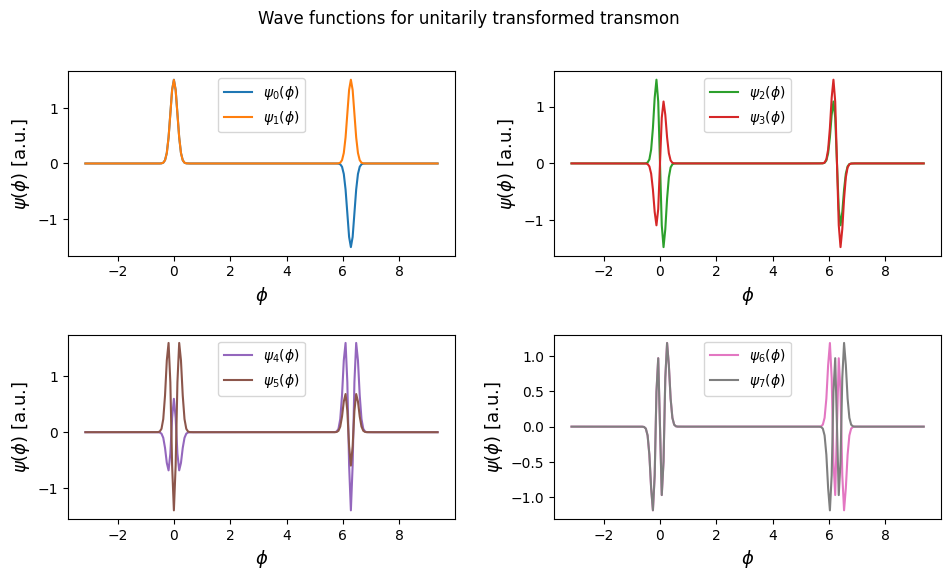

In [128]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle("Wave functions for unitarily transformed transmon")
for i, j in enumerate(range(0, psis.shape[0], 2)):
    plt.subplot(2, 2, i+1)
    for k in range(2):
        plt.plot(phi, psis[k+j], '-', color=colours[k+j],
                 label=f"$\psi_{k+j}(\phi)$")
        plt.ylabel('$\psi(\phi)$ [a.u.]')
        plt.xlabel('$\phi$')
        plt.legend(prop={'size': 10}, loc="upper center")
fig.tight_layout(pad=2.0)

### C.2. Extracting wave functions for original problem

While the problem of recovering wave functions is more complicated, we will suggest the solution. Let us again compute the wave function for $n=1/2$ case.

For the illustration purposes, we will use unphysical values of $E_C$ and $E_J$.

In [129]:
EC = 1

phimin = -np.pi
phimax = np.pi
n_state = 0
N = 200
n_samples = 1
ng = 1/2

mass = 1/(8*EC)

V_transmon = lambda x, *A: -A[0]*np.cos(x)
params = np.array([[500]])
phi = np.arange(phimin, phimax, (phimax - phimin)/N)
Vs = construct_potentials(V_transmon, params, phi)

In [130]:
data_gen = CustomKineticOperator(N, phimin, phimax, Vs, mass,
                                 hbar=1.,  # We use hbar=1 because phi
                                 # and the momentum are
                                 # dimensionless
                                 lin_kin_coeff=-ng,
                                 const_kin_coeff=ng**2)

E, a = data_gen.generate_data(n_state, display=None)
waves, phi, _ = data_gen.final_wavefunction(a)
V, _ = data_gen.evaluate_potential()

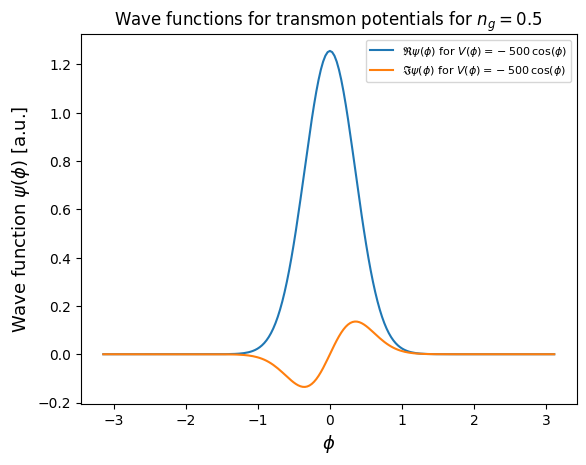

In [131]:
for i, wavefunction in enumerate(waves[:1]):
    label = (r"$\psi(\phi)$ for $V(\phi) ="
             f"- {params[i][0]:0.0f} \, \cos(\phi)"
             r"$")
    plt.plot(phi, wavefunction.real,
             label=("$\mathfrak{R}$" + label))
    plt.plot(phi, wavefunction.imag,
             label=("$\mathfrak{I}$" + label))
plt.xlabel('$\phi$')
plt.ylabel('Wave function $\psi(\phi)$ [a.u.]')
plt.title(f'Wave functions for transmon potentials for $n_g={ng}$')
plt.legend(prop={'size': 8});

We can also compute the wave functions for the unitarily transformed problem.

In [132]:
EC = 1

phimin = -2*np.pi+np.pi
phimax = 2*np.pi+np.pi
n_state = 0
N = 200
n_samples = 1

mass = 1/(8*EC)

V_transmon = lambda x, *A: -A[0]*np.cos(x)
params = np.array([[50]])
phi = np.arange(phimin, phimax, (phimax - phimin)/N)
Vs = construct_potentials(V_transmon, params, phi)

In [133]:
data_gen = CustomPotential(N, phimin, phimax, Vs, mass,
                           hbar=1.)  # We use hbar=1 because phi and
# the momentum are dimensionless
psis = []
for n_state in range(2):
    psis.append(data_gen.generate_data(n_state, display=None)[1])
psis = np.array(psis)[:, 0, :]

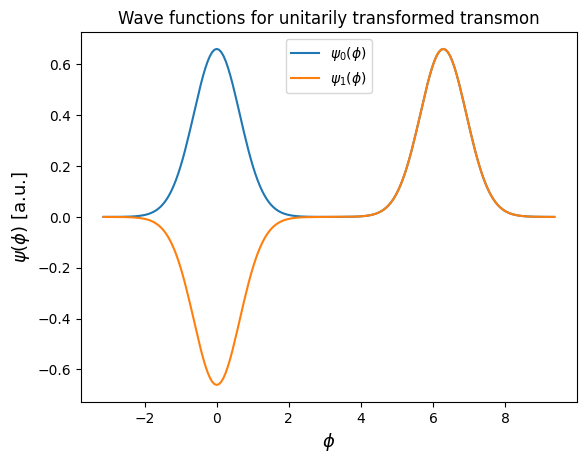

In [134]:
fig, ax = plt.figure(), plt.axes()
plt.title("Wave functions for unitarily transformed transmon")
for k in range(2):
    plt.plot(phi, psis[k], '-', color=colours[k],
             label=f"$\psi_{k}(\phi)$")
plt.ylabel('$\psi(\phi)$ [a.u.]')
plt.xlabel('$\phi$')
plt.legend(prop={'size': 10}, loc="upper center");

By taking linear combinations of the wave functions corresponding to the same energy, we can recover the solutions which look the same as the original one.

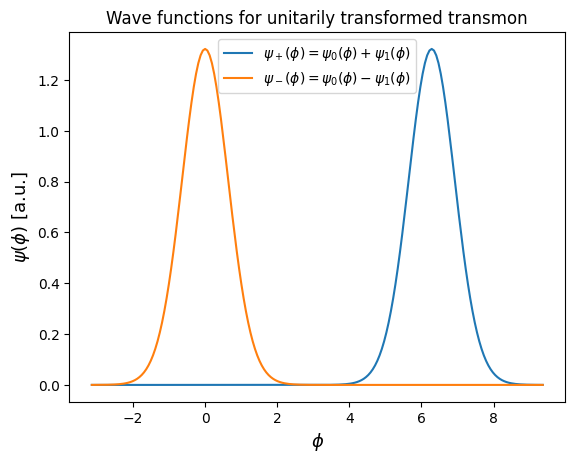

In [135]:
psiplus = psis[0] + psis[1]
psiminus = psis[0] - psis[1]

fig, ax = plt.figure(), plt.axes()
plt.title("Wave functions for unitarily transformed transmon")
plt.plot(phi, psiplus, '-', color=colours[0],
         label="$\psi_+(\phi) = \psi_0(\phi) + \psi_1(\phi)$")
plt.plot(phi, psiminus, '-', color=colours[1],
         label="$\psi_-(\phi) = \psi_0(\phi) - \psi_1(\phi)$")
plt.ylabel('$\psi(\phi)$ [a.u.]')
plt.xlabel('$\phi$')
plt.legend(prop={'size': 10}, loc="upper center");

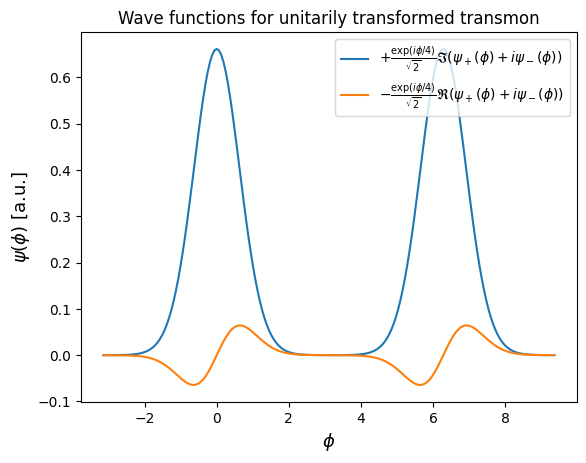

In [136]:
fig, ax = plt.figure(), plt.axes()
plt.title("Wave functions for unitarily transformed transmon")
plt.plot(phi, +1/2*np.imag(np.exp(1j*phi/4)*(psiplus+1j*psiminus)),
         label=(r"$+\frac{\exp(i\phi/4)}{\sqrt{2}}"
                r"\mathfrak{I}(\psi_+(\phi)+i\psi_-(\phi))$"))
plt.plot(phi, -1/2*np.real(np.exp(1j*phi/4)*(psiplus+1j*psiminus)),
         label=(r"$-\frac{\exp(i\phi/4)}{\sqrt{2}}"
                "\mathfrak{R}(\psi_+(\phi)+i\psi_-(\phi))$"))
plt.ylabel('$\psi(\phi)$ [a.u.]')
plt.xlabel('$\phi$')
plt.legend(prop={'size': 10}, loc="upper right");

## Bibliography

[1] Devoret, M.H., Martinis, J.M. (2005). Implementing Qubits with Superconducting Integrated Circuits. In: Everitt, H.O. (eds) Experimental Aspects of Quantum Computing. Springer, Boston, MA. https://doi.org/10.1007/0-387-27732-3_12.

[2] Kockum, A.F., Nori, F. (2019). Quantum Bits with Josephson Junctions. In: Tafuri, F. (eds) Fundamentals and Frontiers of the Josephson Effect. Springer Series in Materials Science, vol 286. Springer, Cham. https://doi.org/10.1007/978-3-030-20726-7_17.

[3] Langford, N.K. (2013). Circuit QED - Lecture Notes. [arXiv:1310.1897 [quant-ph]](https://arxiv.org/abs/1310.1897).

[4] Farrington, M. (2021). [A Brief Introduction to Superconducting Charge Qubits](https://homes.psd.uchicago.edu/~sethi/Teaching/P243-W2021/Final%20Papers/MFarrington_Advanced_Quantum_Mechanics_Final_Project%20(1).pdf).

[5] Josephson, B.D. (1962). Possible new effects in superconductive tunnelling. Phys. Lett. 1, 251-253. https://doi.org/10.1016/0031-9163(62)91369-0.

[6] Girvin, S.M., Devoret, M.H., Schoelkopf, R.J. (2009). Circuit QED and engineering charge-based superconducting qubits. Phys. Scr. 2009 014012. https://doi.org/10.1088/0031-8949/2009/T137/014012.

[7] Blais, A., Grimsmo, A.L., Girvin, S.M., Wallraff, A. (2021). Circuit quantum electrodynamics. Rev. Mod. Phys. 93, 025005. https://doi.org/10.1103/RevModPhys.93.025005.

[8] Rasmussen, S.E., Christensen, K.S., Pedersen, S.P., Kristensen, L.B., Bækkegaard, T., Loft, N.J.S., Zinner, N.T. (2021). Superconducting Circuit Companion---an Introduction with Worked Examples. PRX Quantum 2, 040204. https://doi.org/10.1103/PRXQuantum.2.040204.

[9] Bouchiat, V., Vion, D., Joyez, P., Esteve, D., Devoret, M.H. (1998). Quantum coherence with a single Cooper pair. Phys. Scr. 1998 165. https://doi.org/10.1238/Physica.Topical.076a00165.

[10]  Girvin, S. M. (2011). Circuit QED: superconducting qubits coupled to microwave photons. In: Devoret, M. (eds) Quantum Machines: Measurement and Control of Engineered Quantum Systems: Lecture Notes of the Les Houches Summer School: Volume 96, July 2011. https://doi.org/10.1093/acprof:oso/9780199681181.003.0003. 

[11] Cottet, A. (2002). [Implementation of a quantum bit in a superconducting circuit](https://iramis.cea.fr/spec/Pres/Quantro/static/wp-content/uploads/2010/10/Cottet.pdf). PhD Thesis.

## Postscript

Here the figures used in the Markdown text contained withing this notebook are generated.

In [137]:
def construct_potentials(function: PCallable,
                         parameters: np.ndarray[Any,
                                                np.dtype[np.float64]],
                         x: np.ndarray[Any, np.dtype[np.float64]]
                         ) -> np.ndarray[Any, np.dtype[np.float64]]:
    '''
    Returns the final wavefunctions psi(x) for each sample potential.

    Parameters
    ----------
    function : Callable
        Potential as a function of position and parameters.
    parameters : np.ndarray[Any, np.dtype[np.float64]]
        (n_samples x n_parameters) array. Parameters of the potentials.
    x : np.ndarray[Any, np.dtype[np.float64]]
        (N) array. Values in the domain between xmin and xmax.

    Returns
    -------
    np.ndarray[Any, np.dtype[np.float64]]
        (n_samples x N) array. Potentials evaluated on the domain `x`
        with parameters given by `parameters`

    Examples
    --------
    >>> import numpy as np
    >>> import scipy
    >>> f = lambda x, *A: A[0] + A[1]*x + A[2]*x**2
    >>> params = np.array([[1,0,0], [0,1,0], [0,0,1]])
    >>> x = np.linspace(0,4,6)
    >>> construct_potentials(f, params, x)
    array([[ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ],
           [ 0.  ,  0.8 ,  1.6 ,  2.4 ,  3.2 ,  4.  ],
           [ 0.  ,  0.64,  2.56,  5.76, 10.24, 16.  ]])
    '''
    f: Callable[[np.ndarray[Any, np.dtype[np.float64]]],
                np.ndarray[Any, np.dtype[np.float64]]
                ] = lambda a: function(x, *a)
    return np.apply_along_axis(f, 1, parameters)

In [138]:
xmin = -np.pi*2
xmax = np.pi*2
n_state = 0
N = 200
n_samples = 4

V_phase = lambda x, *A: -A[0]*x - A[1]*np.cos(x)
params = np.hstack((np.array([0., 0.1, 0.5, 1.]).reshape(-1, 1),
                    np.ones((n_samples, 1))))
x = np.arange(xmin, xmax, (xmax - xmin)/N)
Vs = construct_potentials(V_phase, params, x)

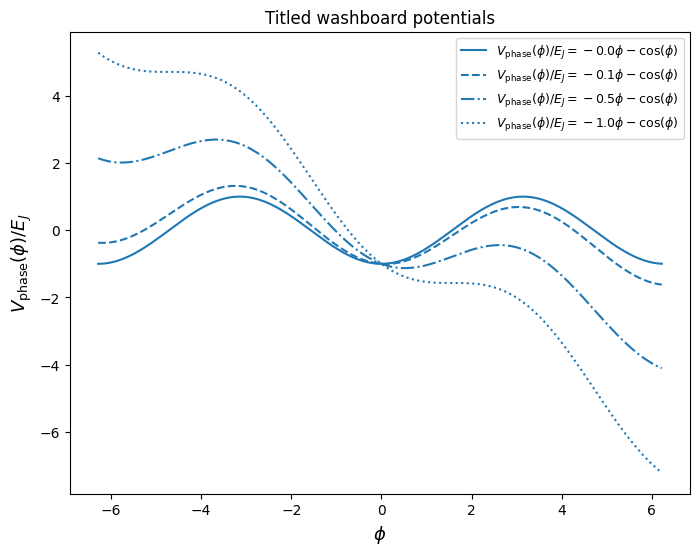

In [139]:
fig, ax = plt.figure(figsize=(4*2, 3*2)), plt.axes()
linestyle = ['-', '--', '-.', ':']
colours = list(mcolors.TABLEAU_COLORS)
for i, potential in enumerate(Vs):
    label = (r"$V_\text{phase}(\phi)/E_J ="
             f"{-params[i][0]:0.1f} \phi - \cos(\phi)"
             r"$")
    plt.plot(x, potential, label=label, linestyle=linestyle[i],
             color=colours[0])
plt.xlabel(r'$\phi$')
plt.ylabel(r'$V_\text{phase}(\phi)/E_J$')
plt.title('Titled washboard potentials')
plt.legend(
    prop={'size': 9}
)
fig.savefig('./assets/images/titled_washboard.png', dpi=400)

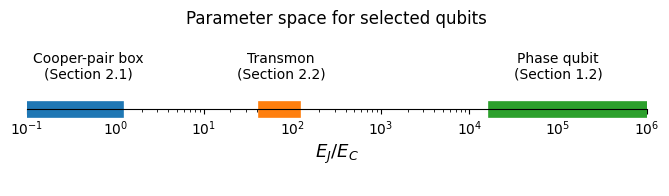

In [140]:
fig, ax = plt.figure(figsize=(4*2, 2)), plt.axes()
colours = list(mcolors.TABLEAU_COLORS)

plt.plot([1/10, 1],
         np.zeros([2]), '-',
         color=colours[0], linewidth=12)
plt.text(1/2, 0.15, "Cooper-pair box", horizontalalignment="center")
plt.text(1/2, 0.1, "(Section 2.1)", horizontalalignment="center")
plt.plot([50, 100],
         np.zeros([2]), '-',
         color=colours[1], linewidth=12)
plt.text(75, 0.15, "Transmon", horizontalalignment="center")
plt.text(75, 0.1, "(Section 2.2)", horizontalalignment="center")
plt.plot([2*10**4, 10**6],
         np.zeros([2]), '-',
         color=colours[2], linewidth=12)
plt.text(10**5, 0.15, "Phase qubit", horizontalalignment="center")
plt.text(10**5, 0.1, "(Section 1.2)", horizontalalignment="center")

plt.xlabel(r'$E_J/E_C$')
plt.title('Parameter space for selected qubits')

plt.xscale('log')
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylim((-1/4, 1/4))
plt.xlim((1/10, 10**6))
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

fig.savefig('./assets/images/parameter_space.png', dpi=400)

In [141]:
try:
    import doctest
    print(doctest.testmod())
except Exception as e:
    pass

TestResults(failed=0, attempted=86)
